# Comparing ADMM with K means method

Copyright (c) 2024 University of Strasbourg
Author: Massyl Moudoud <mmoudoud@unistra.fr> 
Contributor(s) : Céline Meillier <meillier@unistra.fr>, Vincent Mazet <vincent.mazet@unistra.fr>

This work has been supported by the ANR project DynaSTI: ANR-22-CE45-0008

This software is governed by the CeCILL  license under French law and
abiding by the rules of distribution of free software.  You can  use, 
modify and/ or redistribute the software under the terms of the CeCILL
license as circulated by CEA, CNRS and INRIA at the following URL
"http://www.cecill.info". 

As a counterpart to the access to the source code and  rights to copy,
modify and redistribute granted by the license, users are provided only
with a limited warranty  and the software's author,  the holder of the
economic rights,  and the successive licensors  have only  limited
liability. 

In this respect, the user's attention is drawn to the risks associated
with loading,  using,  modifying and/or developing or reproducing the
software by the user in light of its specific status of free software,
that may mean  that it is complicated to manipulate,  and  that  also
therefore means  that it is reserved for developers  and  experienced
professionals having in-depth computer knowledge. Users are therefore
encouraged to load and test the software's suitability as regards their
requirements in conditions enabling the security of their systems and/or 
data to be ensured and,  more generally, to use and operate it in the 
same conditions as regards security. 

The fact that you are presently reading this means that you have had
knowledge of the CeCILL license and that you accept its terms.

In [32]:
#imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
import itertools
#To load ROIs info
import csv

#import Kmeans
from sklearn.cluster import KMeans

functionPath = "../src"
sys.path.append(functionPath)

from utile import * 
from Preprocessing.load_data import load_fMRI_data
from Preprocessing.sliding_correlation import list_of_corr_matrices
from joint_estimation_A_D.joint_optimization_A_D_ADMM import joint_estimation_A_D

In [33]:
def make_noise(C, rsb):
    P_c = np.sum(C**2)/np.prod(C.shape)
    sig_noise = P_c *10**(-rsb/10)
    
    C_noise = C + np.random.default_rng().normal(0, sig_noise, size = C.shape)
    C_noise[C_noise >= 1] = 0.99
    C_noise[C_noise <= -1] = -0.99
    return C_noise

In [34]:
def knee_method(Cvec,  K_min, K_max, C_VT = None, plot= False):
    """
    Apply K means on the input data in the given range of clusters to use the elbow method
    Inputs:
        Cvec: E x T matrix of verctorized correlation matrices
        C_VT: E x T Ground truth correlation matrix (if available)
        K_min, K_max: range of number of clusters
        plot: constrol if the result is plotted
    Outputs:
        wcss: within cluster sum of squares
        MSE: Mean squared reconstruction error (if available the ground truth is used)     
    """
    
    if C_VT is None:
        C_VT = Cvec
    
    klist =np.arange(K_min, K_max)
    wcss = np.zeros((len(klist)))
    MSE = np.zeros((len(klist)))

    for j, k in enumerate(klist):
        K_means_model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300,
                        n_init = 50, random_state = 0)
        K_means_model.fit(Cvec.T)

        states = K_means_model.predict(Cvec.T)
        C_rec_K = np.zeros(Cvec.shape)
        for i in range(states.shape[0]):
            C_rec_K[:,i] = K_means_model.cluster_centers_[states[i]]
        MSE[j] = np.mean((C_VT-C_rec_K)**2)

        wcss[j] = K_means_model.inertia_

    #Plotting the results onto a line graph, allowing us to observe 'The elbow'
    if plot:
        plt.figure()
        plt.subplot(121)
        plt.plot(klist, wcss)
        plt.title('The elbow method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS') #within cluster sum of squares
        plt.subplot(122)
        plt.plot(klist, MSE)
        plt.xlabel('Number of clusters')
        plt.title("Reconstruction error")
        plt.show()
    
    return wcss, MSE

In [35]:
def kmeans_clustering(Cvec, n_clusters , n_init = 10):
    K_means_model = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300,
                        n_init = n_init, random_state = 0)
    K_means_model.fit(Cvec.T)

    states = K_means_model.predict(Cvec.T)
    
    centroids = K_means_model.cluster_centers_.T
    
    return centroids , states

In [36]:
#get a list of color for plots
list_colors = get_list_colors()

# Simulation data

### Load data

In [8]:
# use simulation data
path = "../data/simulation/data_simulation_A_D.npz"
data  = np.load(path)
A_VT = data["A"]
D_VT = data["D"]

R, P = D_VT.shape
T = A_VT.shape[1]

D_tilde = np.int32(D_VT > 0)
C_VT = D_VT @ A_VT
lenW =55 #not used here

network_list = ["1" , "1a", "1b" , "2" , "2a" , "2b" , "2c" , "2d" , "3" , "3a" , "3b"]

In [9]:
N_clusters = 11

K_means_model = KMeans(n_clusters = N_clusters, init = 'k-means++', n_init = 50)

K_means_model.fit(C_VT.T)
states = K_means_model.predict(C_VT.T)

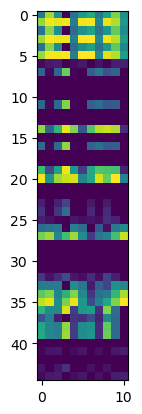

In [10]:
plt.imshow(K_means_model.cluster_centers_.T)

In [11]:
n_clusters = 10
centroids, states2 = kmeans_clustering(C_VT, n_clusters=n_clusters)

In [12]:
transitions = np.diff(states ,prepend = states[0]) != 0
transitions_idx = np.where(transitions)[0]
transitions2 = np.diff(states2 ,prepend = states2[0]) != 0

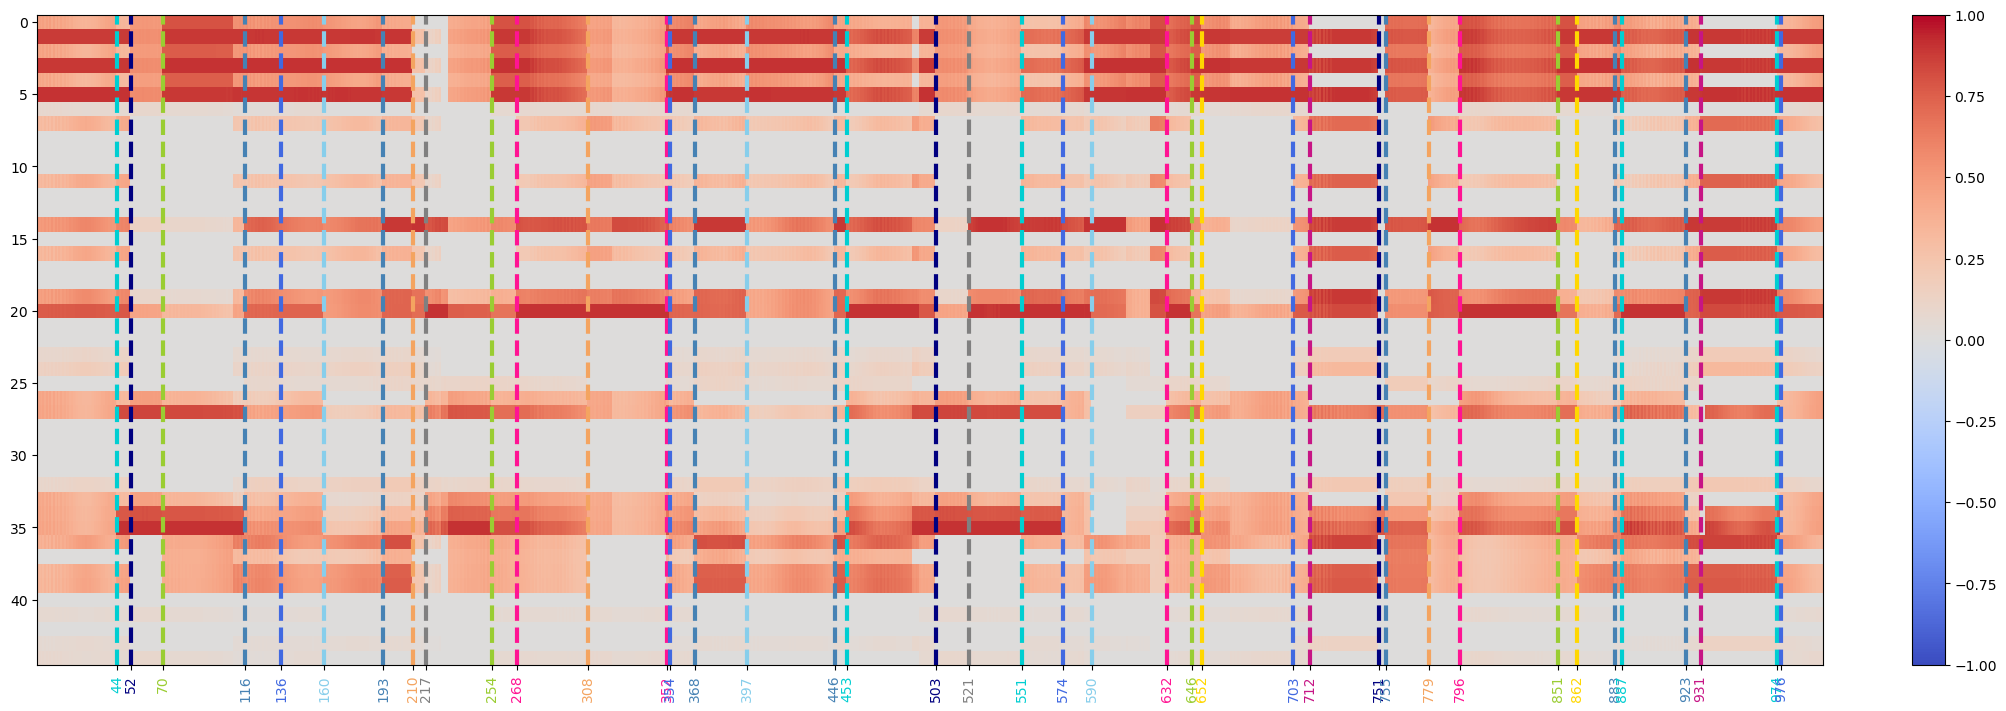

In [13]:
fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
plt.imshow(C_VT, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.grid(False)
plt.colorbar()

#mark the transitions of the states
plt.xticks(transitions_idx , rotation = 90)

for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
    #set the xtick to the colors of the state
    state_color = list_colors[states[tr_idx]]
    label.set_color(state_color)
    #mark the transition of the states
    plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)


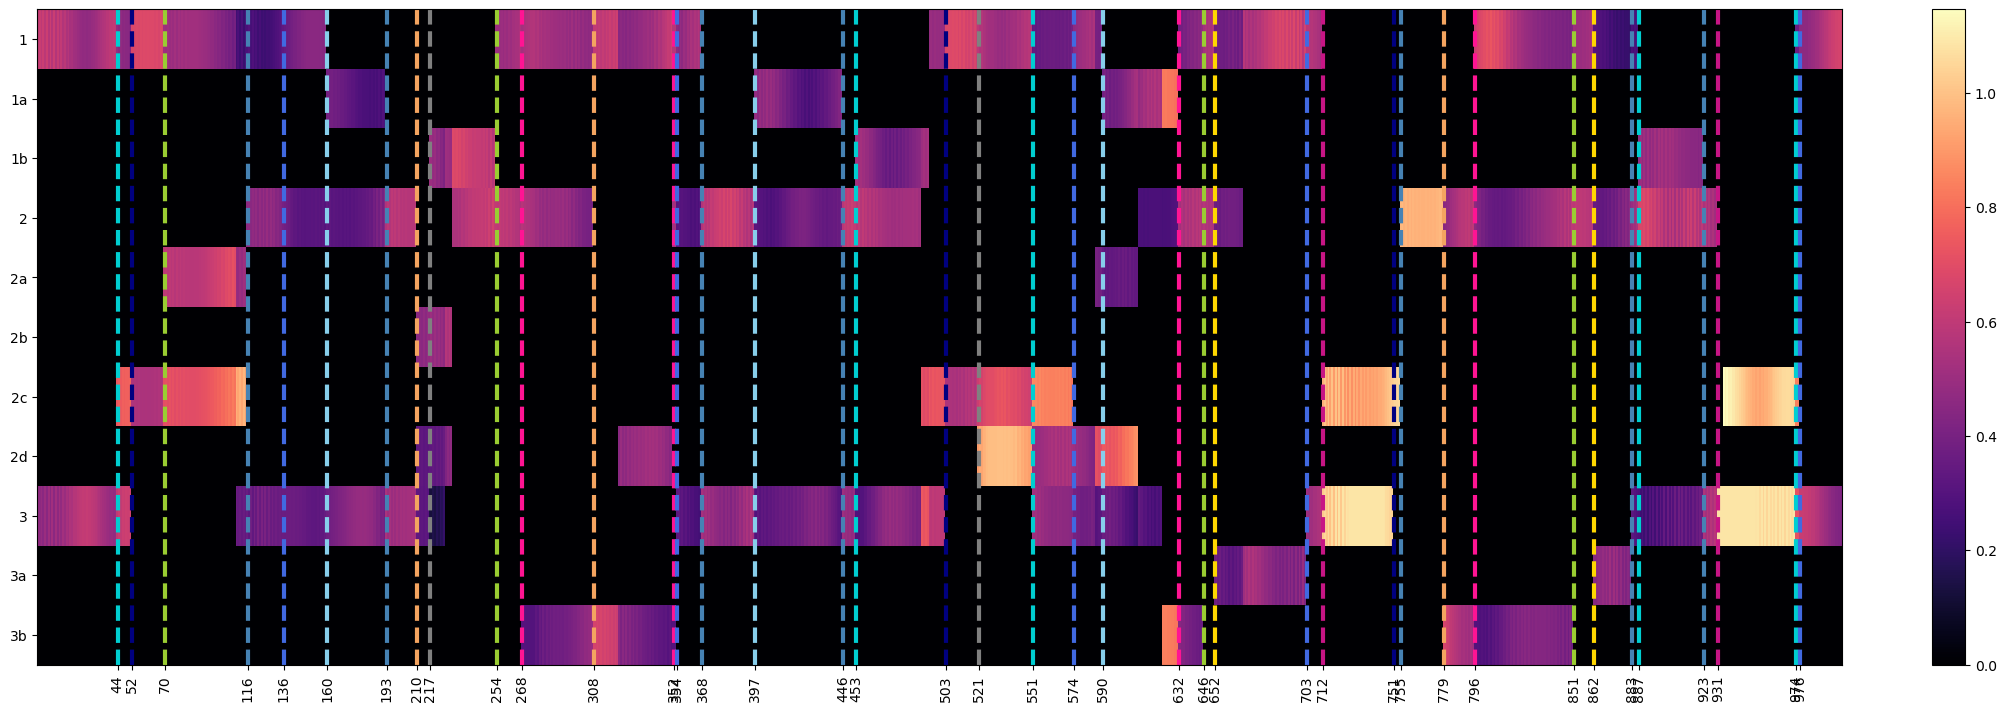

In [14]:
plt.figure(layout = "constrained" , figsize=(20,7))
plt.imshow(A_VT, aspect = 'auto', interpolation = 'nearest', cmap = 'magma')
plt.grid(False)
plt.yticks(np.arange(P) , network_list);
plt.colorbar()


#mark the transitions of the states
plt.xticks(transitions_idx , rotation = 90)

for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
    #set the xtick to the colors of the state
    state_color = list_colors[states[tr_idx]]
    label.set_color(state_color)
    #mark the transition of the states
    plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)

### exact C

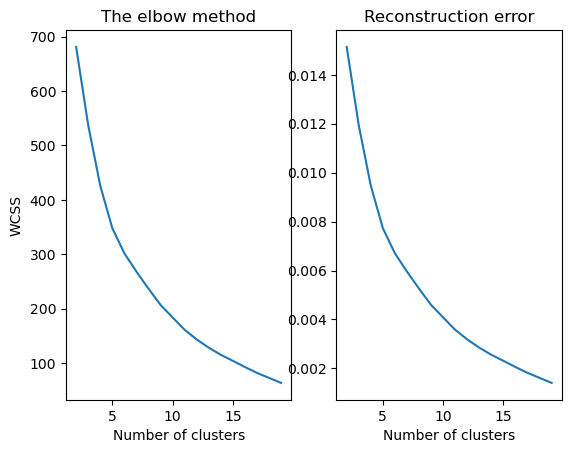

(array([681.27142545, 537.23055664, 425.9483108 , 347.87675678,
        301.64452672, 267.99363971, 236.64082479, 206.72259196,
        183.70484546, 160.96529643, 143.22890582, 128.114823  ,
        114.96742708, 103.900662  ,  92.48715134,  81.721149  ,
         72.51477318,  63.26941665]),
 array([0.01513937, 0.01193846, 0.00946552, 0.00773059, 0.00670321,
        0.00595541, 0.00525868, 0.00459384, 0.00408233, 0.00357701,
        0.00318286, 0.002847  , 0.00255483, 0.0023089 , 0.00205527,
        0.00181603, 0.00161144, 0.00140599]))

In [15]:
knee_method(Cvec = C_VT,  K_min = 2, K_max =20, C_VT = None, plot= True)

### With Noise 0dB

In [16]:
C_noise =make_noise(C_VT, 0)

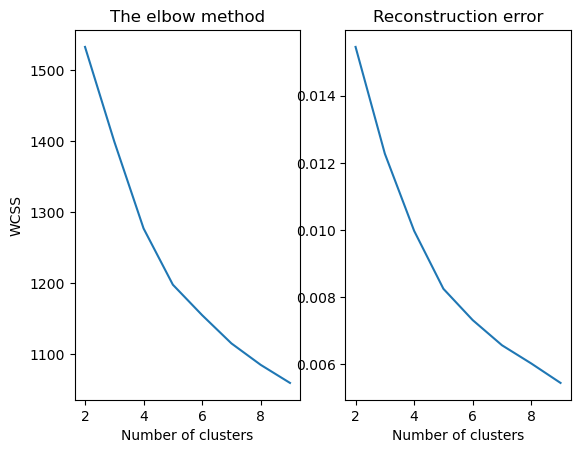

(array([1533.10354163, 1399.50998692, 1276.92100371, 1197.57863776,
        1154.59702445, 1114.75451868, 1084.48025177, 1058.98637645]),
 array([0.01545304, 0.01227237, 0.00997565, 0.00824867, 0.00731678,
        0.00656743, 0.00602483, 0.00544527]))

In [17]:
knee_method(Cvec = C_noise,  K_min = 2, K_max =10, C_VT = C_VT, plot= True)

# fMRI data

### Load data

In [37]:
path = "../data/fMRI_timecourses"
TC_data , D_tilde = load_fMRI_data(path)
#get shape of data
R , T = TC_data[0].shape
P = D_tilde.shape[1]

In [38]:
#keep only active pairs in D
active_pairs = np.sum(D_tilde , axis=1)>0
D_tilde = D_tilde[active_pairs, :]


In [39]:
# Get correlation matrices
#get correlation matrix
lenW = 55 #window length

#create the window
window = np.ones(lenW)
win = np.convolve(window,sp.signal.windows.gaussian(lenW, std=3), mode = 'same')
window = win/np.max(win)


C_lists = list()
Cvec_list = list()

for TC in TC_data:
    C_list = list_of_corr_matrices(TC, window, step = 1)
    C_lists.append(C_list)
    #Cvec contains only active pairs of ROI
    Cvec_list.append(build_C_vectors(R,C_list)[active_pairs, :])
    
E , N_windows = Cvec_list[0].shape

### load estimated A and D

In [40]:
results_list = np.load("./optimization_results/fMRI/estimation_multisubjects.npy" , allow_pickle=True)

## Apply K means Knee method

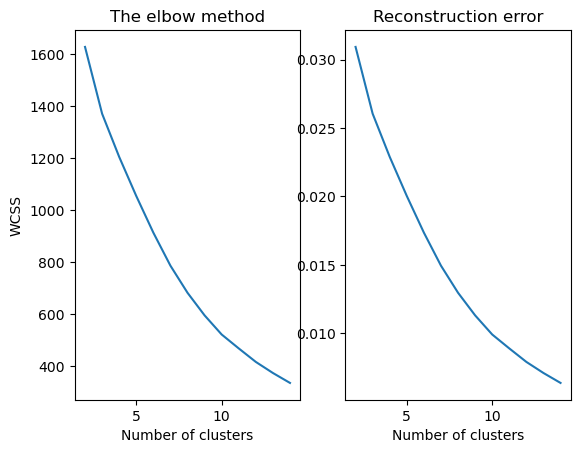

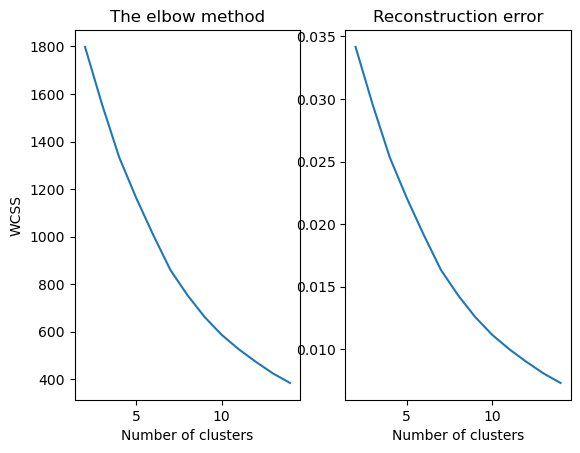

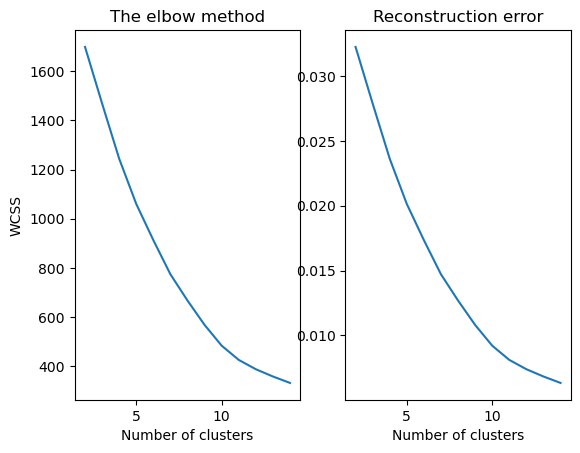

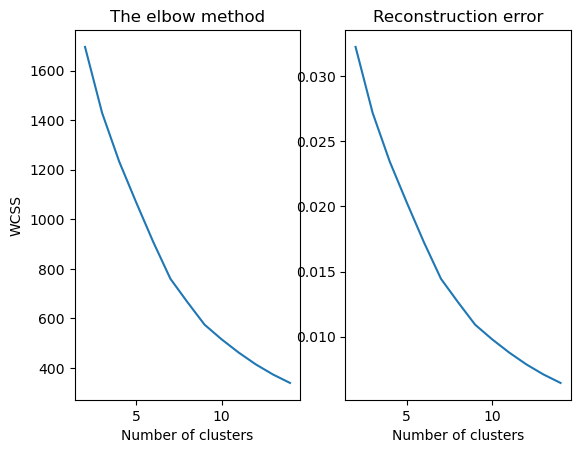

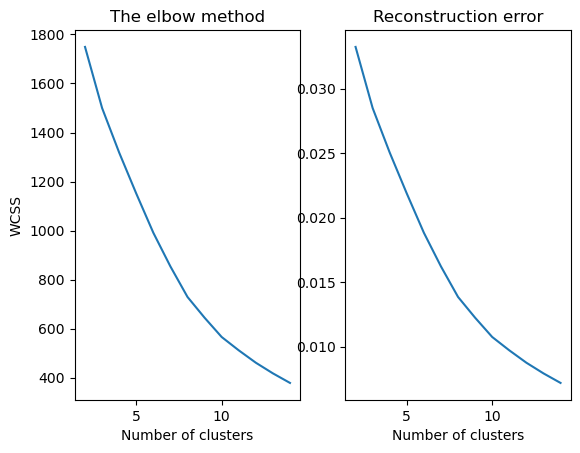

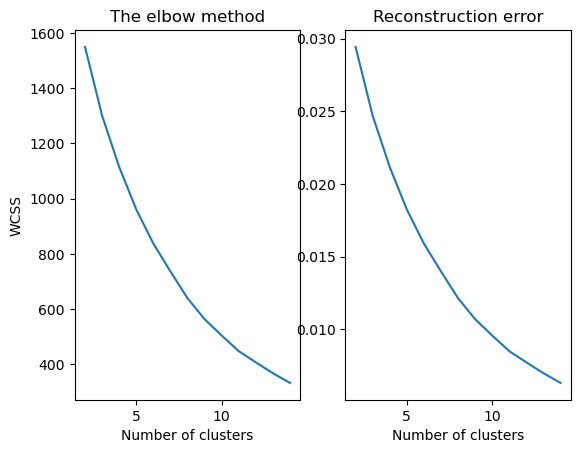

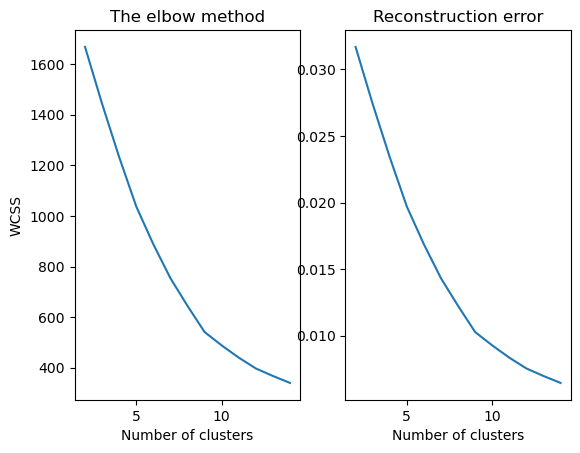

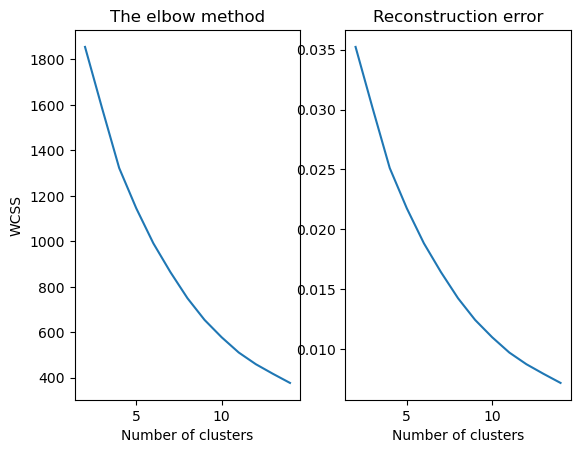

In [12]:
for s_id, Cvec in enumerate(Cvec_list):
    knee_method(Cvec = Cvec,  K_min = 2, K_max =15, plot= True);

## Apply K means on the concatenation of all subjects

In [13]:
Cvec_concatenated = np.concatenate(Cvec_list , axis =1)

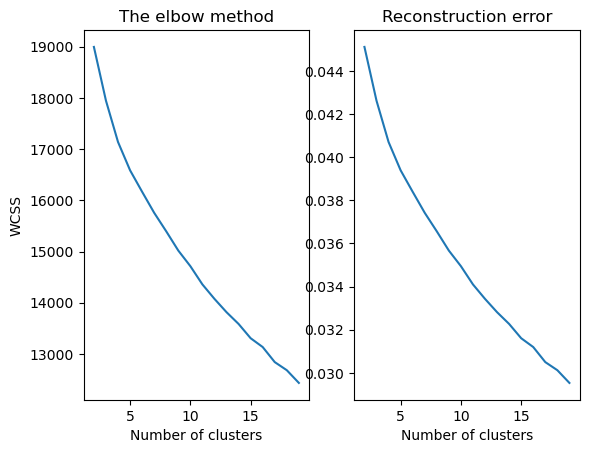

In [14]:
knee_method(Cvec = Cvec_concatenated,  K_min = 2, K_max =20, plot= True);

### Plot states change on top of estimated C and A and C_kmeans

In [96]:
plt.rcParams.update({'font.size': 20})

################################################################
subject  0


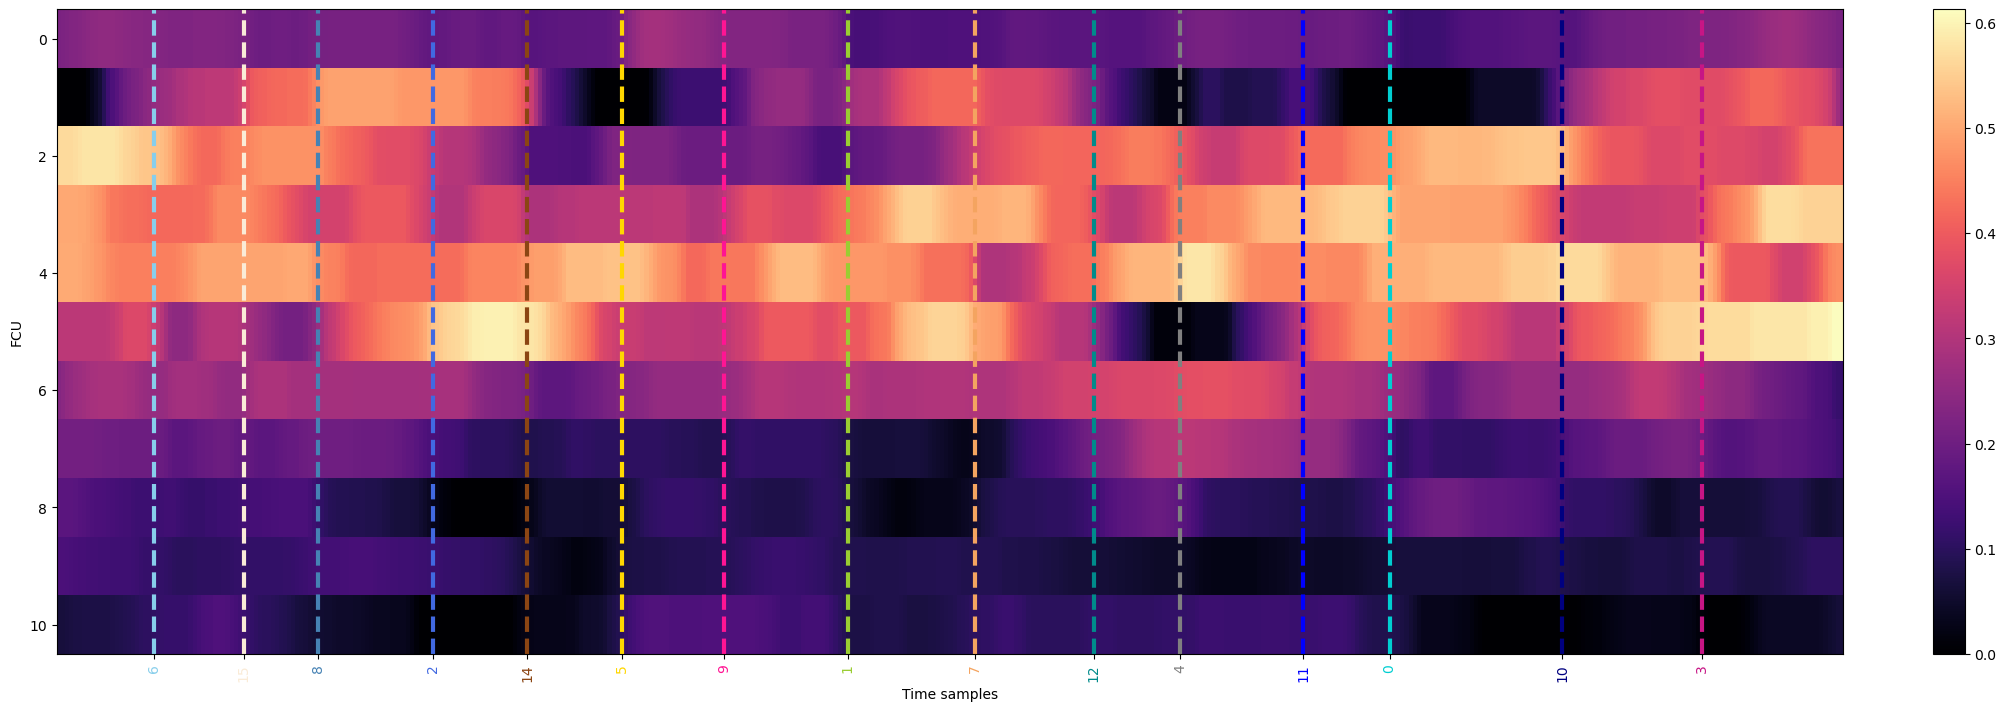

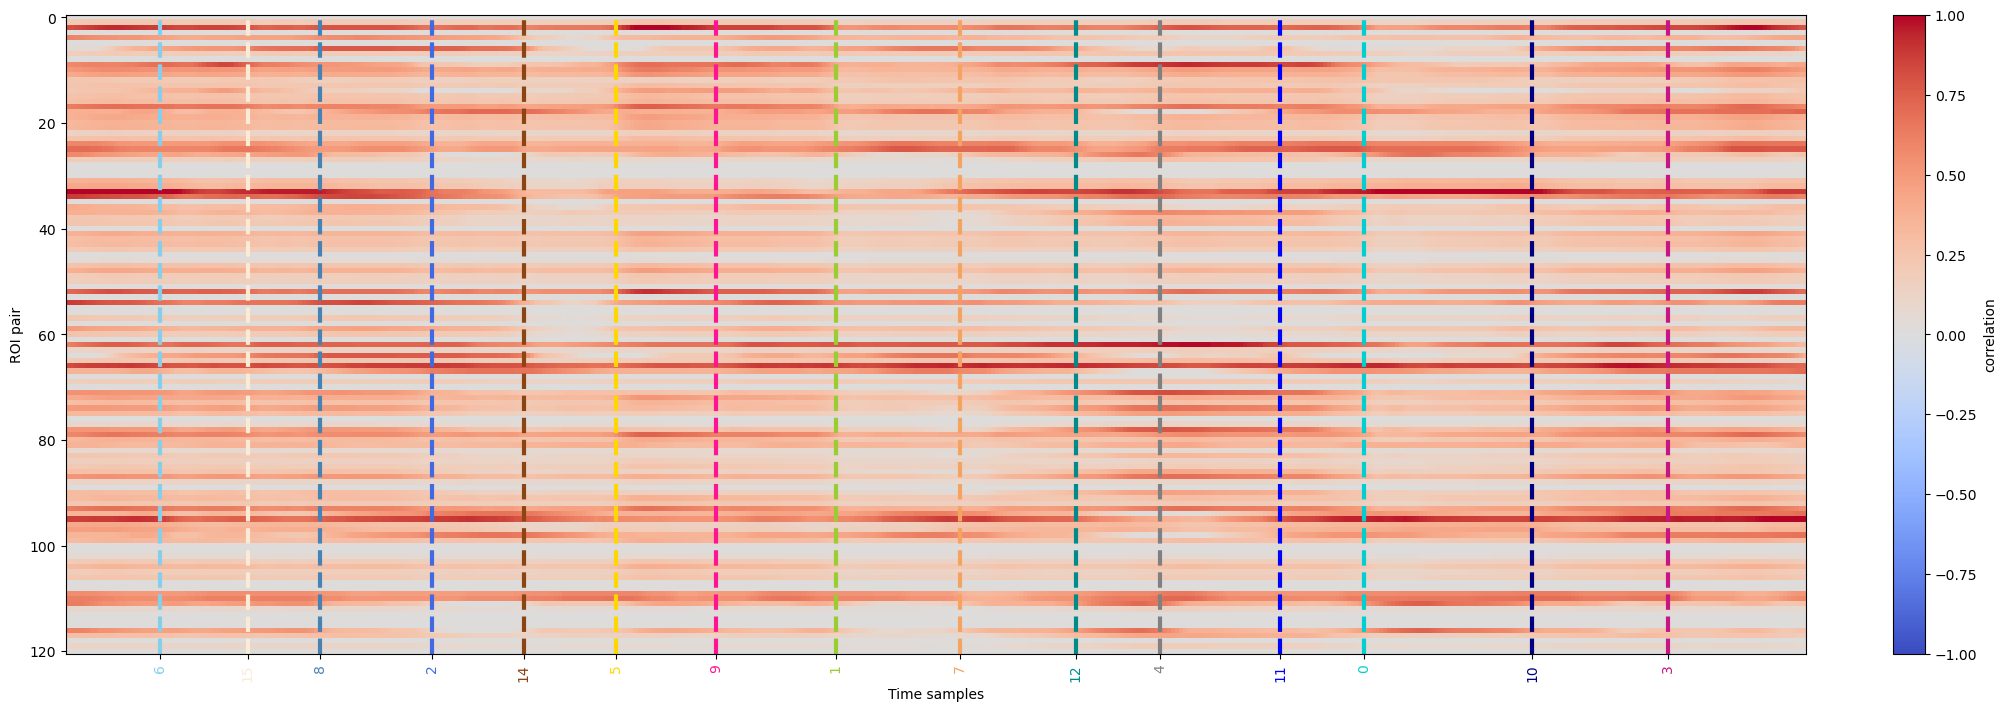

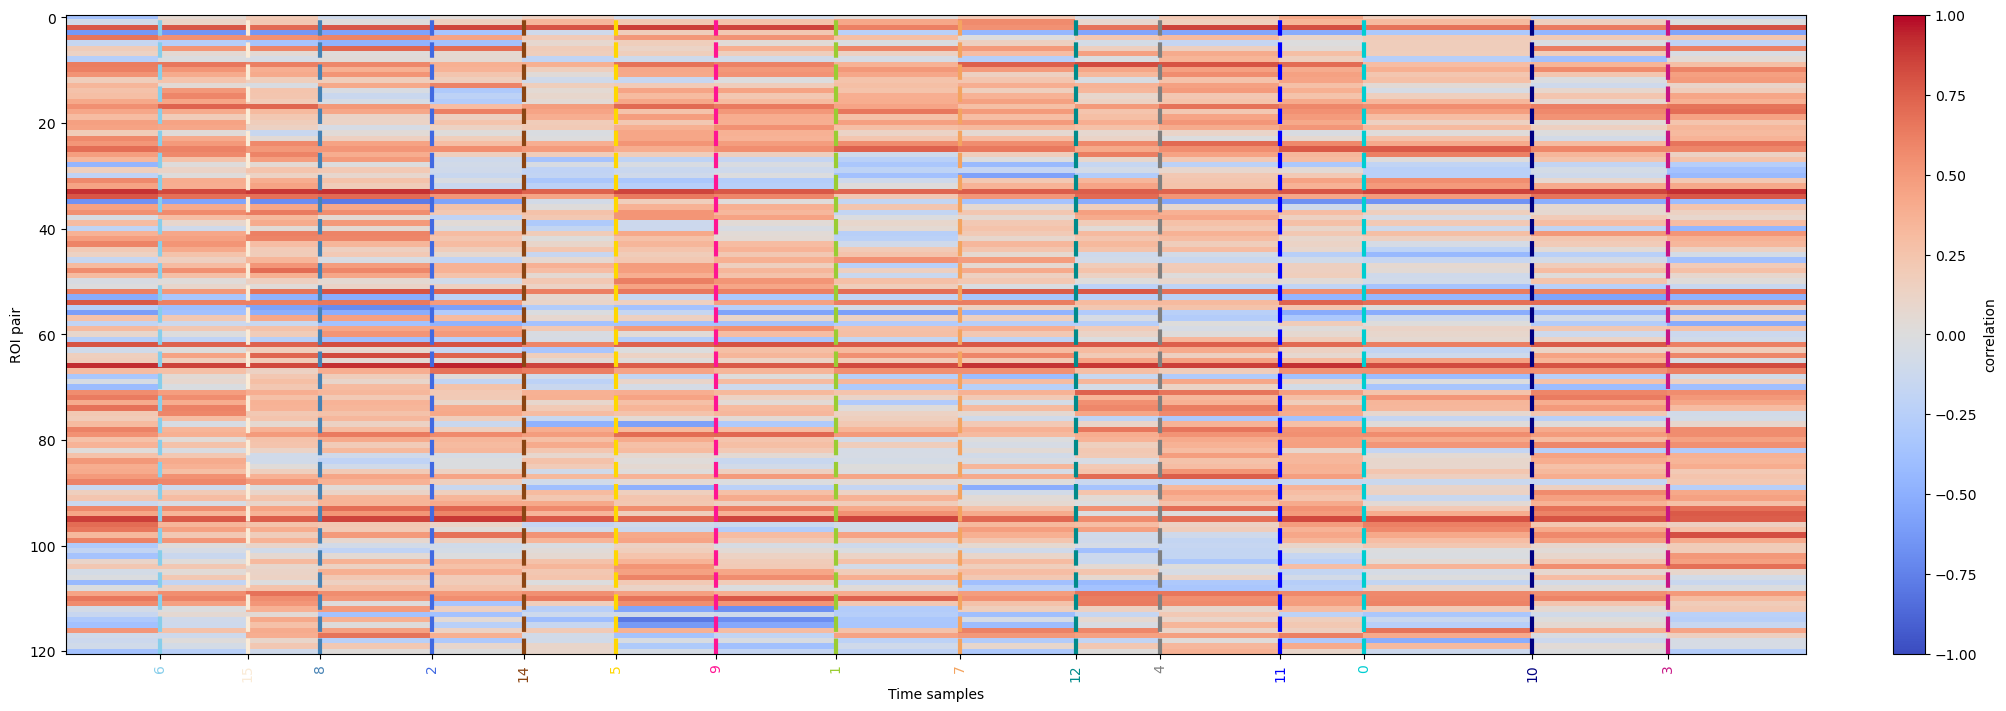

################################################################
subject  1


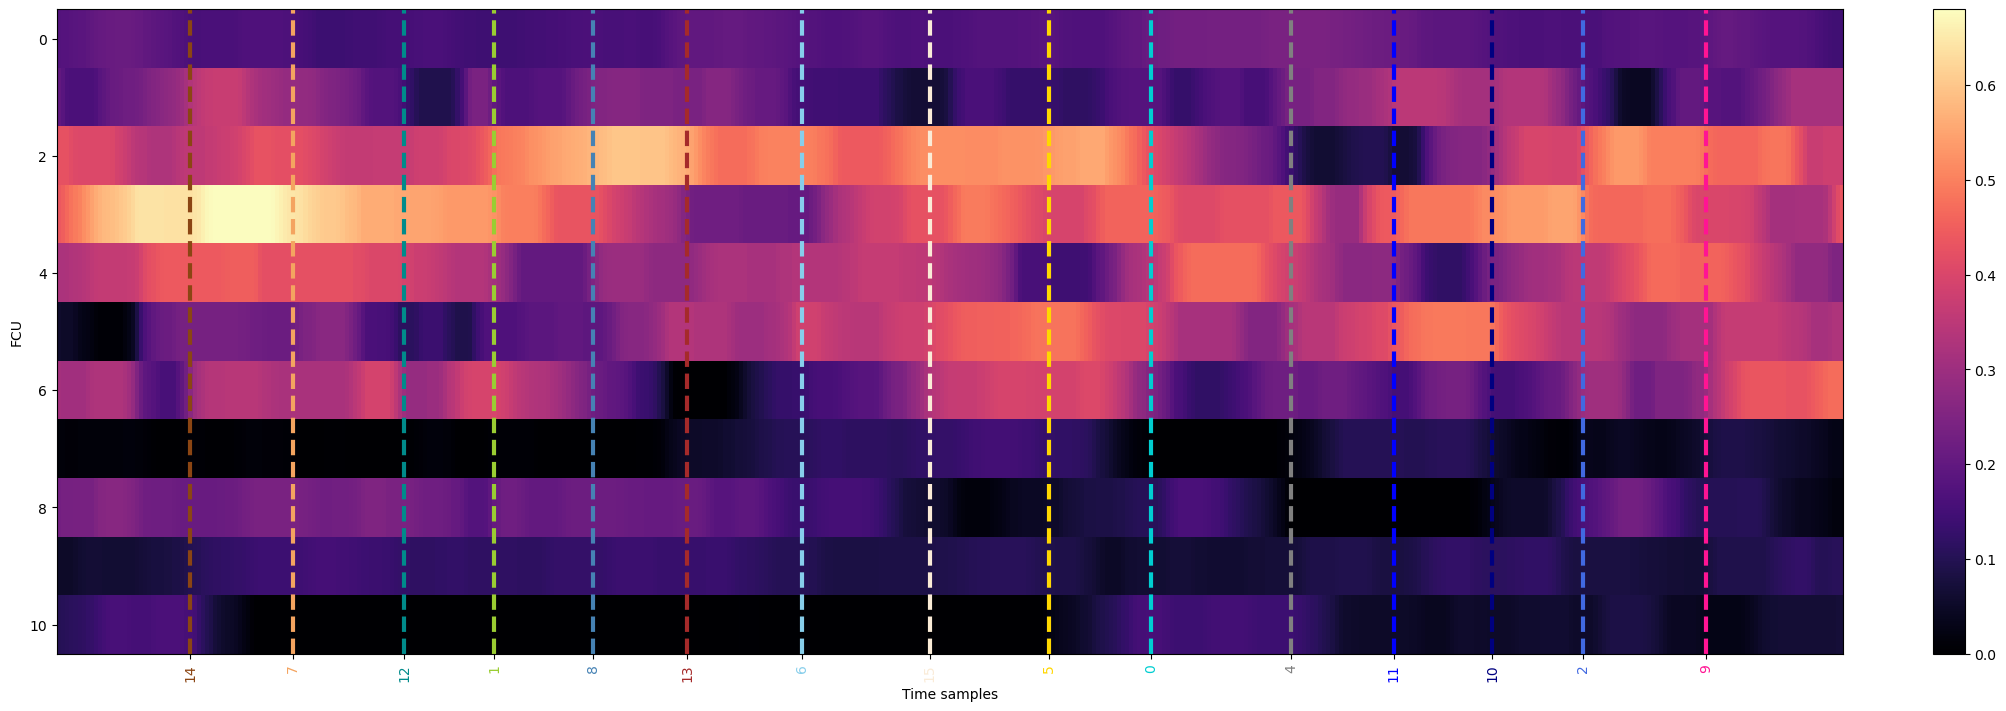

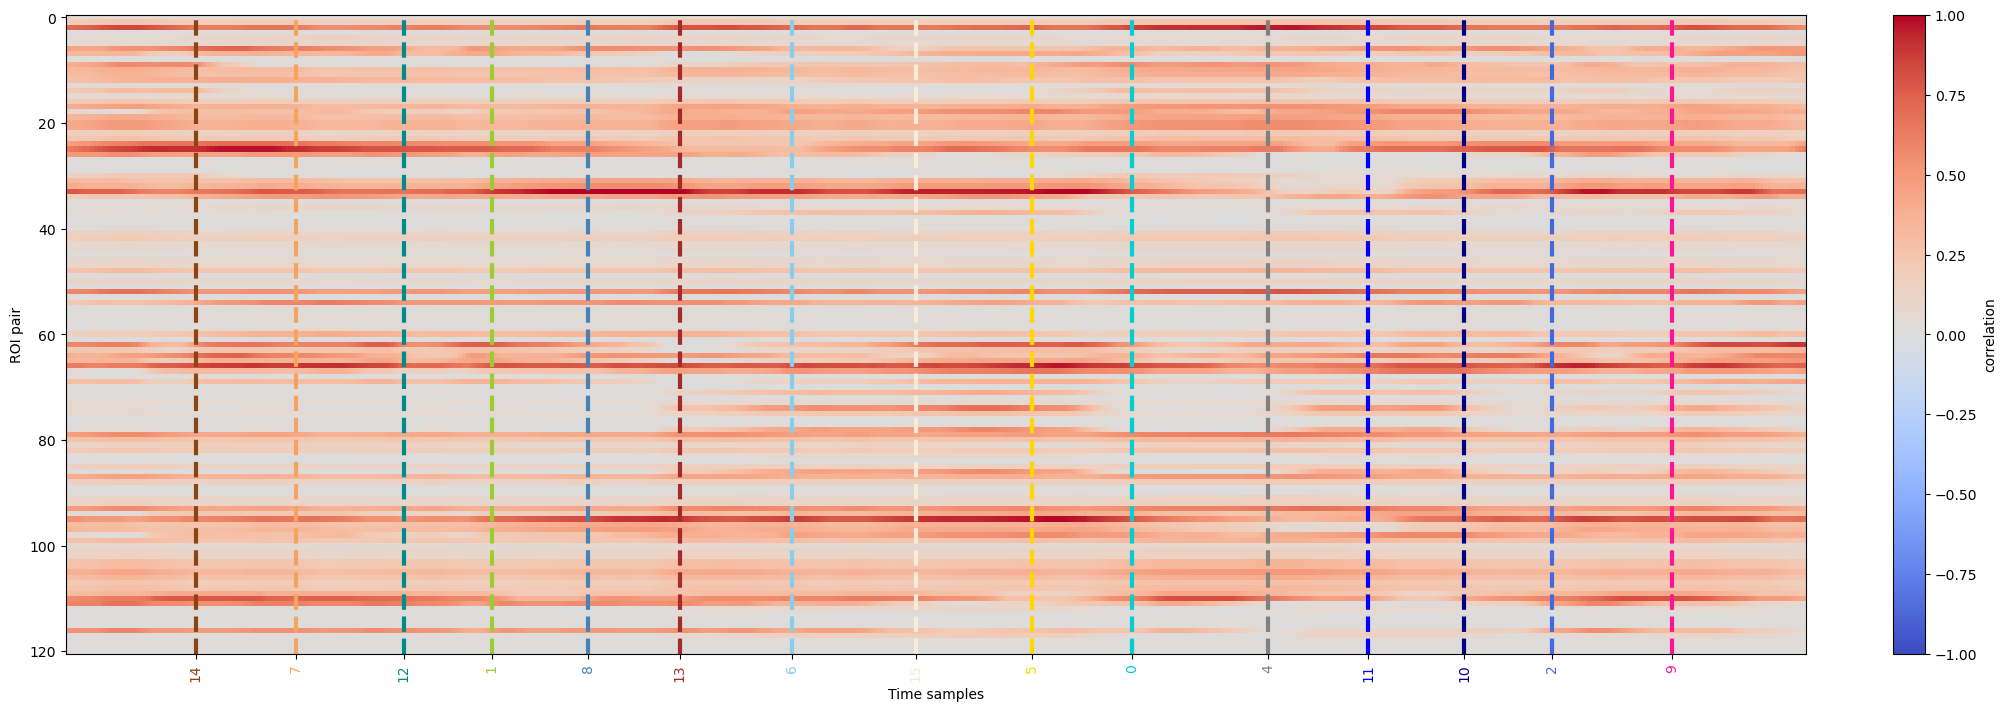

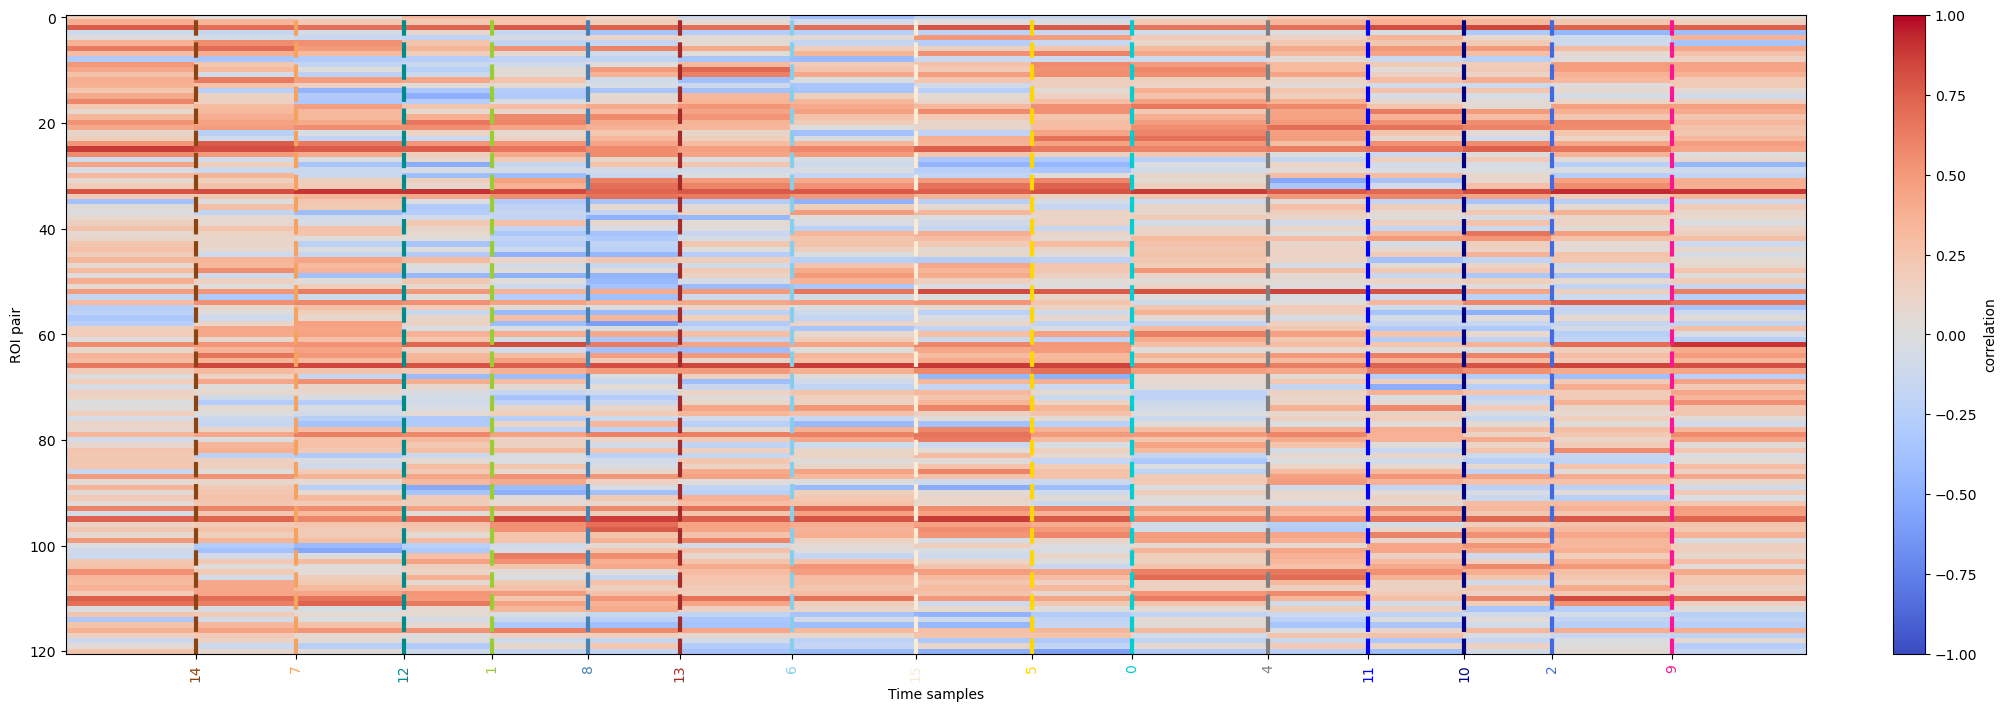

################################################################
subject  2


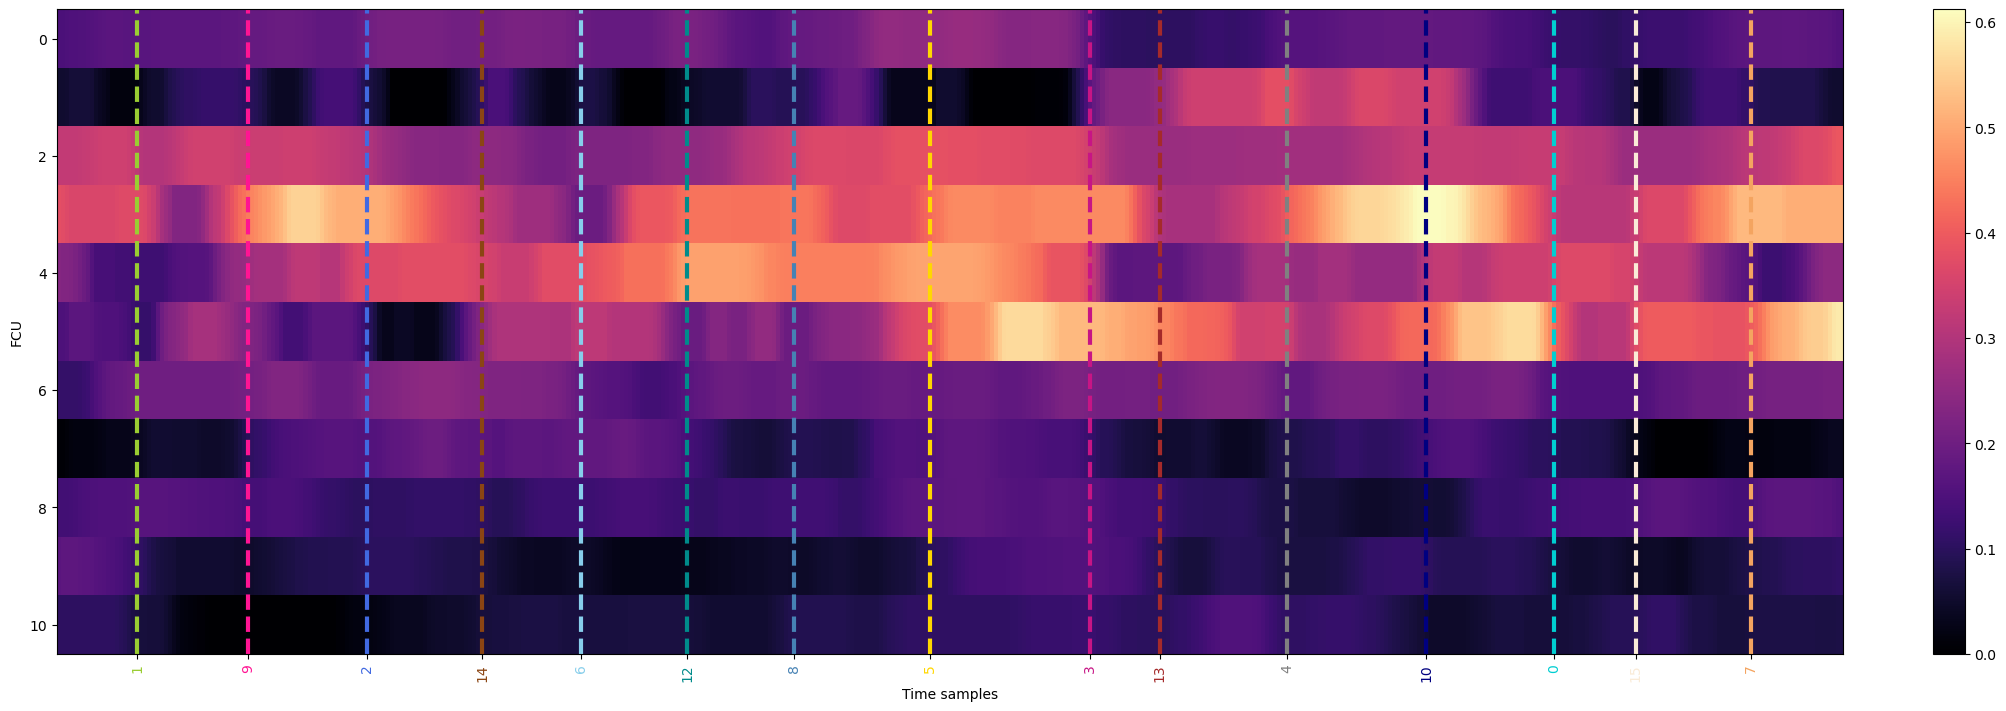

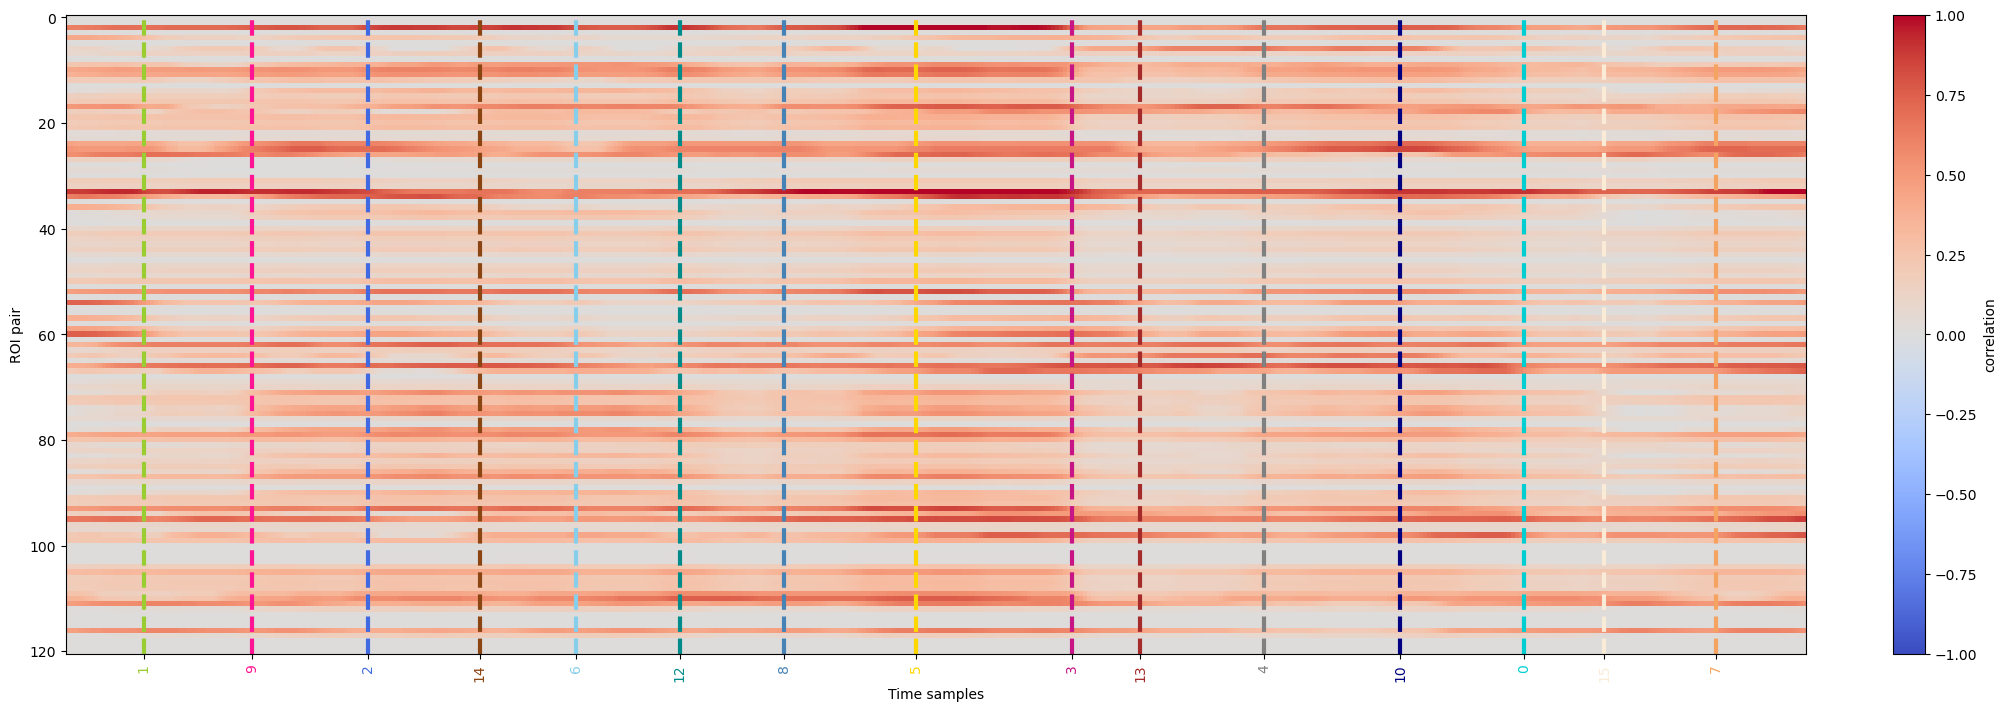

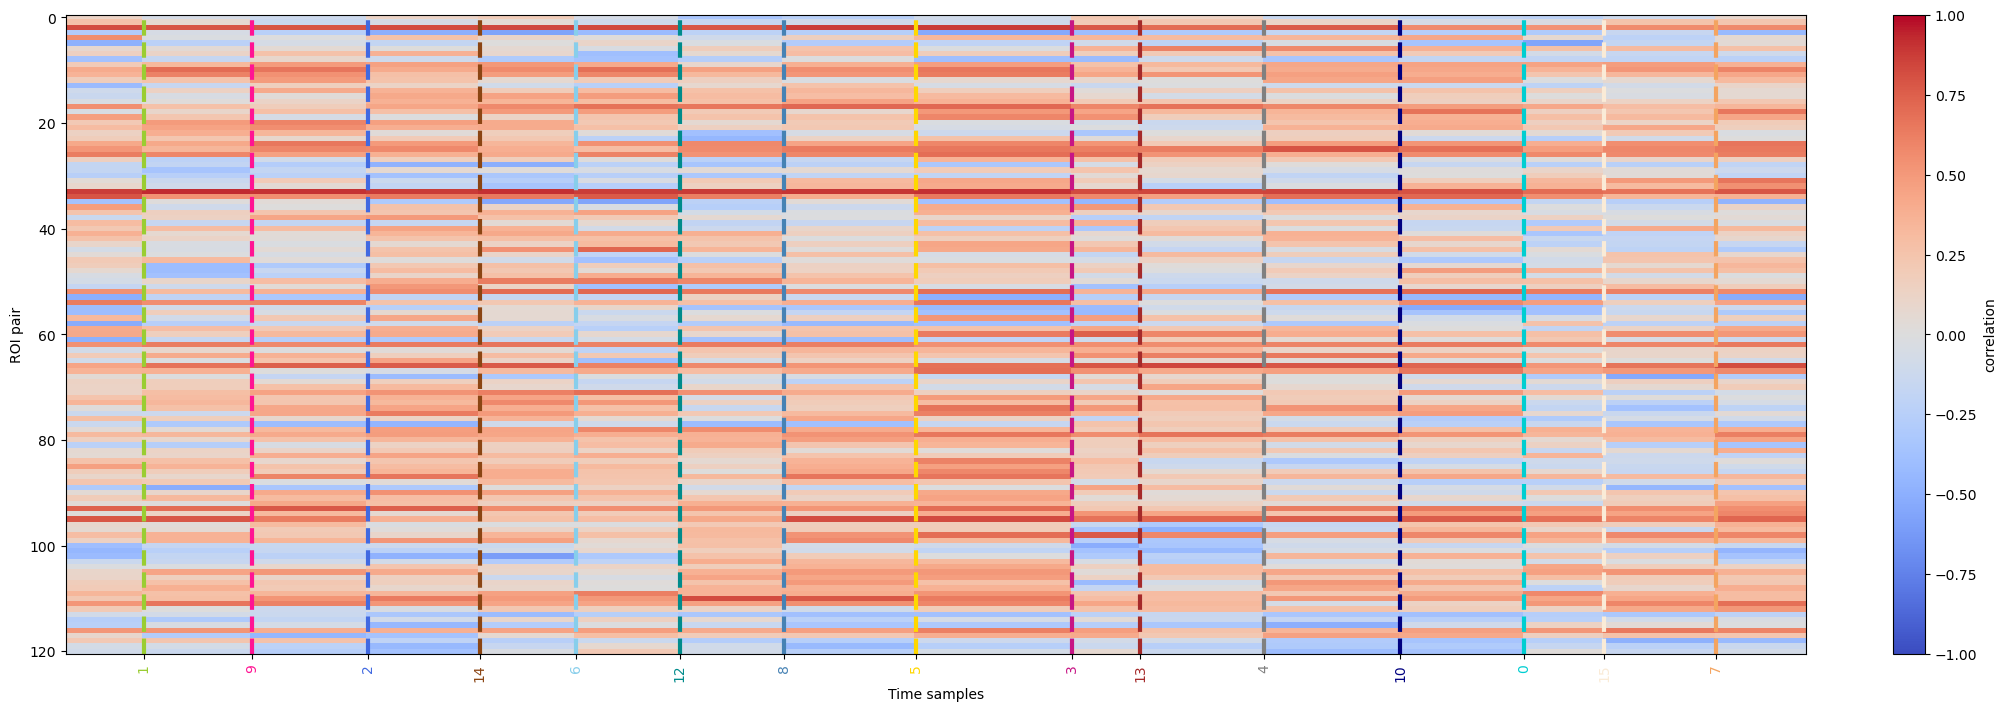

################################################################
subject  3


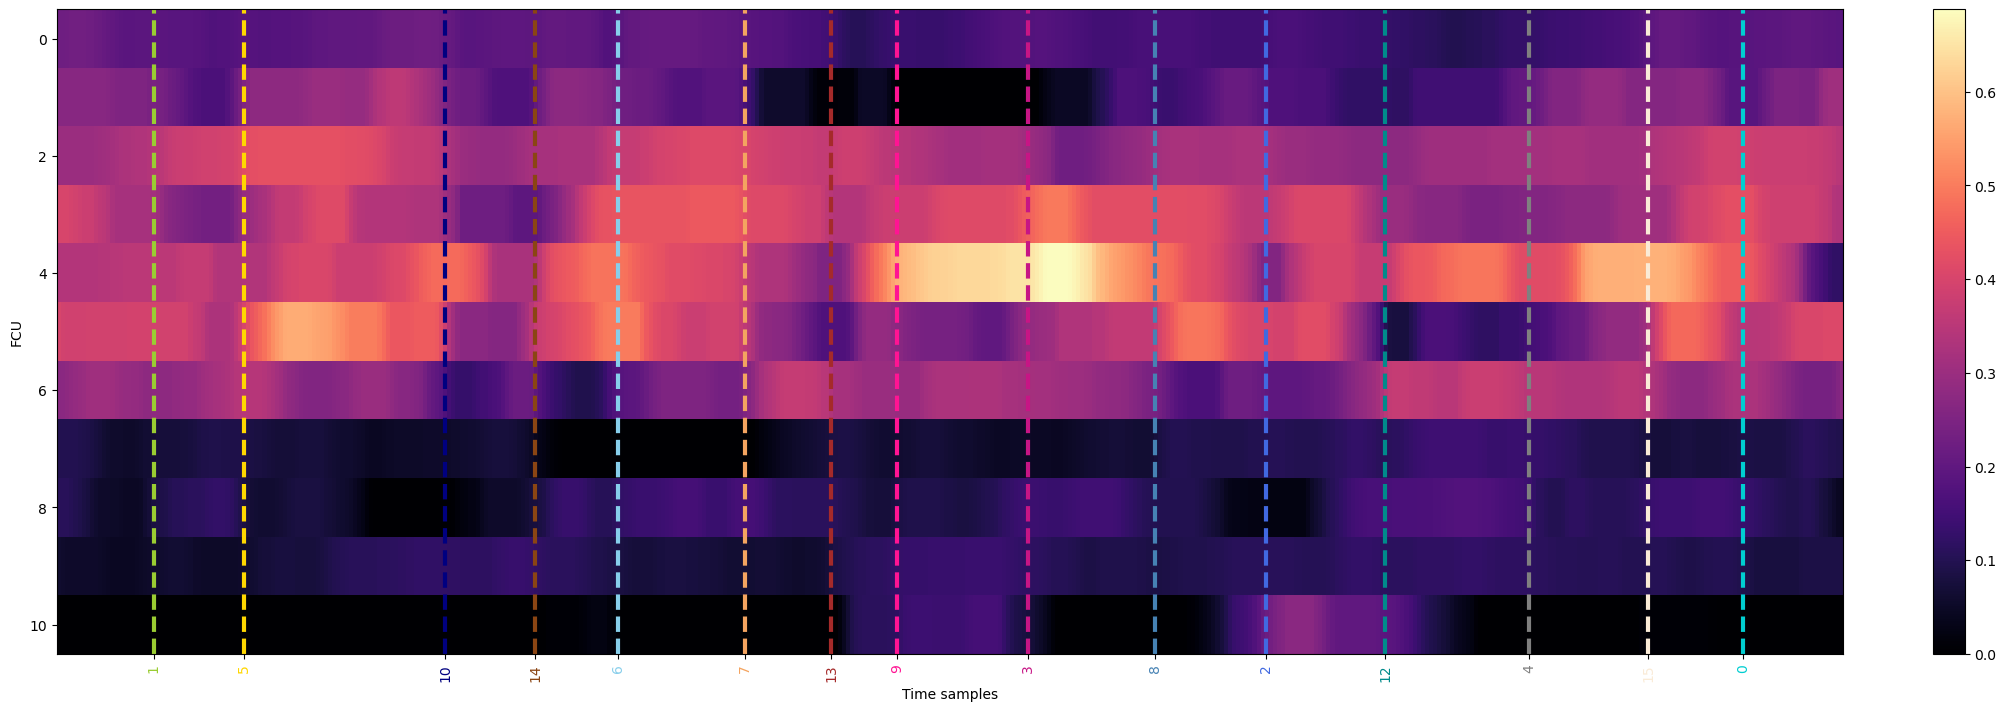

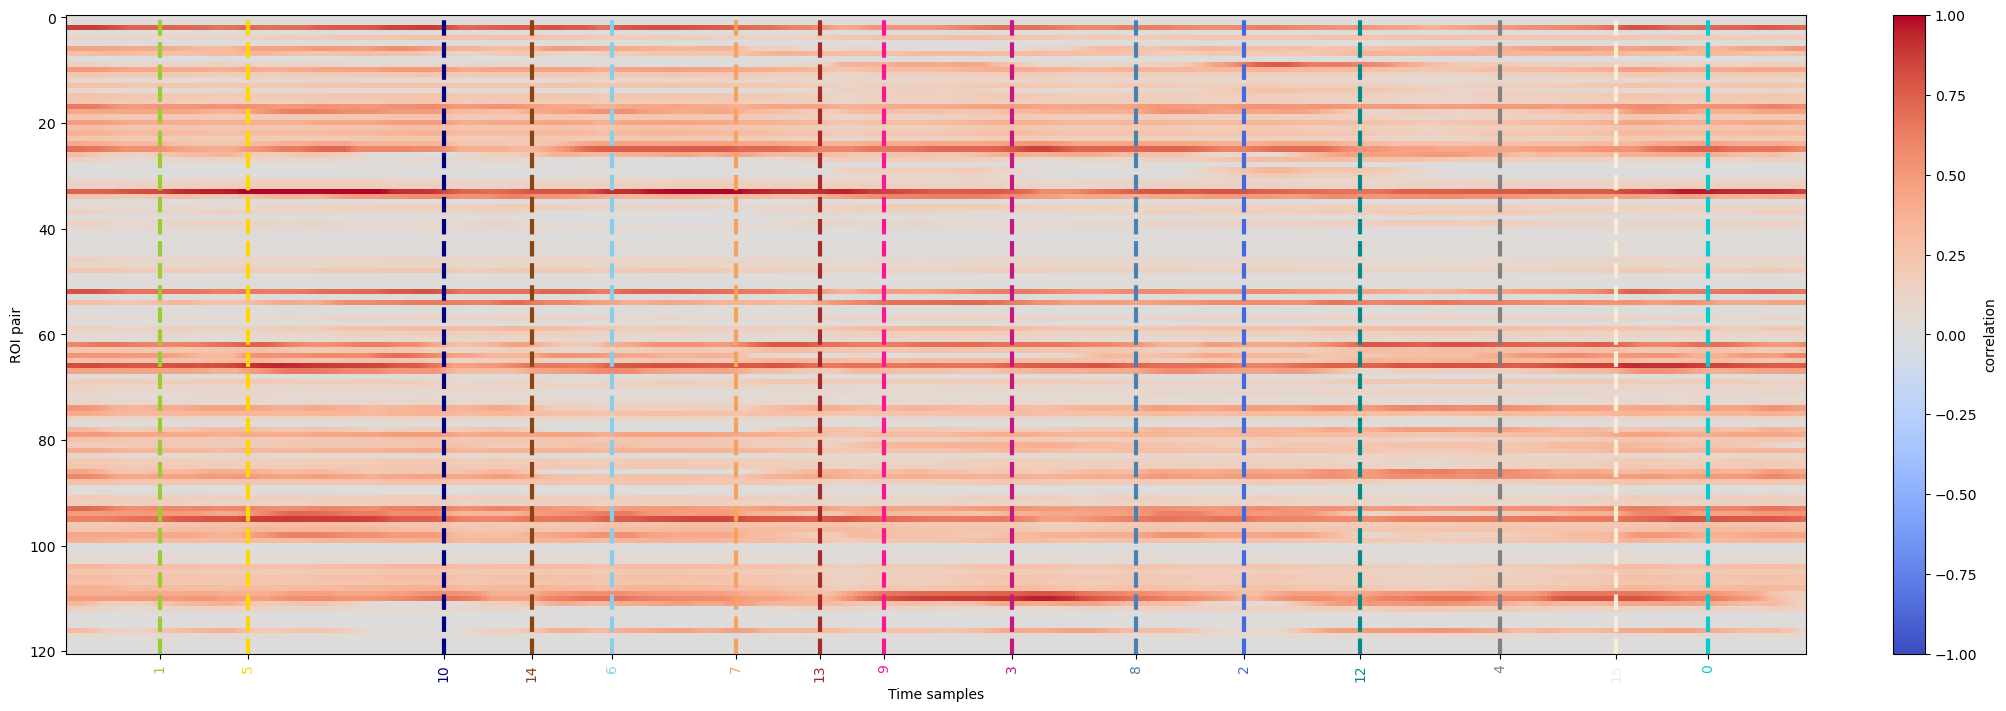

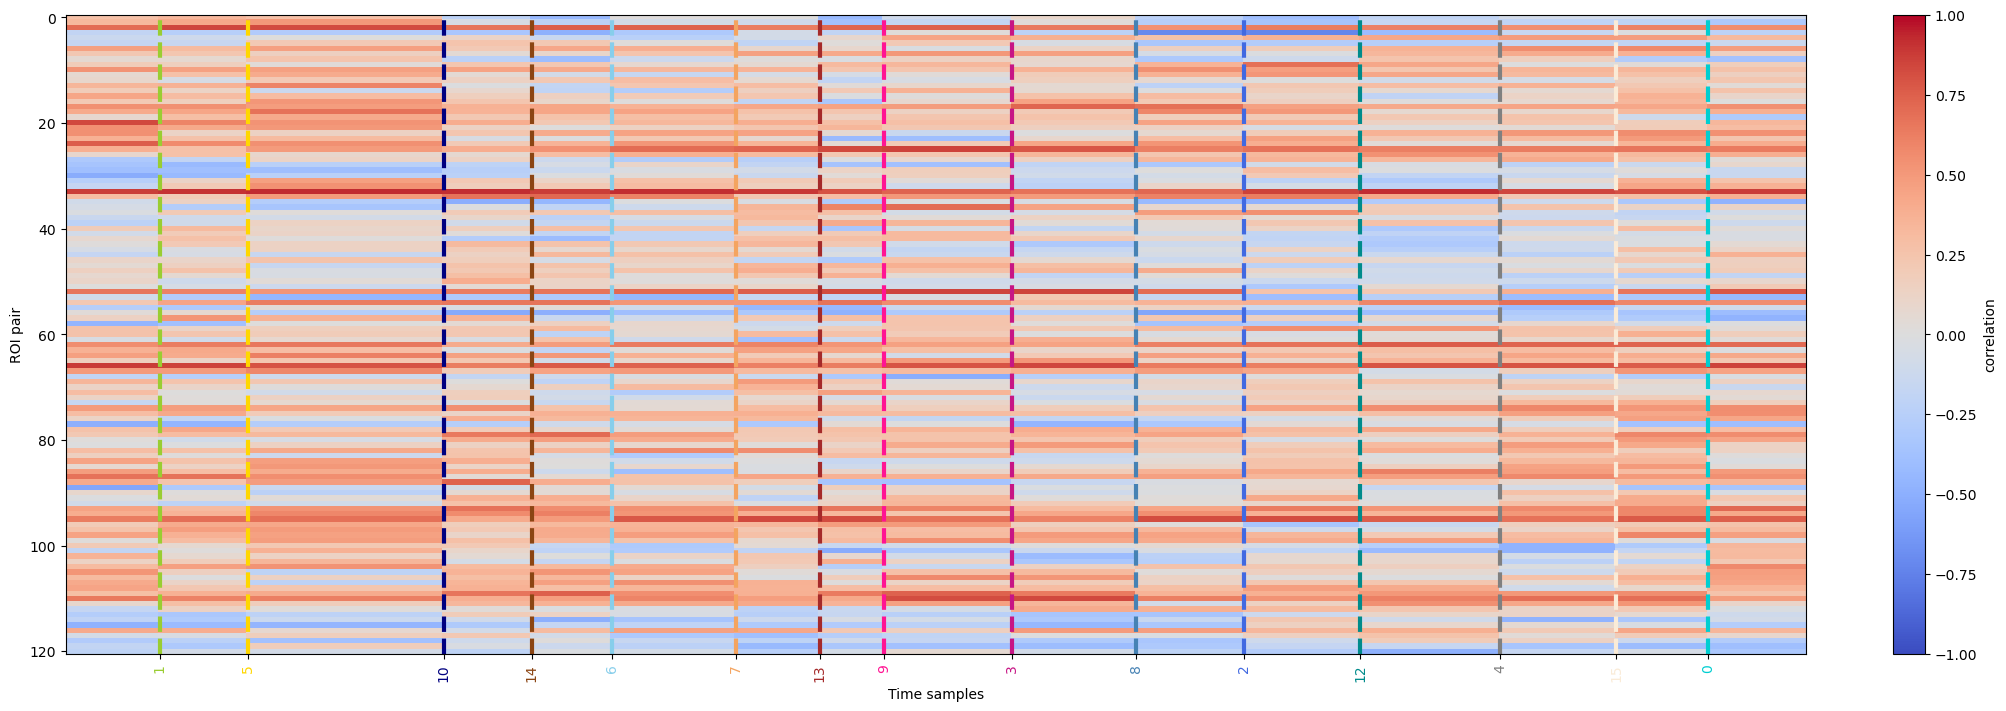

################################################################
subject  4


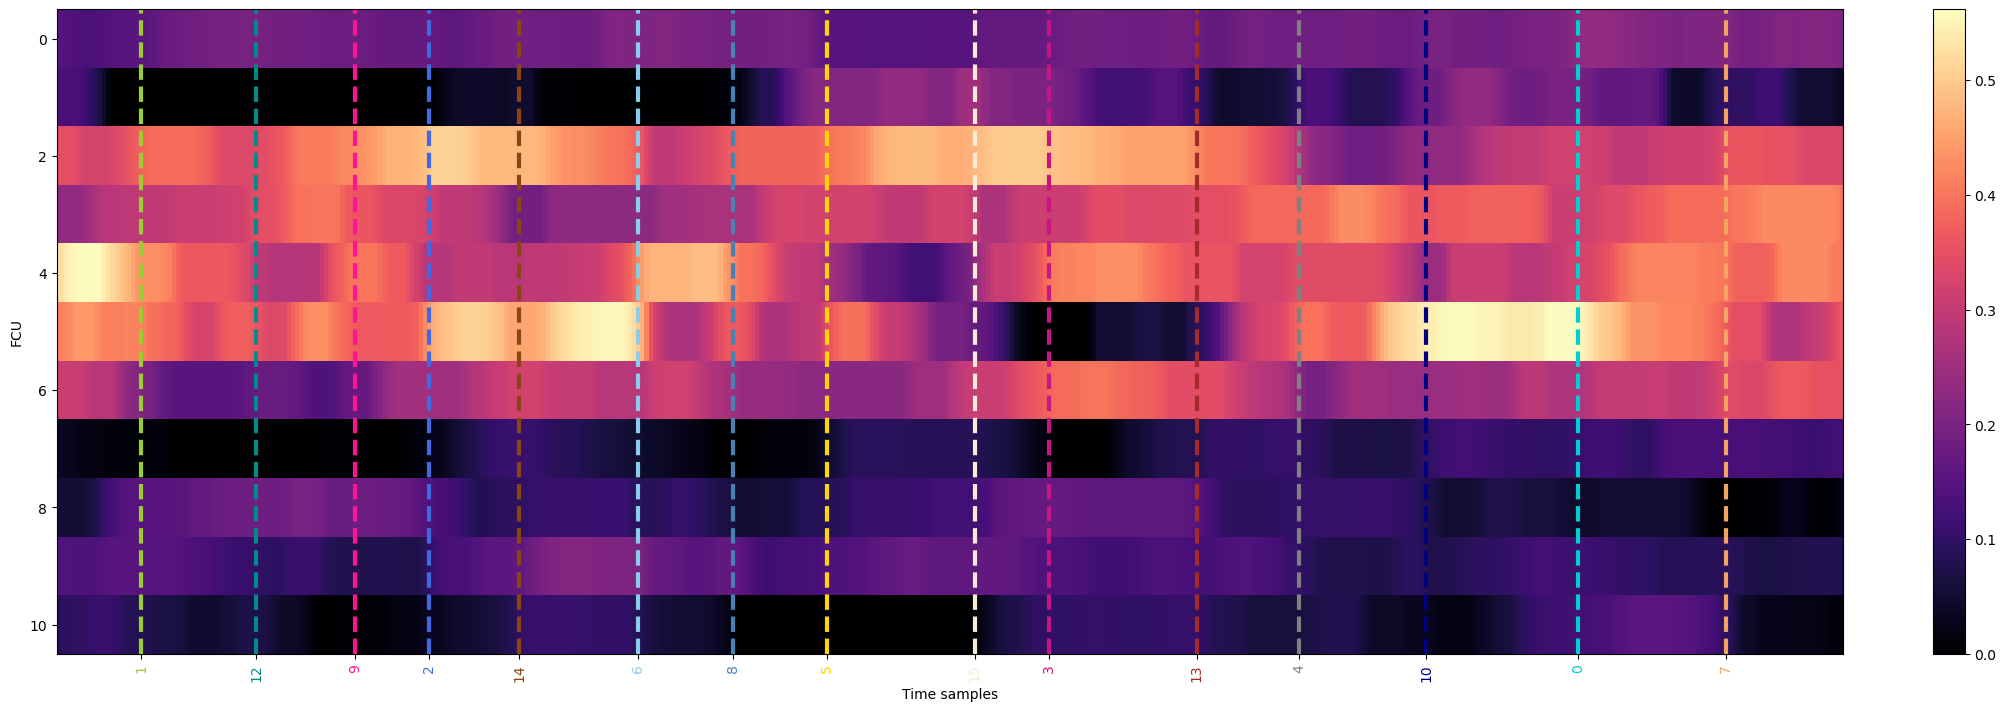

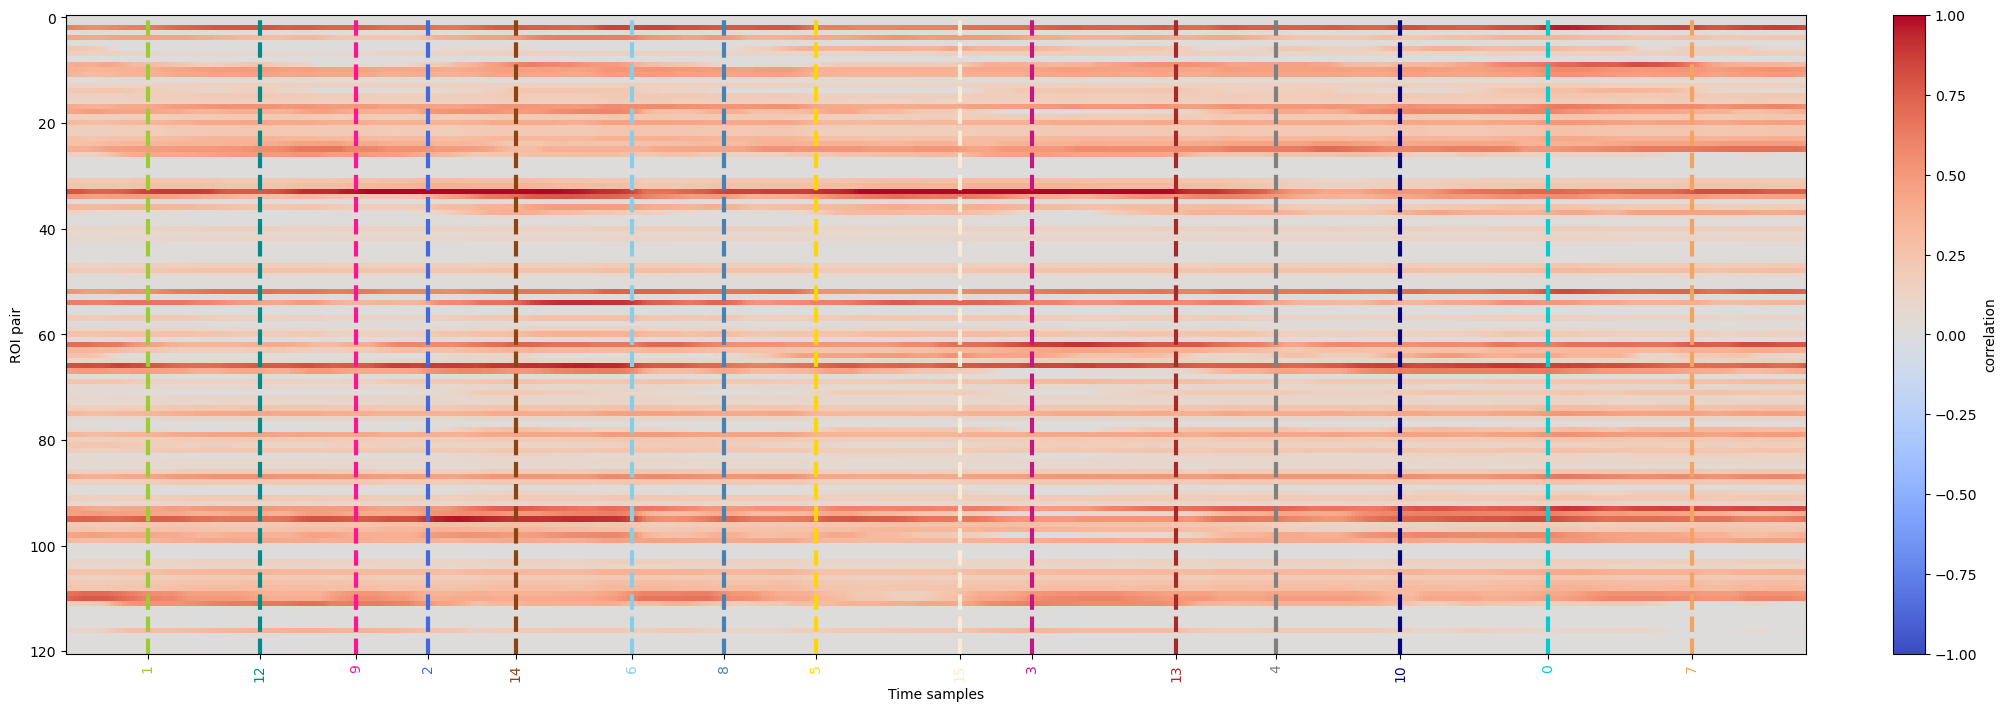

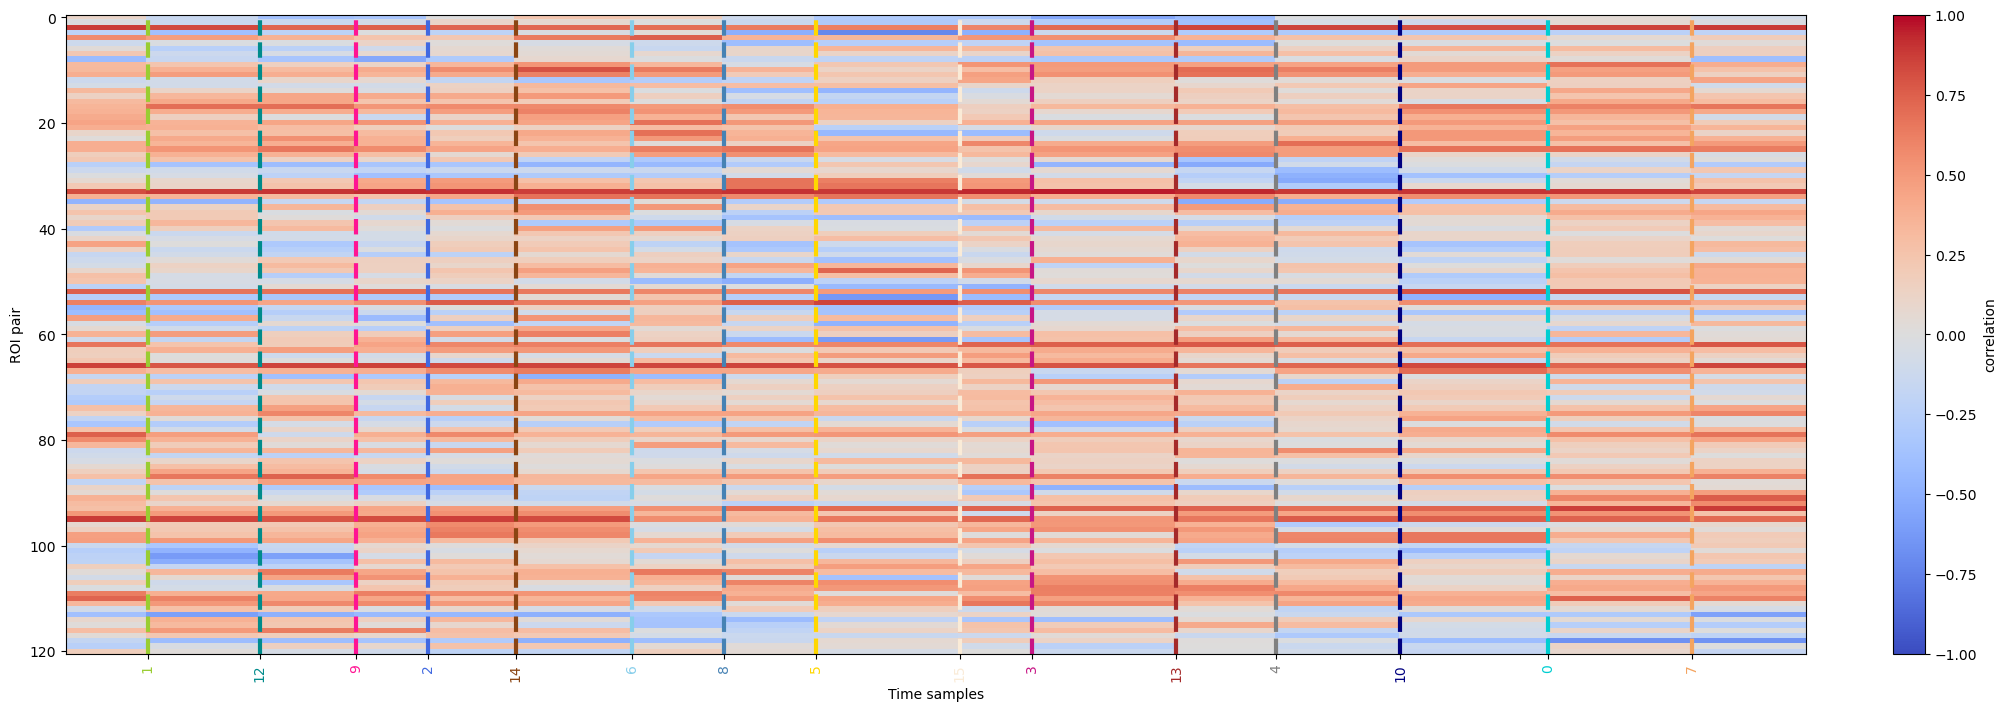

################################################################
subject  5


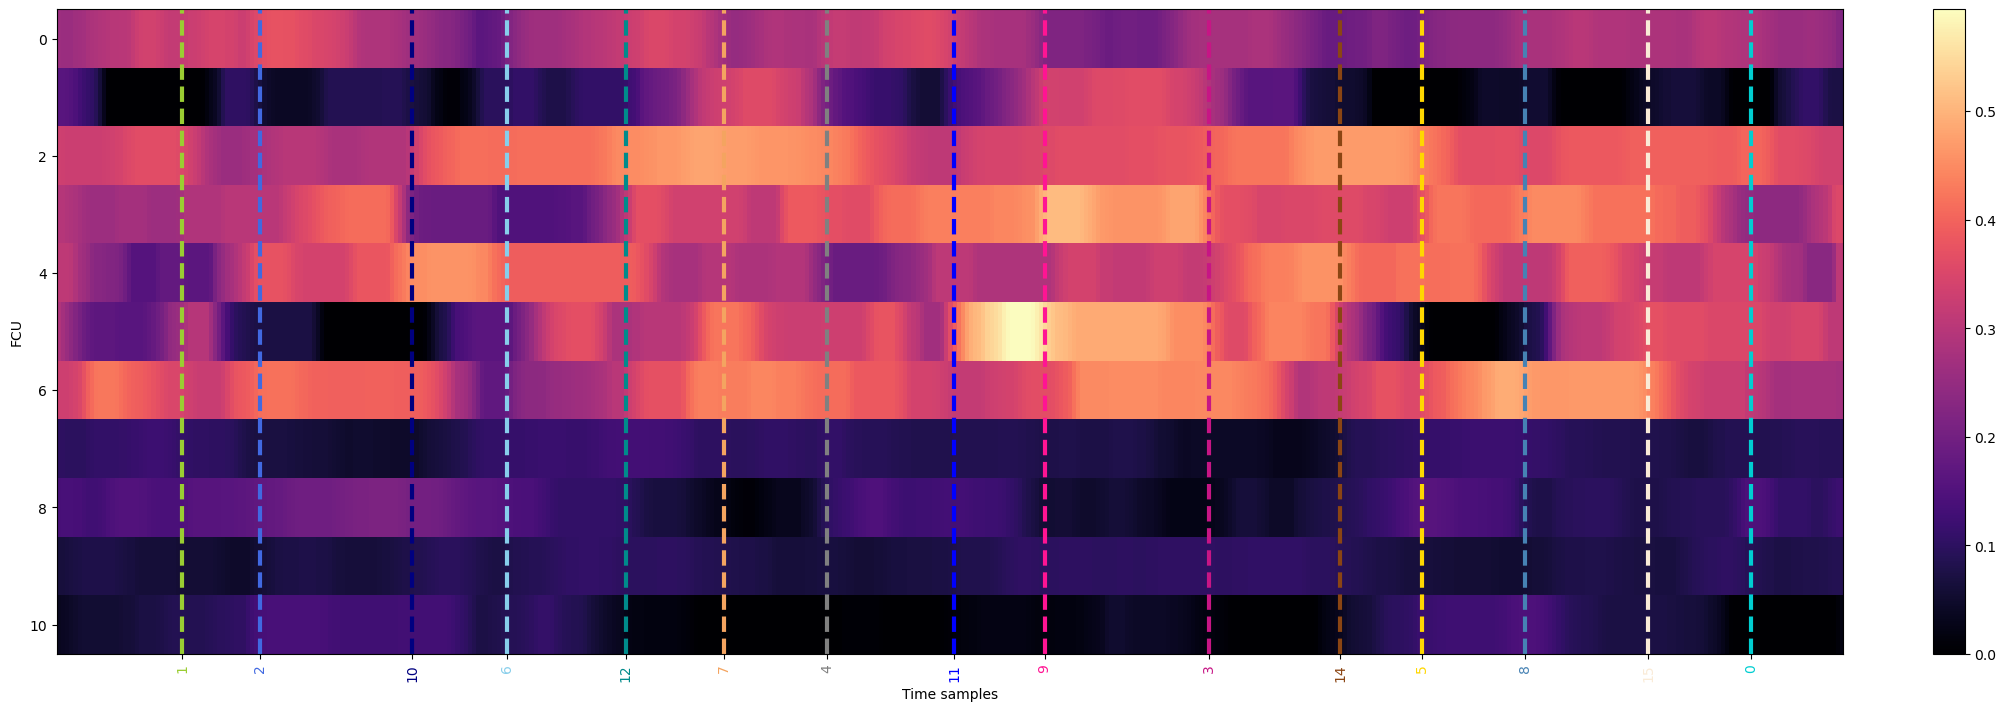

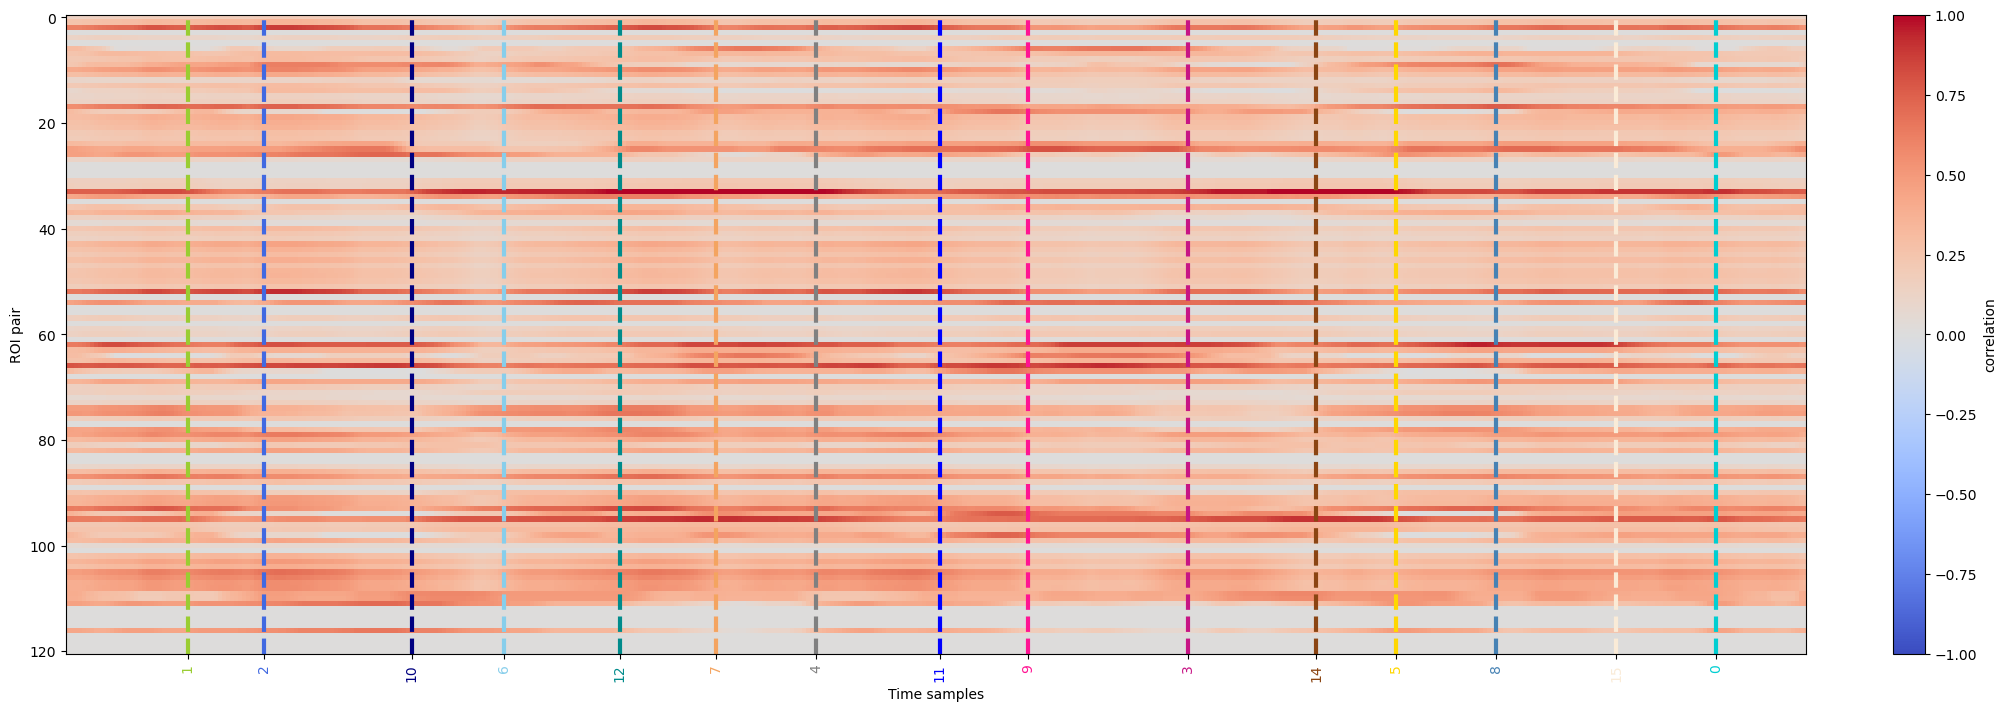

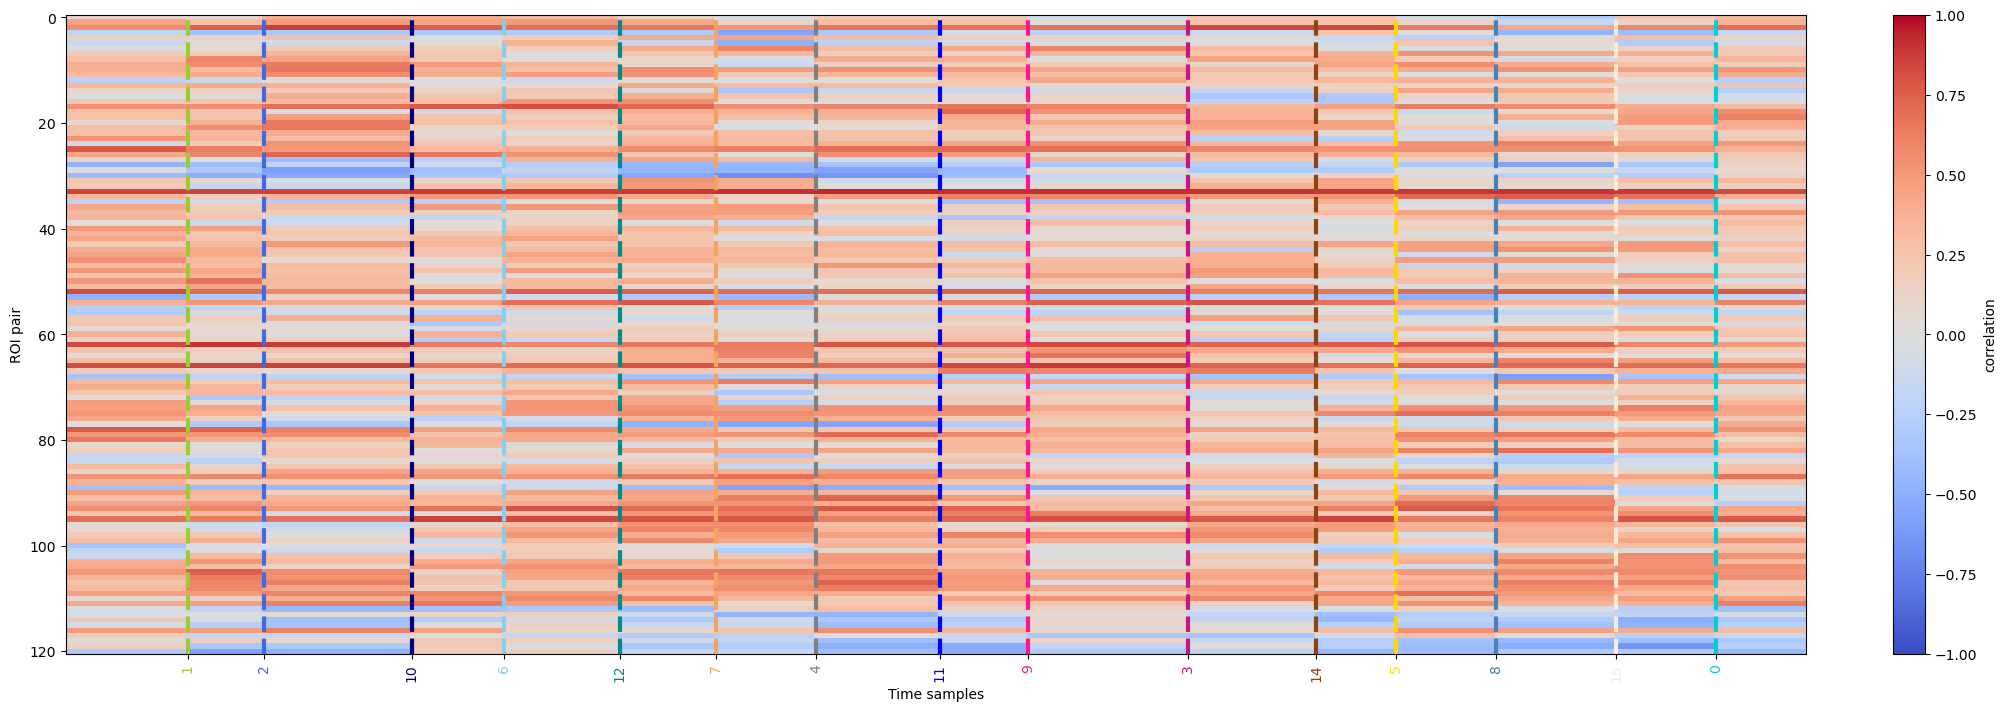

################################################################
subject  6


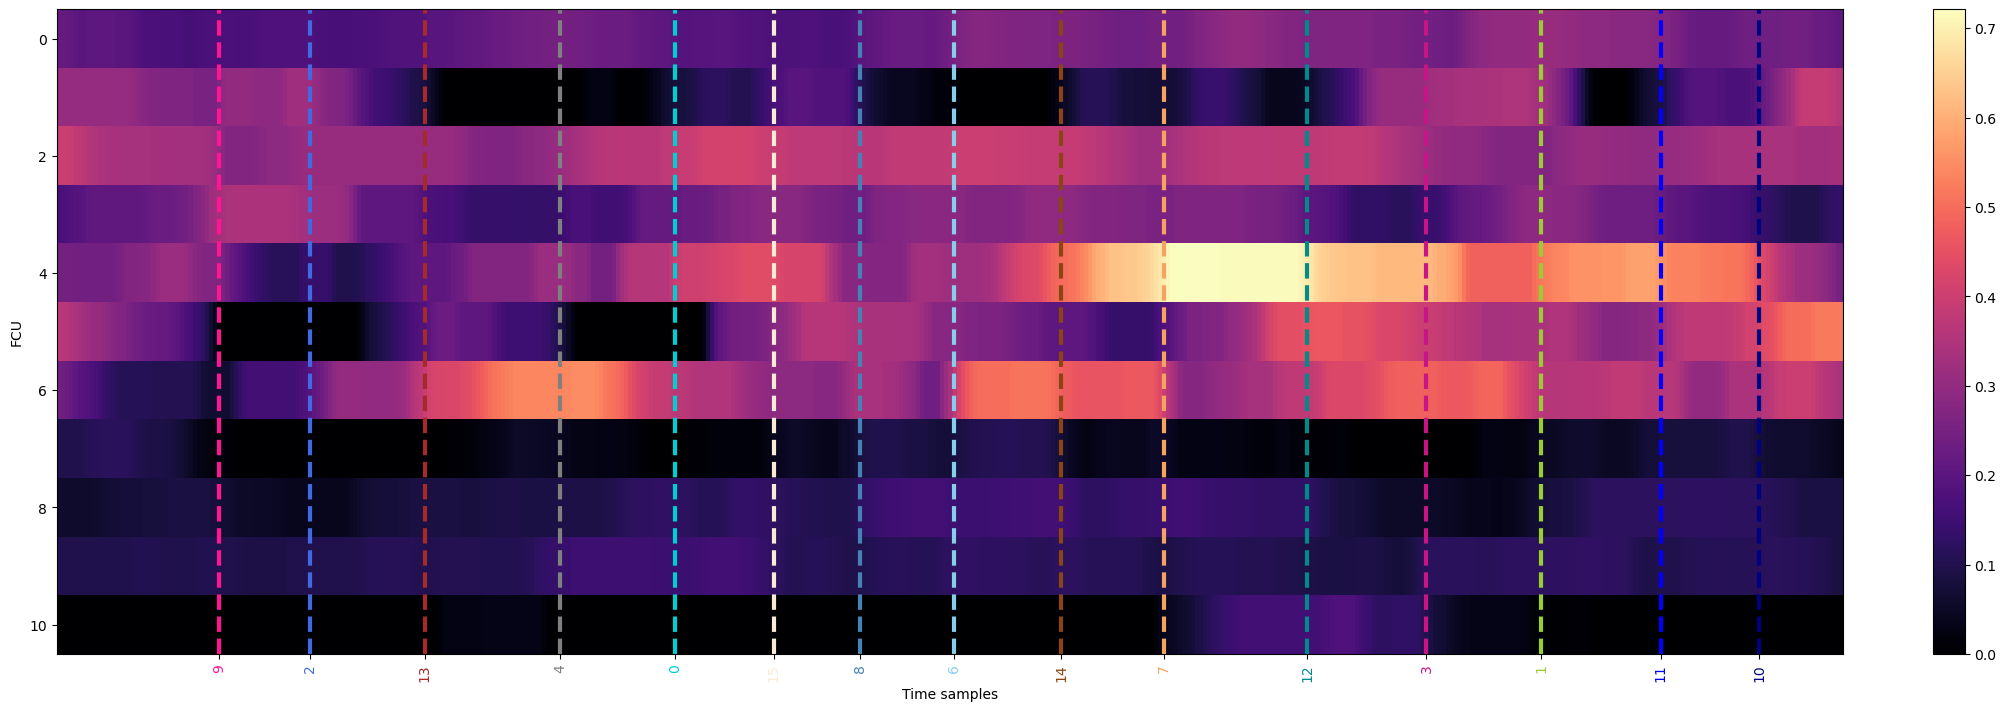

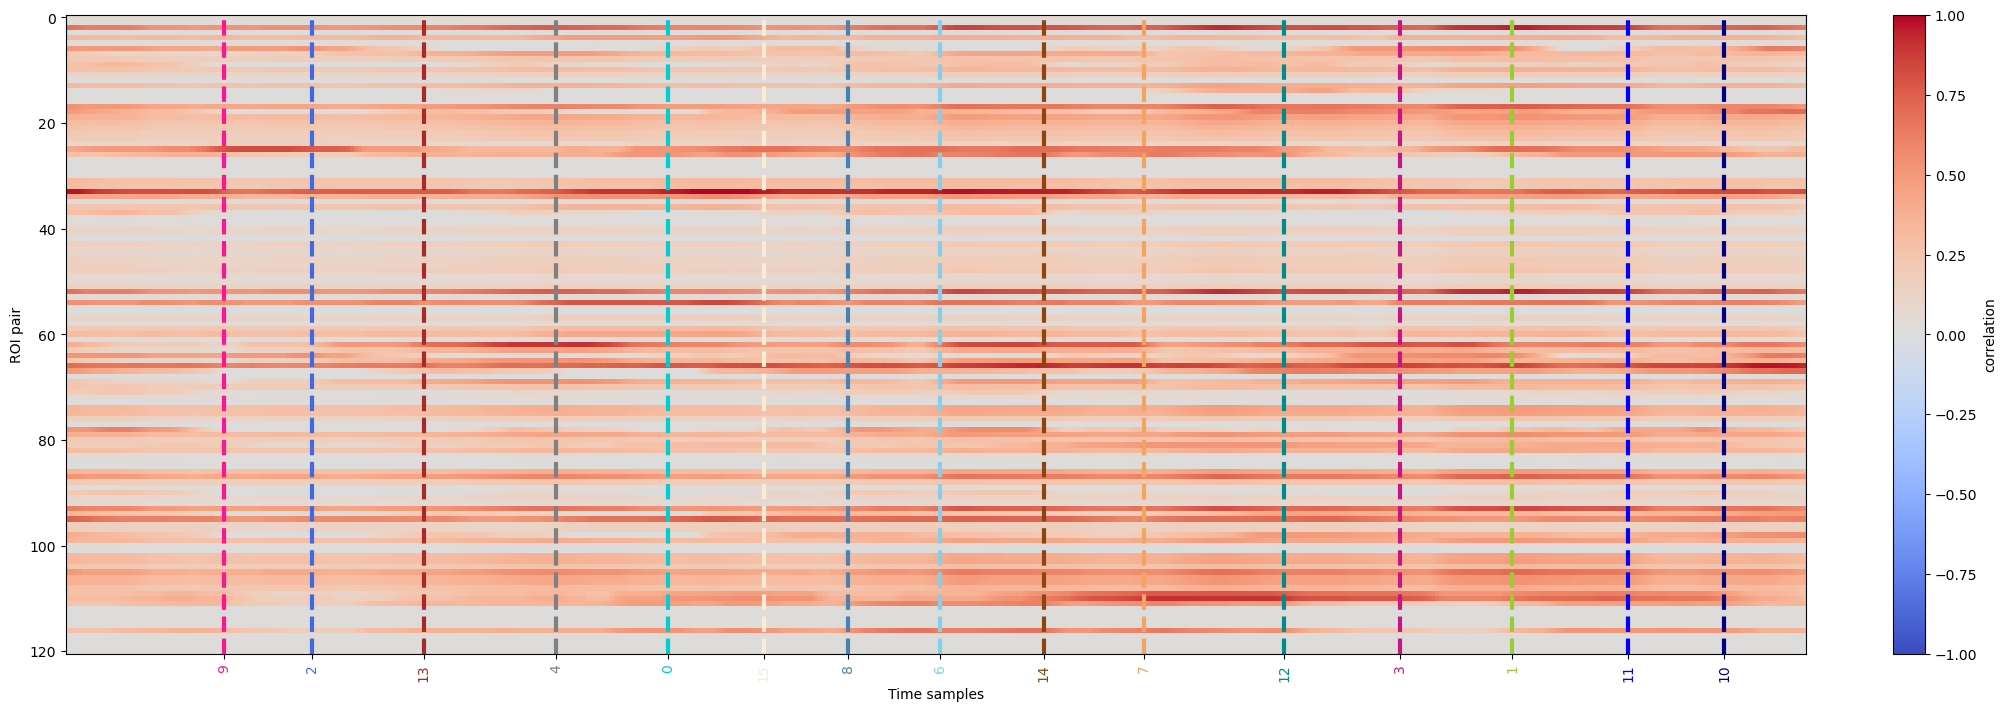

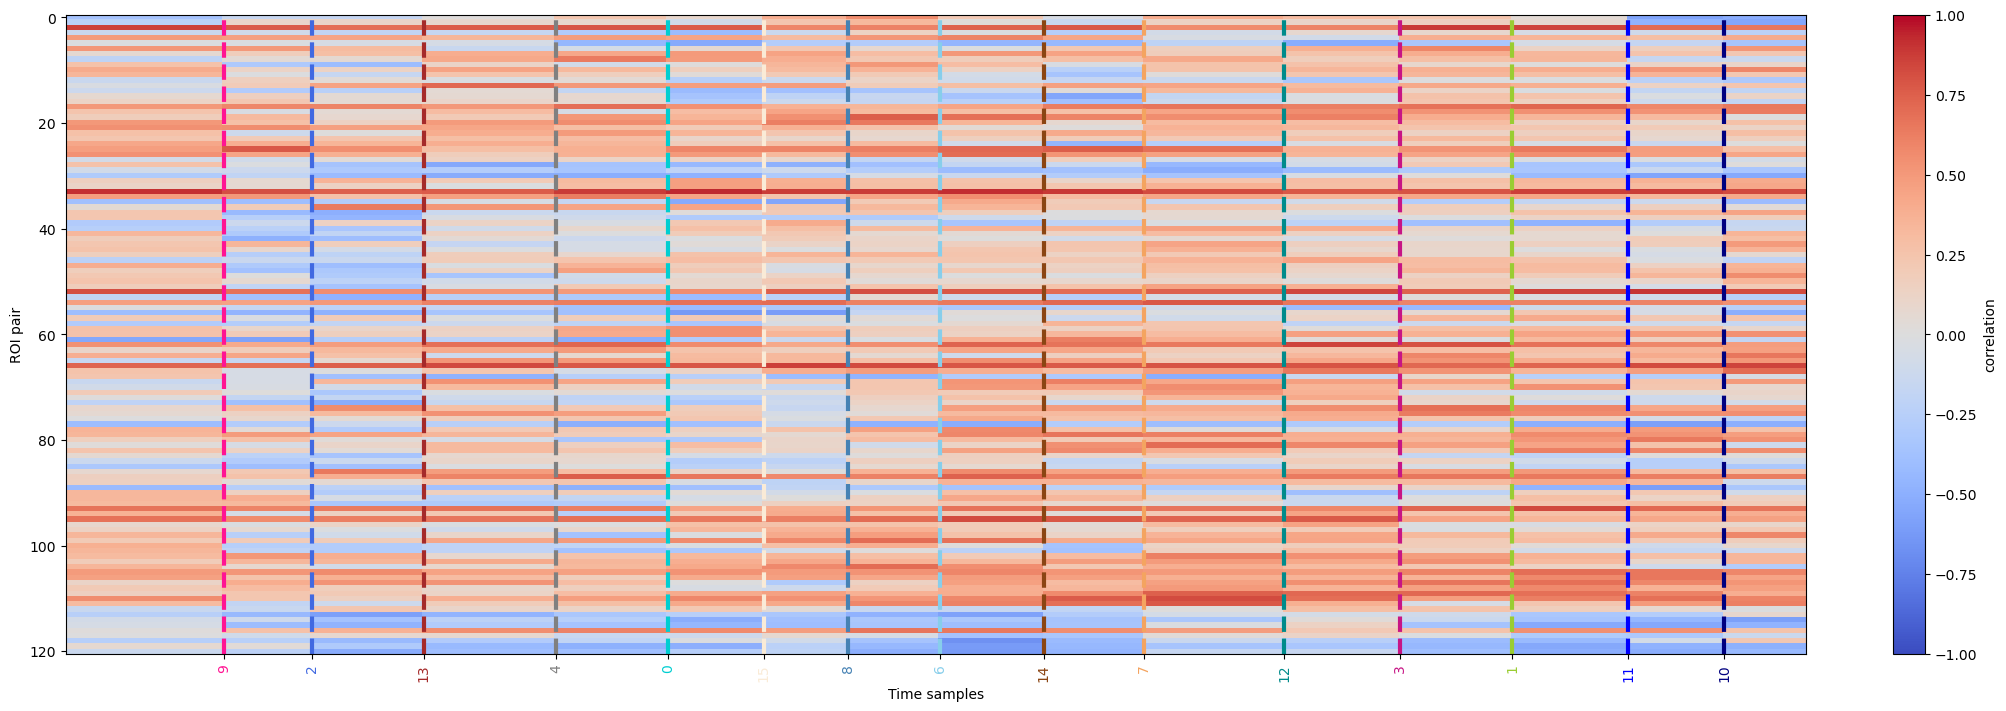

################################################################
subject  7


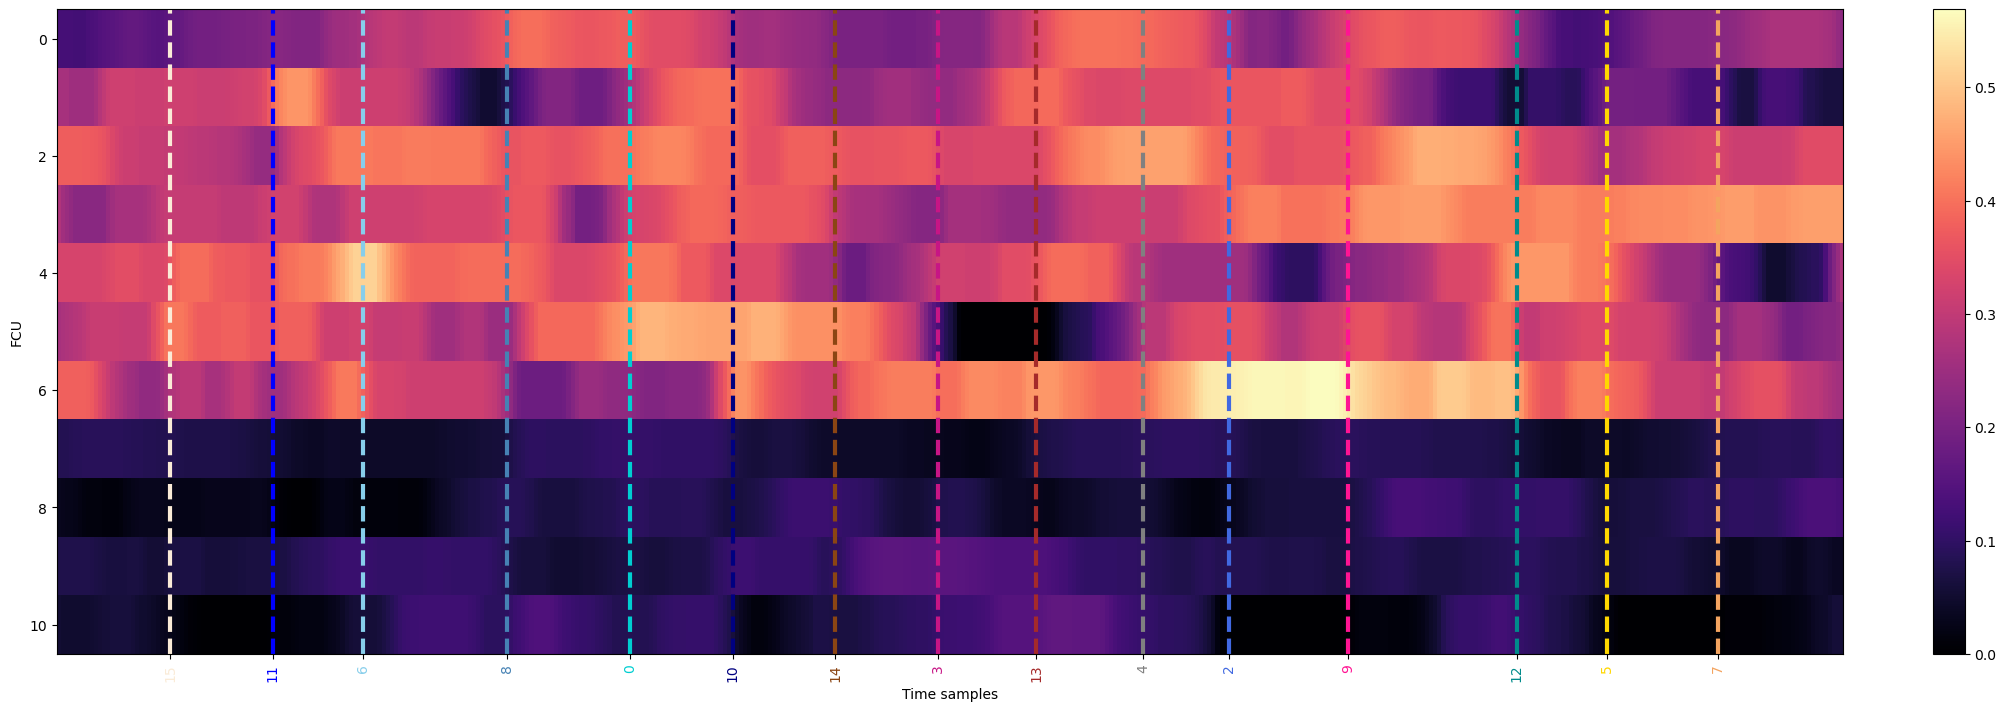

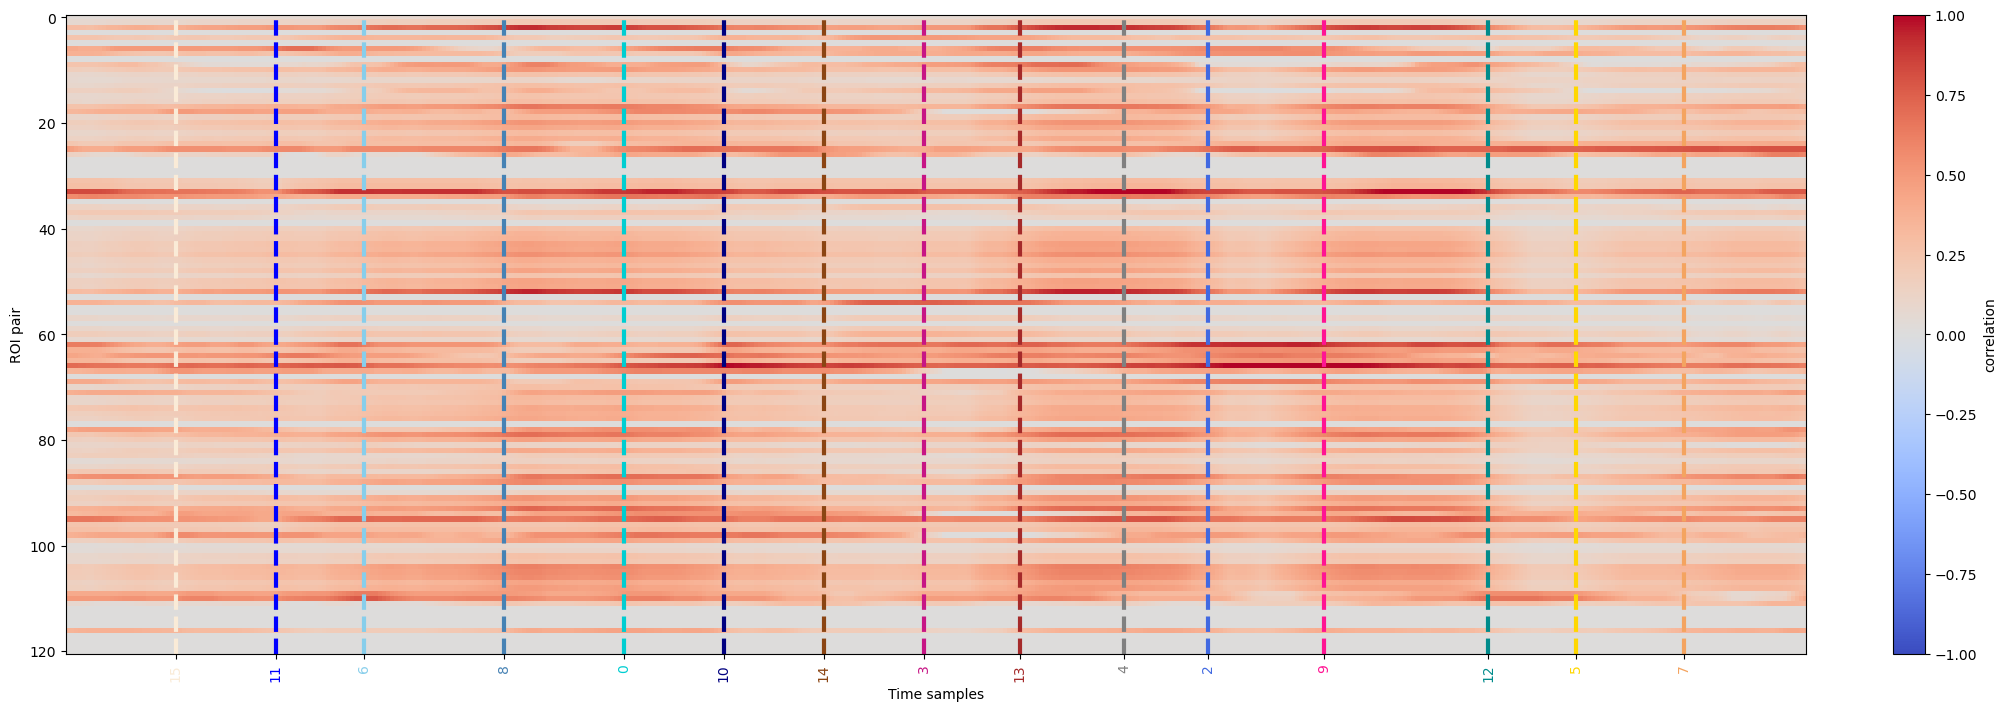

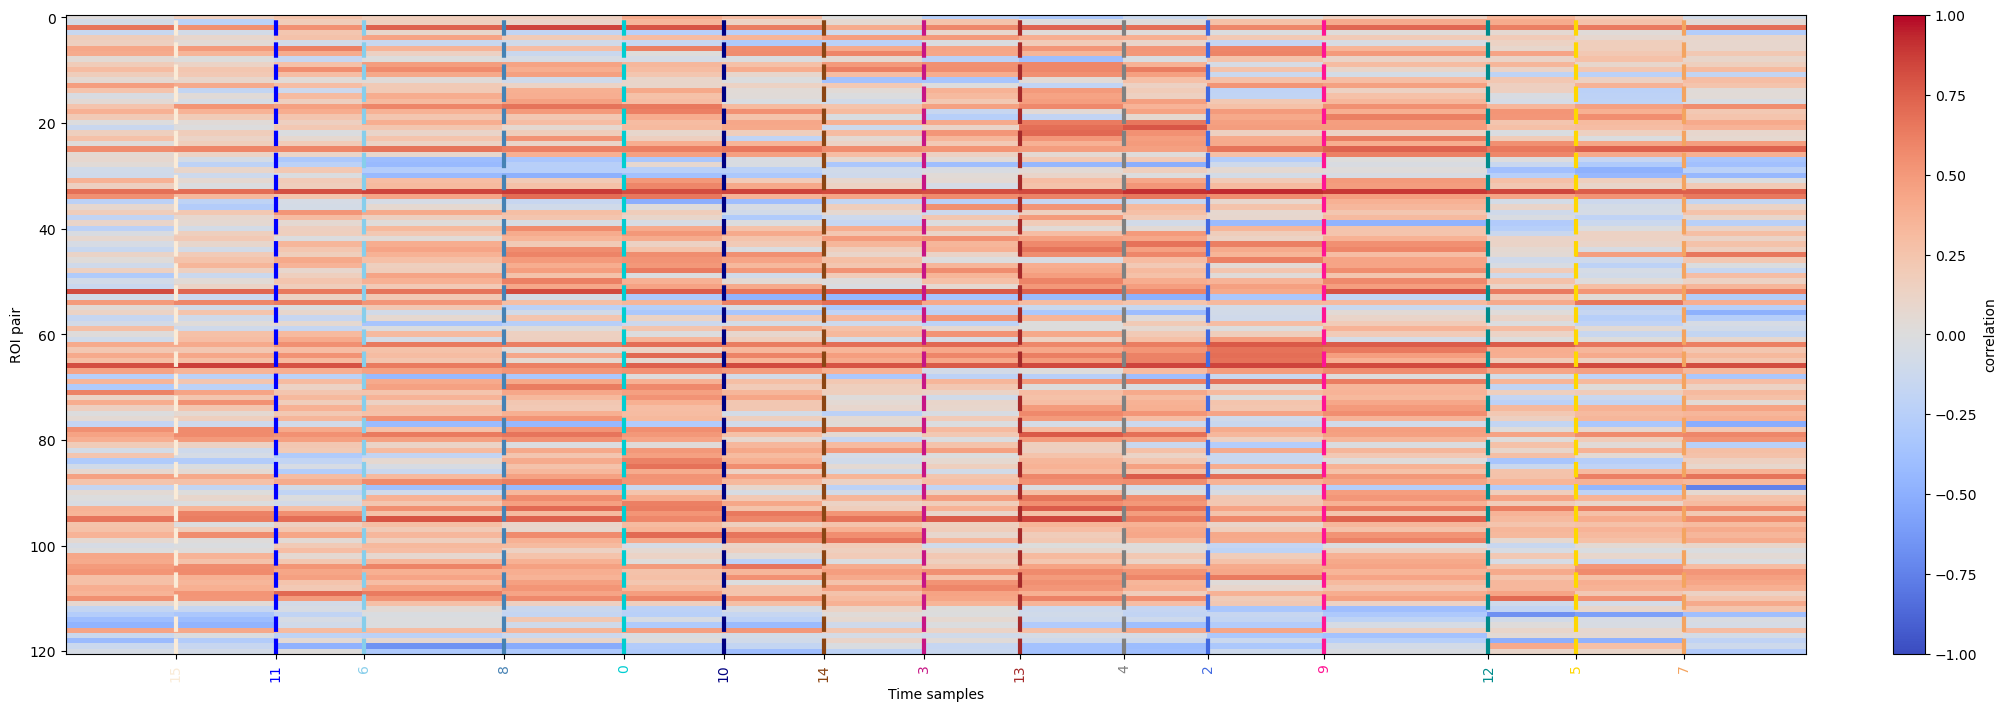

In [31]:
n_clusters = 16

for s, result in enumerate(results_list):
    print("################################################################")
    print("subject " , s)
    
    centroids, states = kmeans_clustering( Cvec_list[s], n_clusters=n_clusters)
    transitions = np.diff(states ,prepend = -1) != 0
    transitions_idx = np.where(transitions)[0]
    
    C_kmeans = k_means_reconstruc_C(centroids, states)
    
    A_est = result["A_est"]
    D_est = result["D_est"]
    C_est =result["C_est"]
    
    #################### A #################################
    fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
    plt.imshow(A_est, aspect = 'auto', interpolation = 'nearest', cmap = 'magma')
    plt.xlabel("Time samples")
    plt.ylabel("FCU")
    plt.grid(False)
    plt.colorbar()
    
    #mark the transitions of the states
    plt.xticks(transitions_idx , states[transitions_idx] , rotation = 90)

    for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
        #set the xtick to the colors of the state
        state_color = list_colors[states[tr_idx]]
        label.set_color(state_color)
        #mark the transition of the states
        plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)
    plt.show()
    
    ########################## C #####################
    fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
    plt.imshow(C_est, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
    plt.xlabel("Time samples")
    plt.ylabel("ROI pair")
    plt.grid(False)
    plt.colorbar(label = "correlation")
    
    #mark the transitions of the states
    plt.xticks(transitions_idx , states[transitions_idx], rotation = 90)

    for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
        #set the xtick to the colors of the state
        state_color = list_colors[states[tr_idx]]
        label.set_color(state_color)
        #mark the transition of the states
        plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)
    
    plt.show()
        
    ########################## C K means#####################
    fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
    plt.imshow(C_kmeans, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
    plt.xlabel("Time samples")
    plt.ylabel("ROI pair")
    plt.grid(False)
    plt.colorbar(label = "correlation")
    
    #mark the transitions of the states
    plt.xticks(transitions_idx , states[transitions_idx], rotation = 90)

    for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
        #set the xtick to the colors of the state
        state_color = list_colors[states[tr_idx]]
        label.set_color(state_color)
        #mark the transition of the states
        plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)
    
    plt.show()

### Use the clusters from the concatenation of subjects

In [41]:
def k_means_reconstruc_C(centroids, states):
    E = centroids.shape[0]
    T = len(states)
    Cvec = np.zeros((E, T))
    
    for t , state in enumerate(states):
        Cvec[:, t] = centroids[:, state]
        
    return Cvec

In [42]:
T = Cvec_list[0].shape[1]

In [43]:
Cvec_concatenated = np.concatenate(Cvec_list , axis =1)

################################################################
subject  0


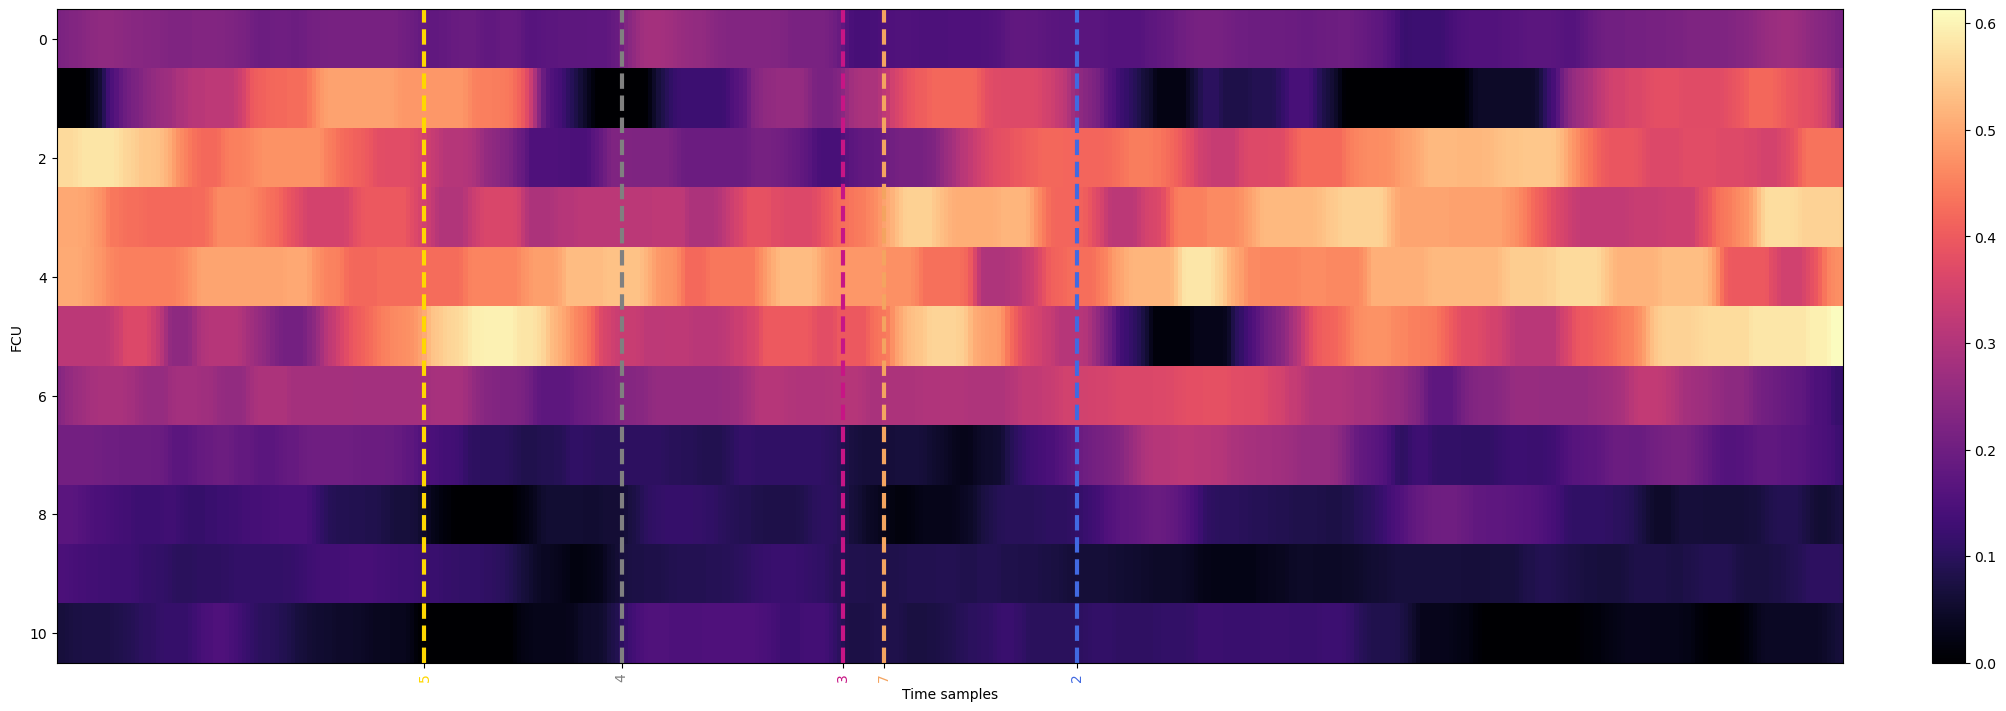

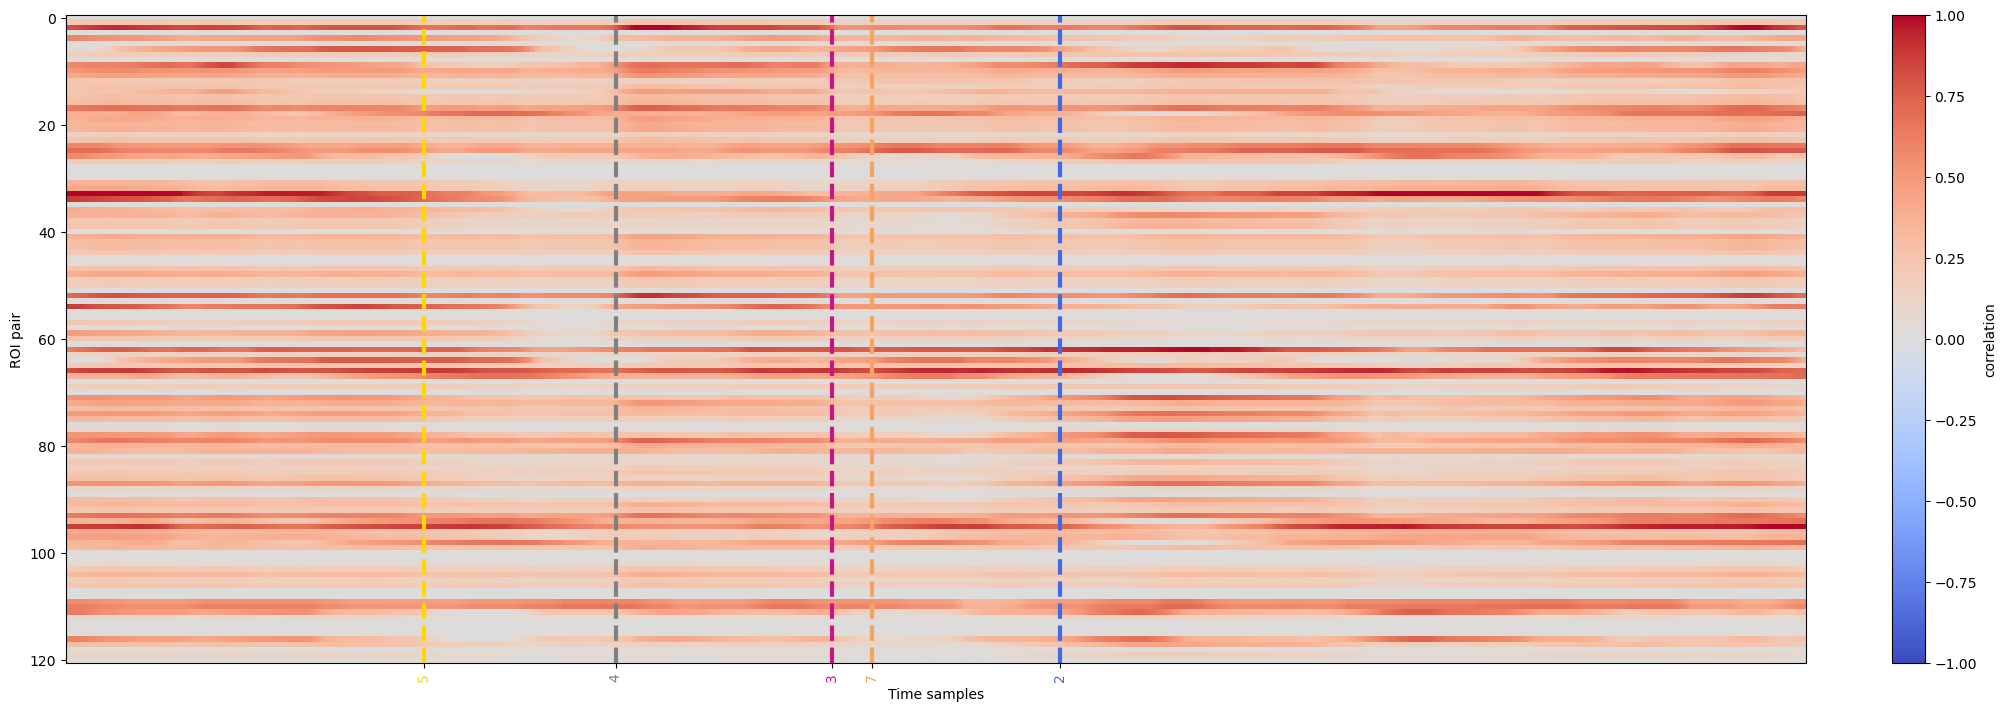

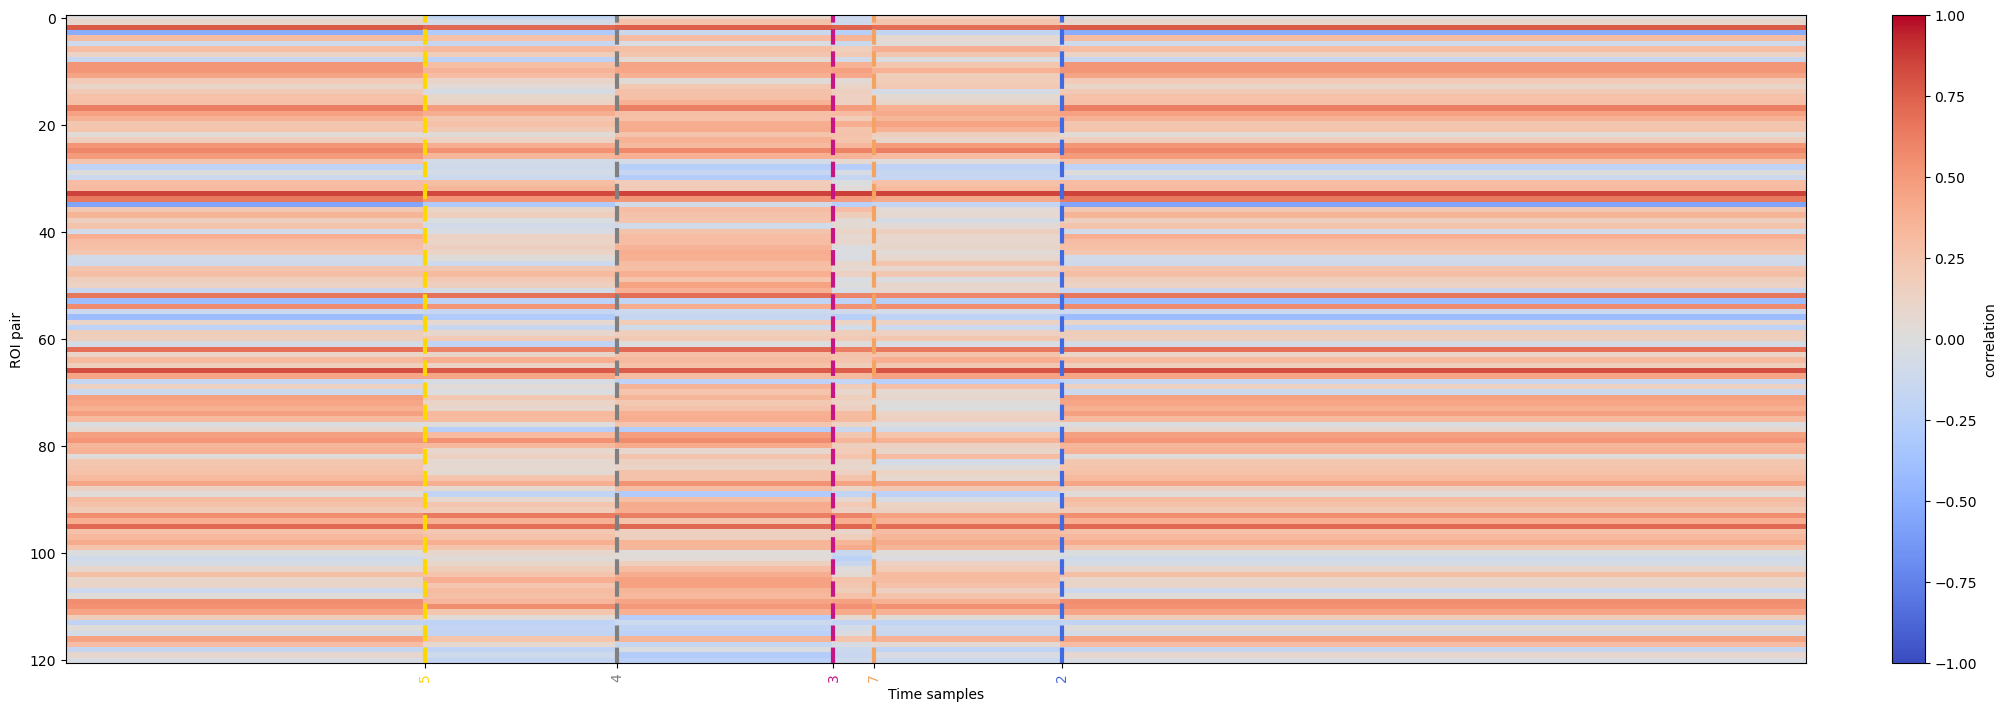

################################################################
subject  1


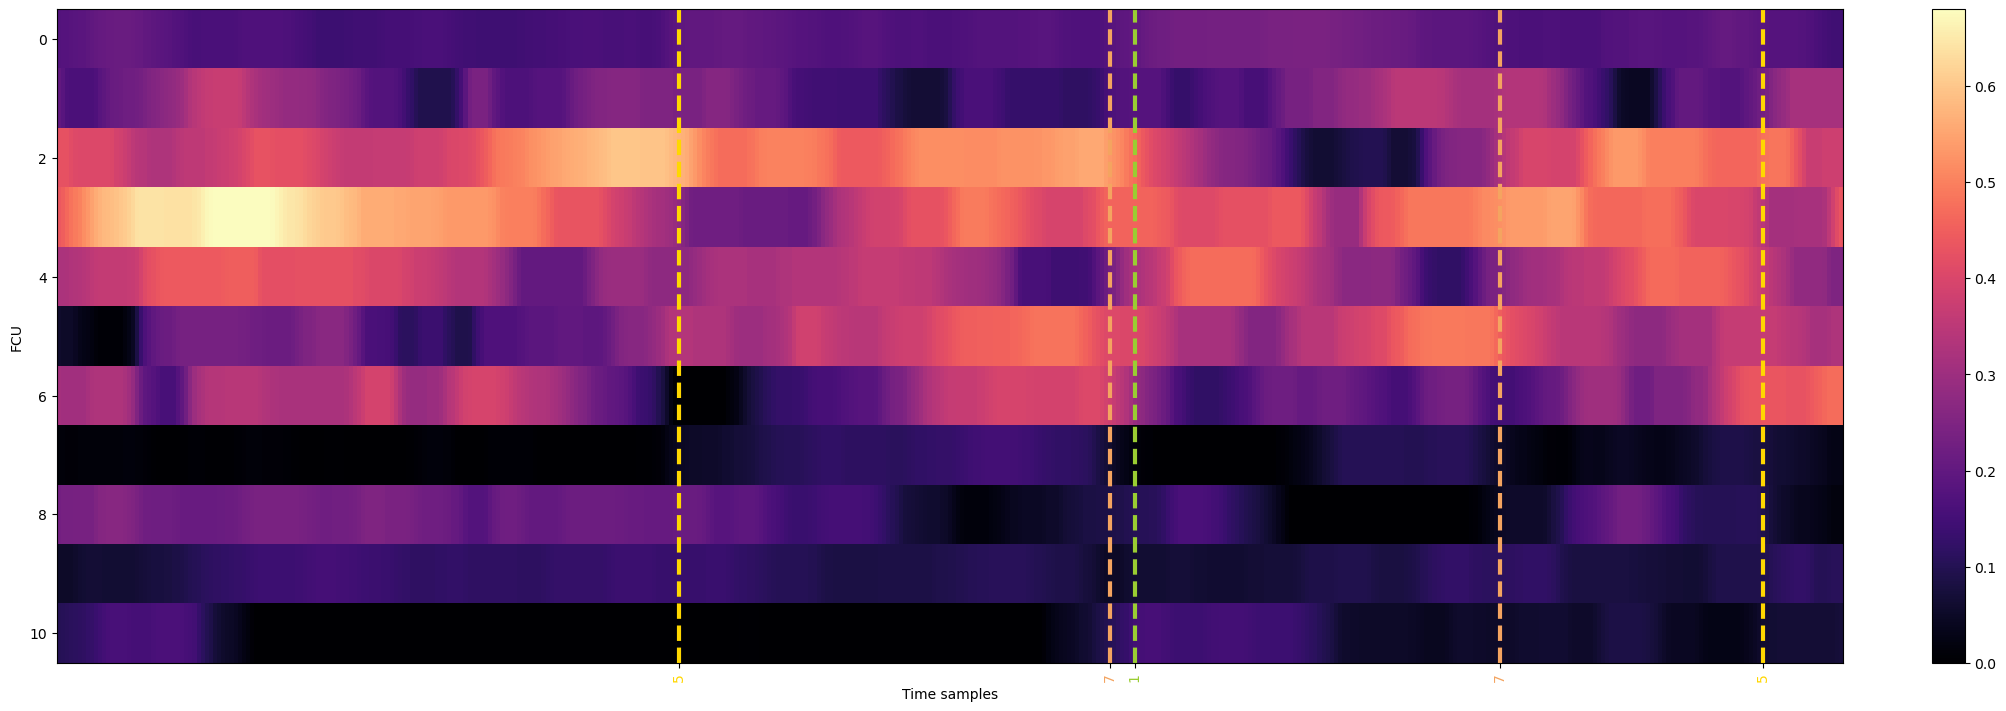

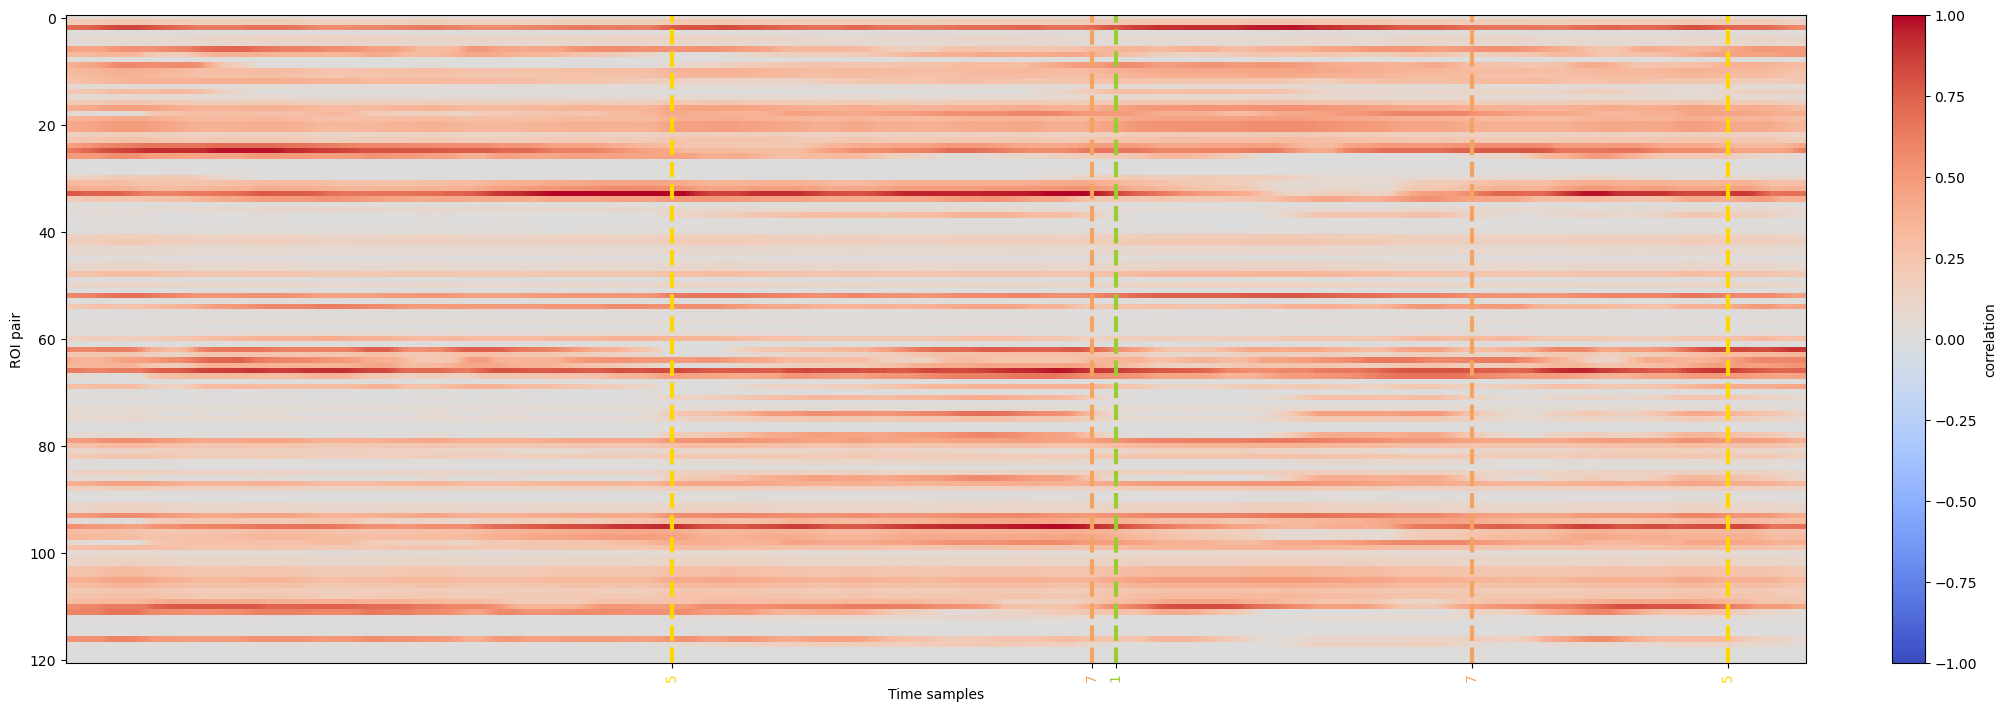

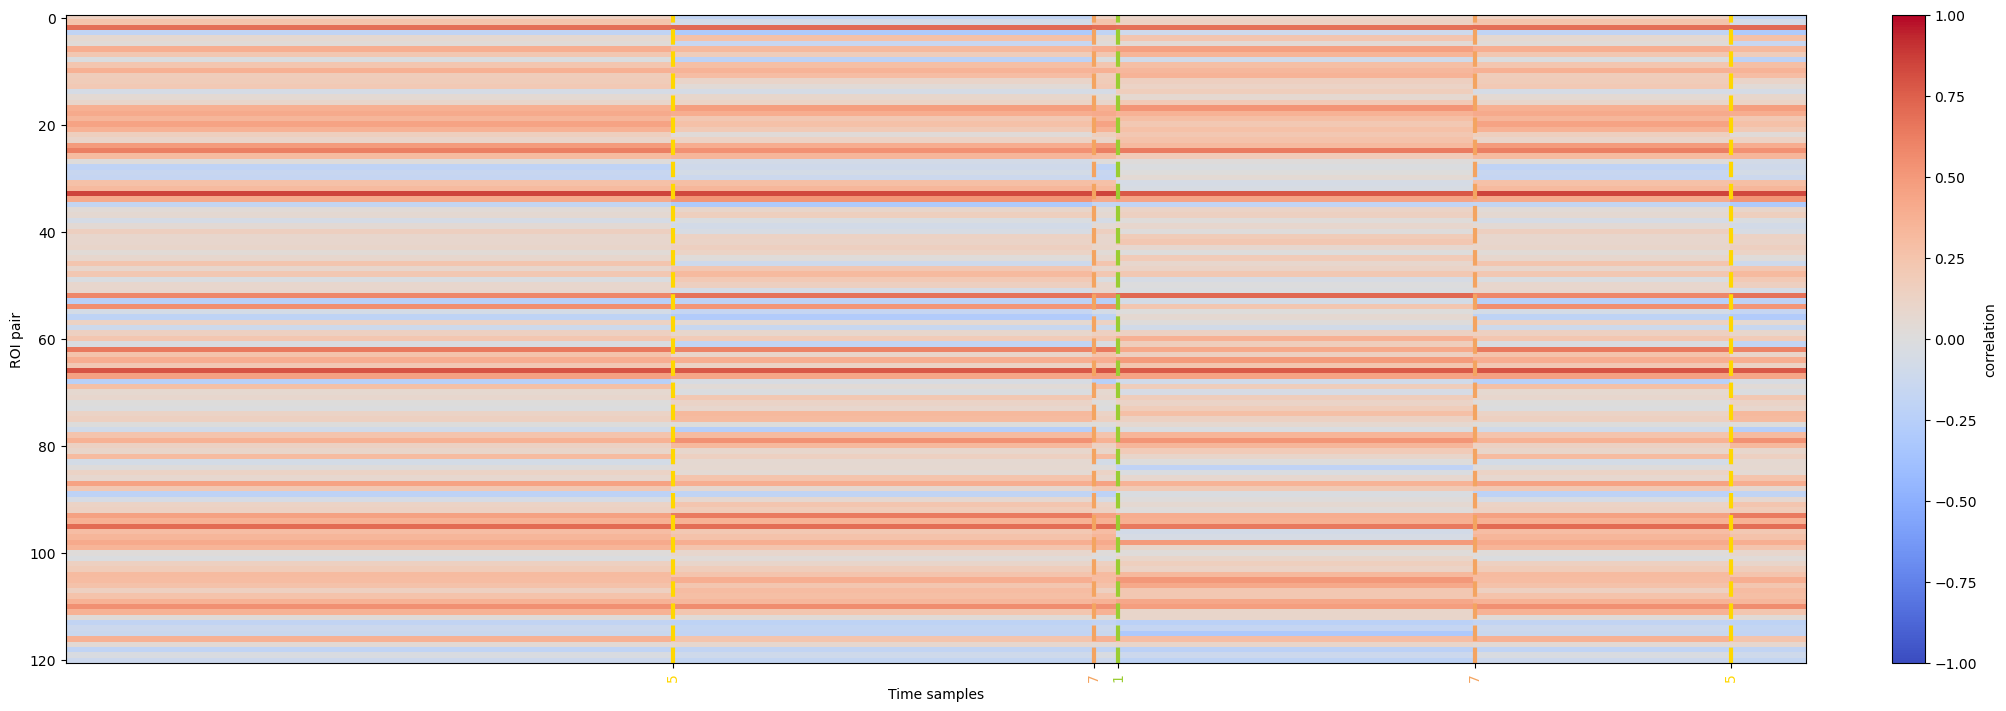

################################################################
subject  2


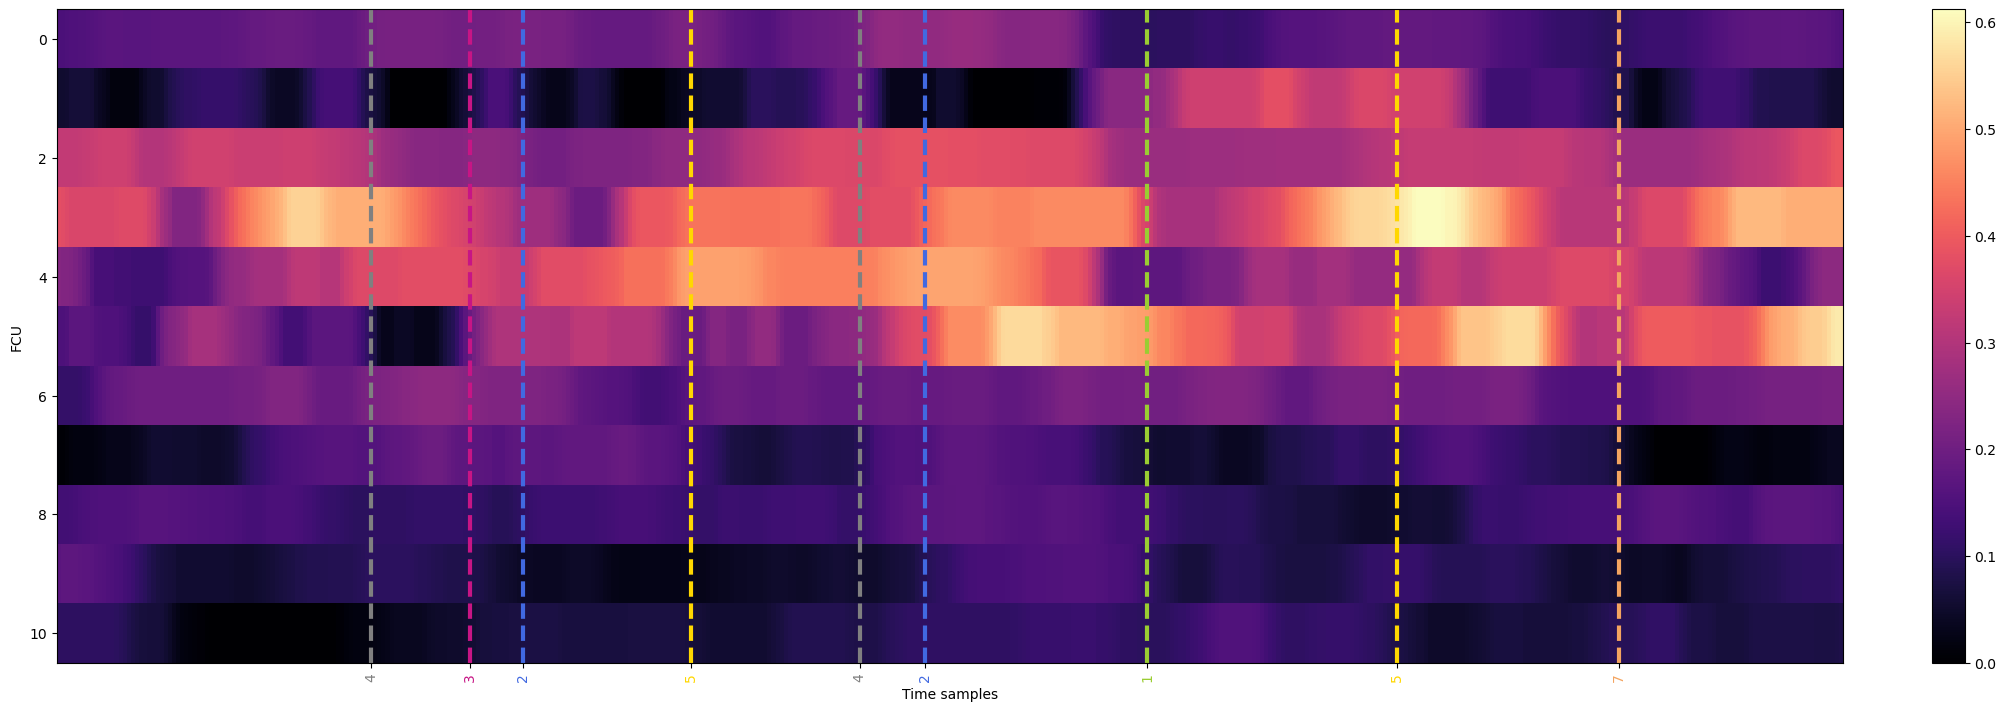

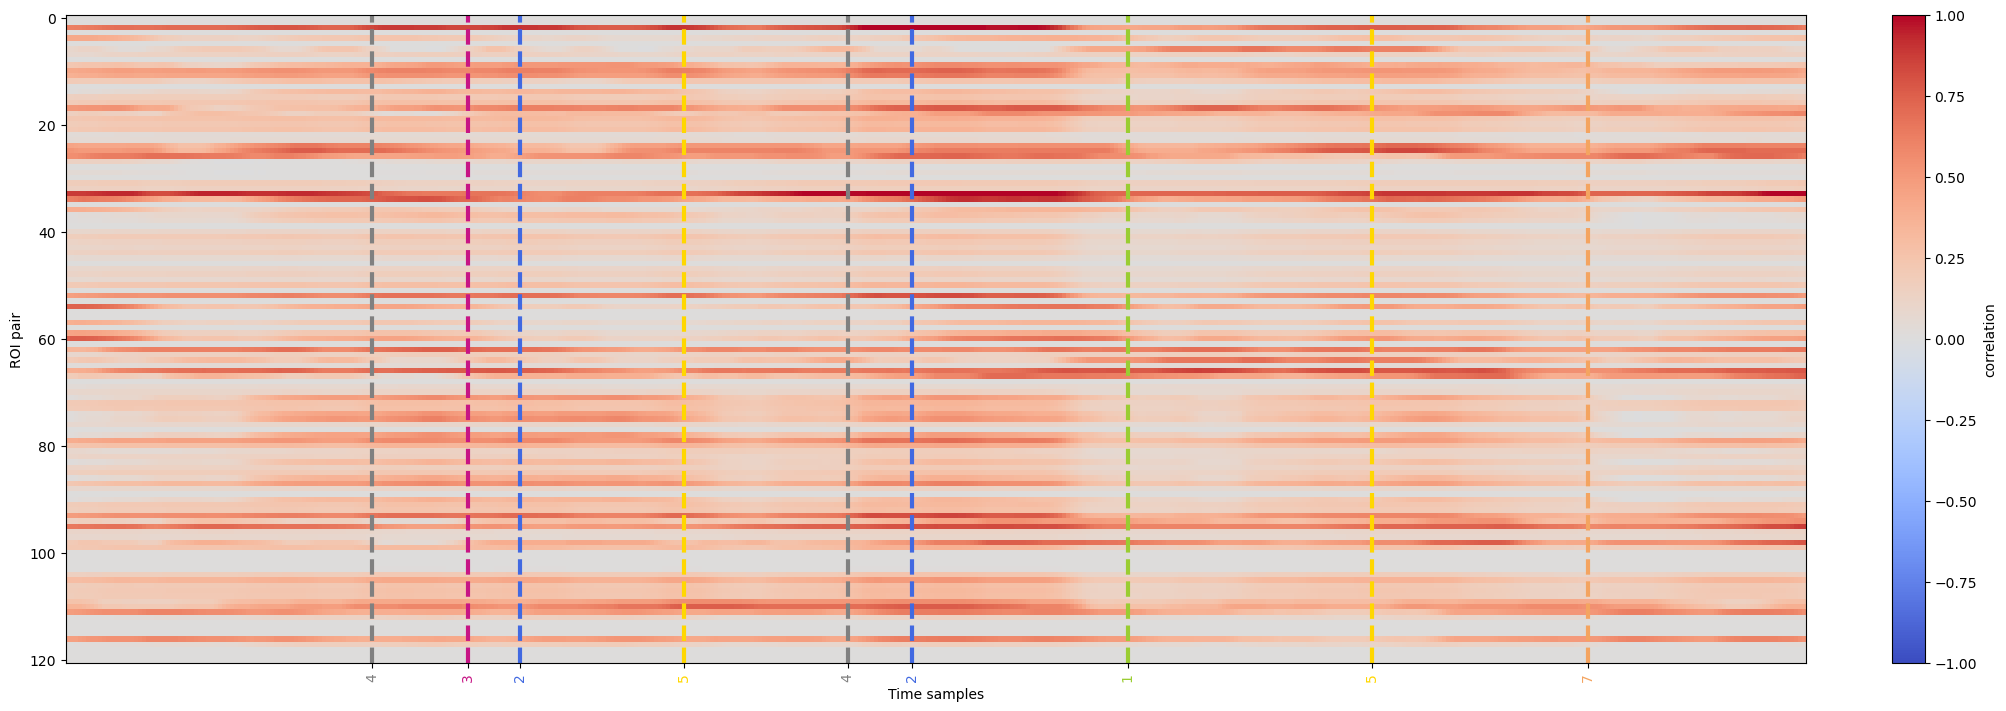

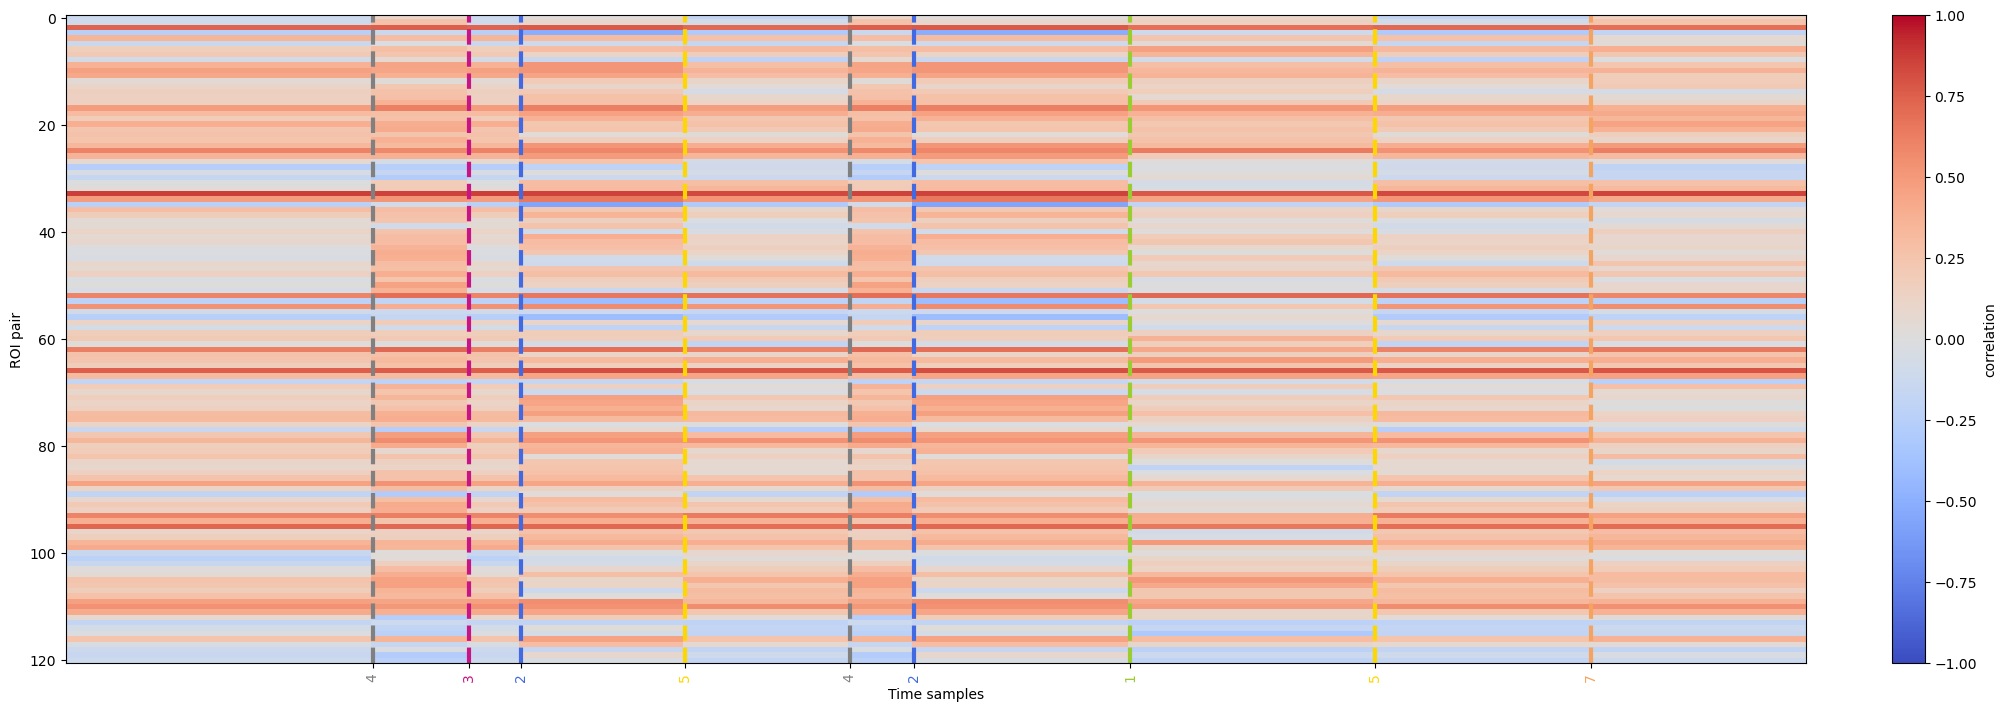

################################################################
subject  3


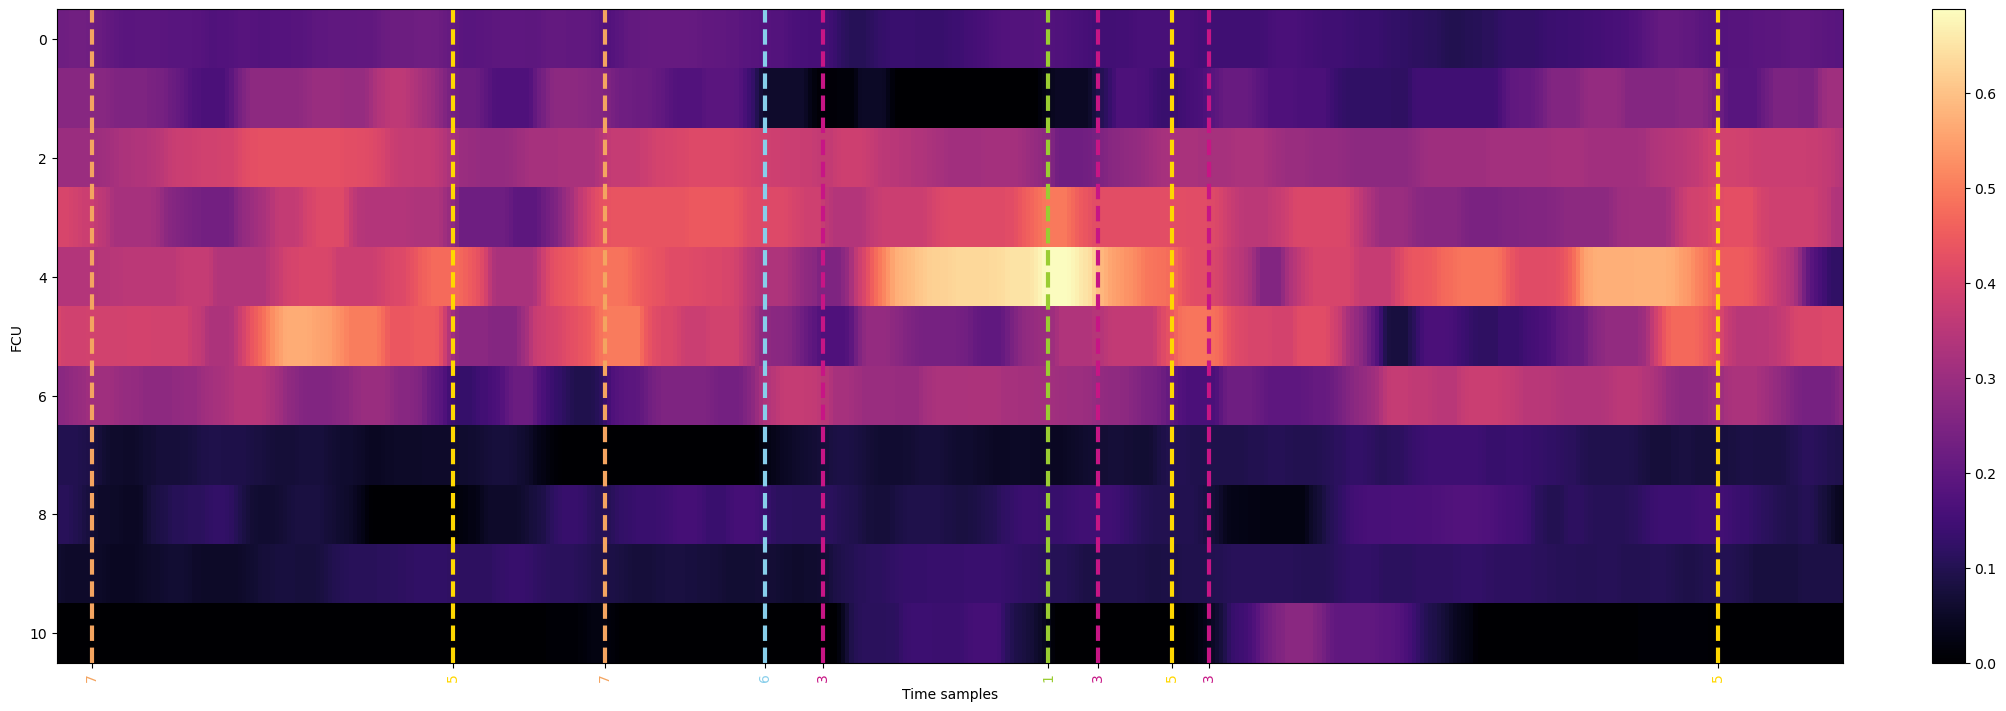

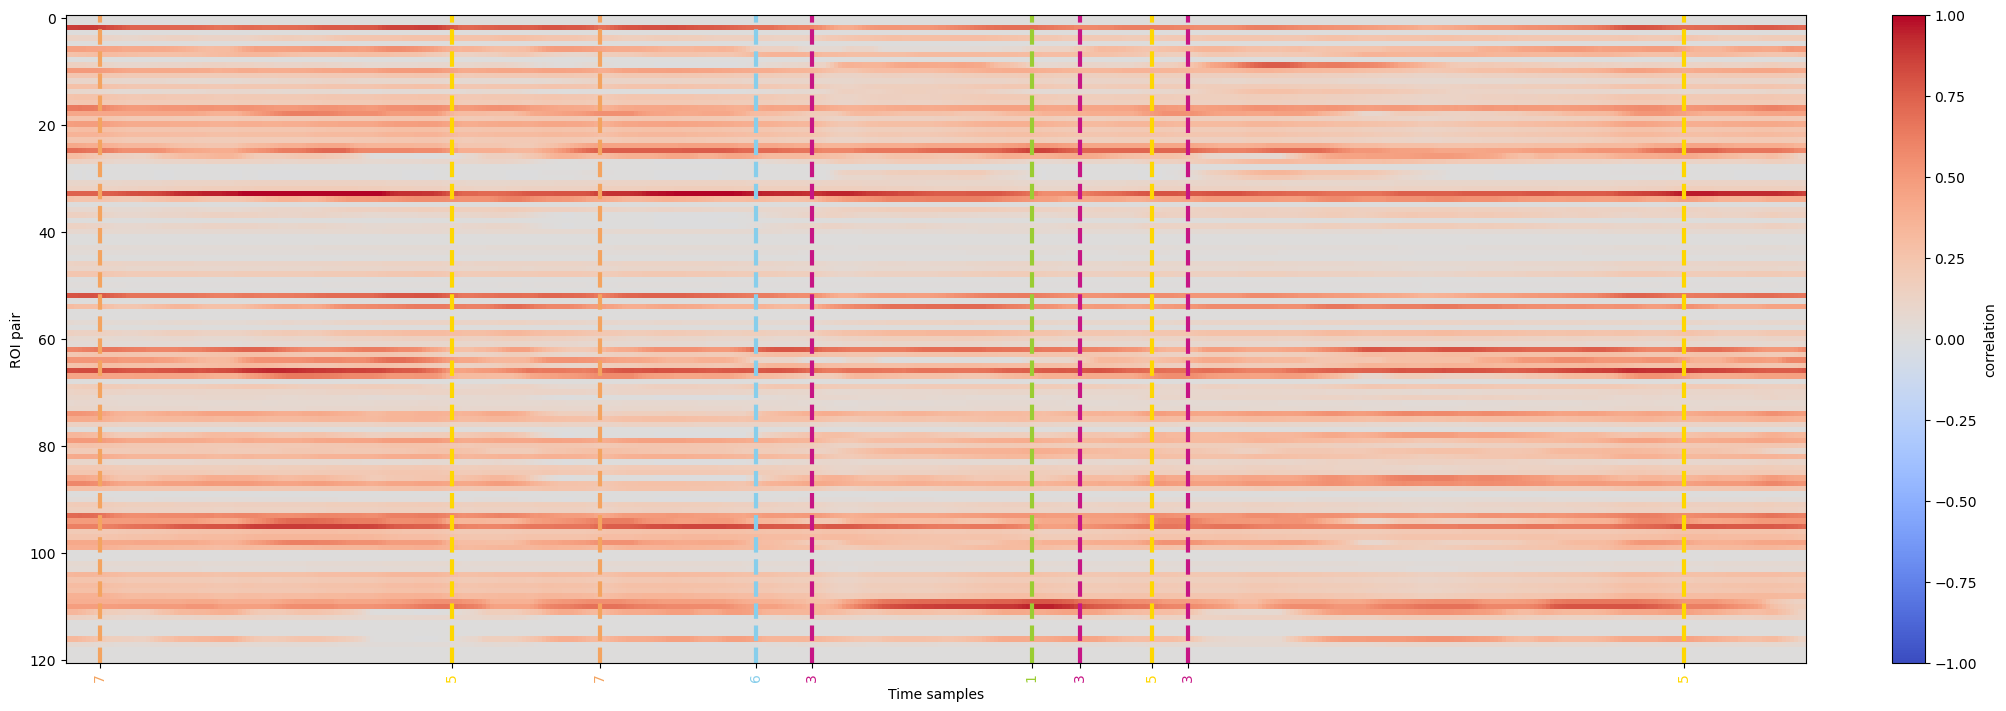

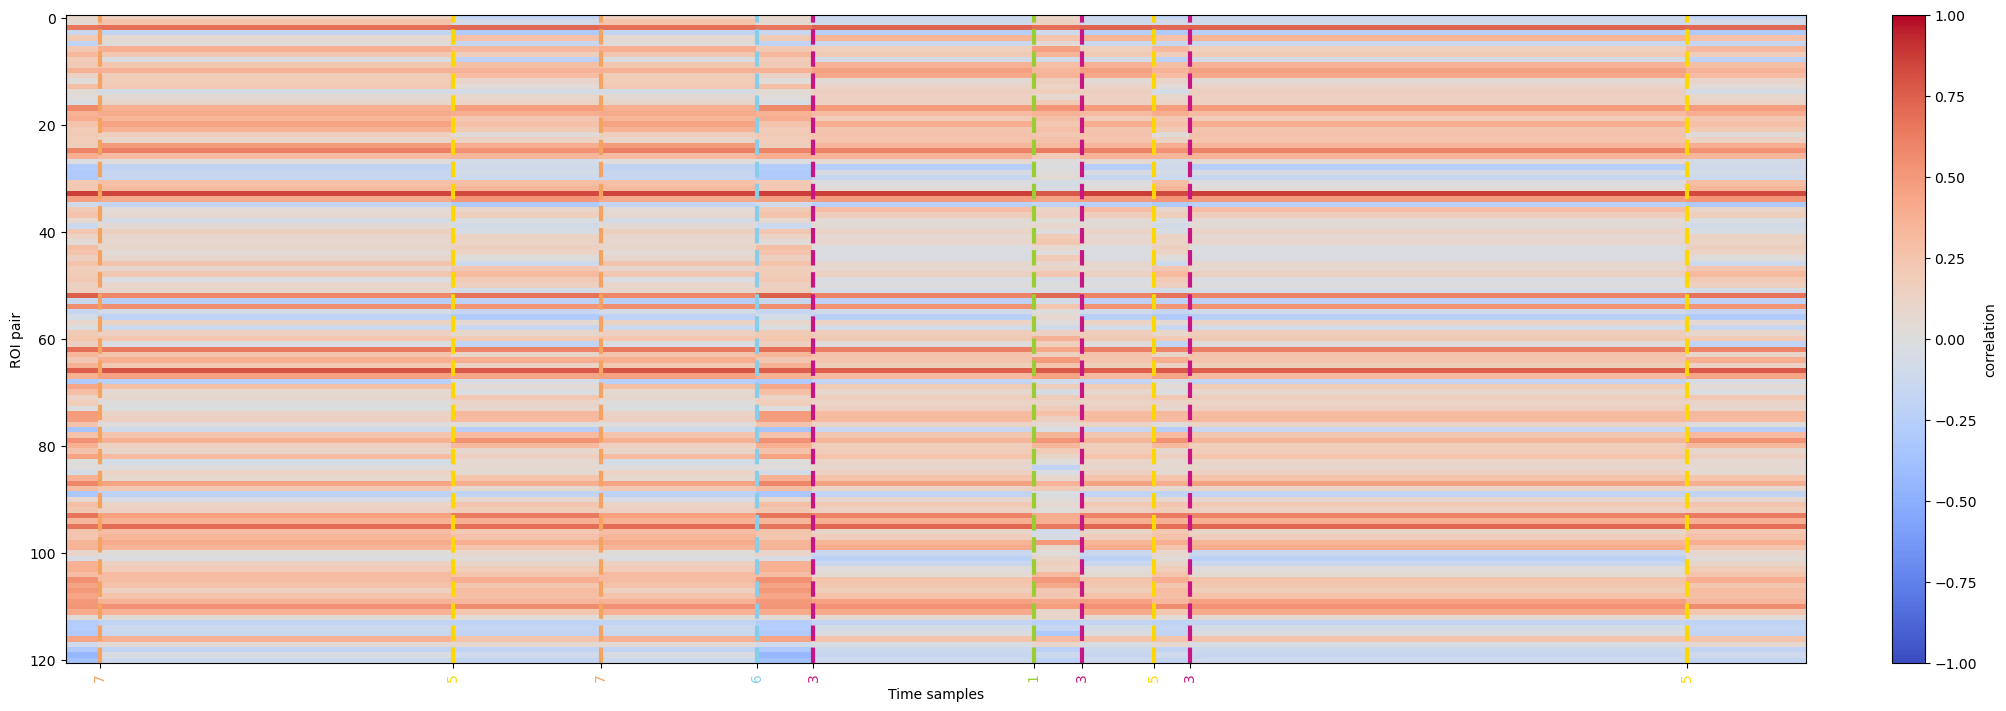

################################################################
subject  4


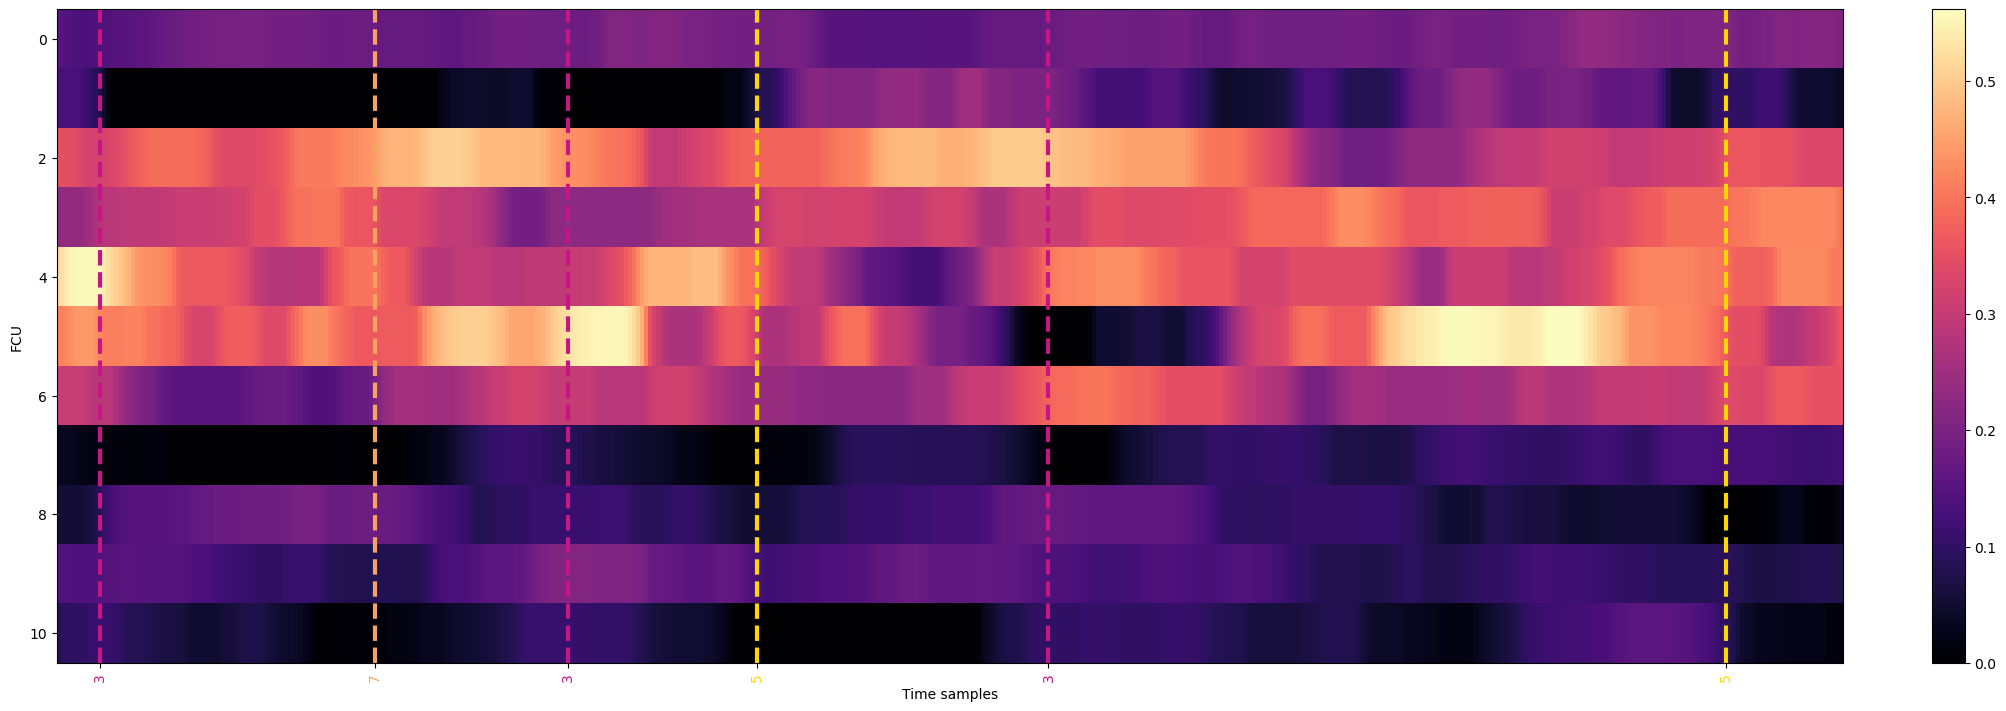

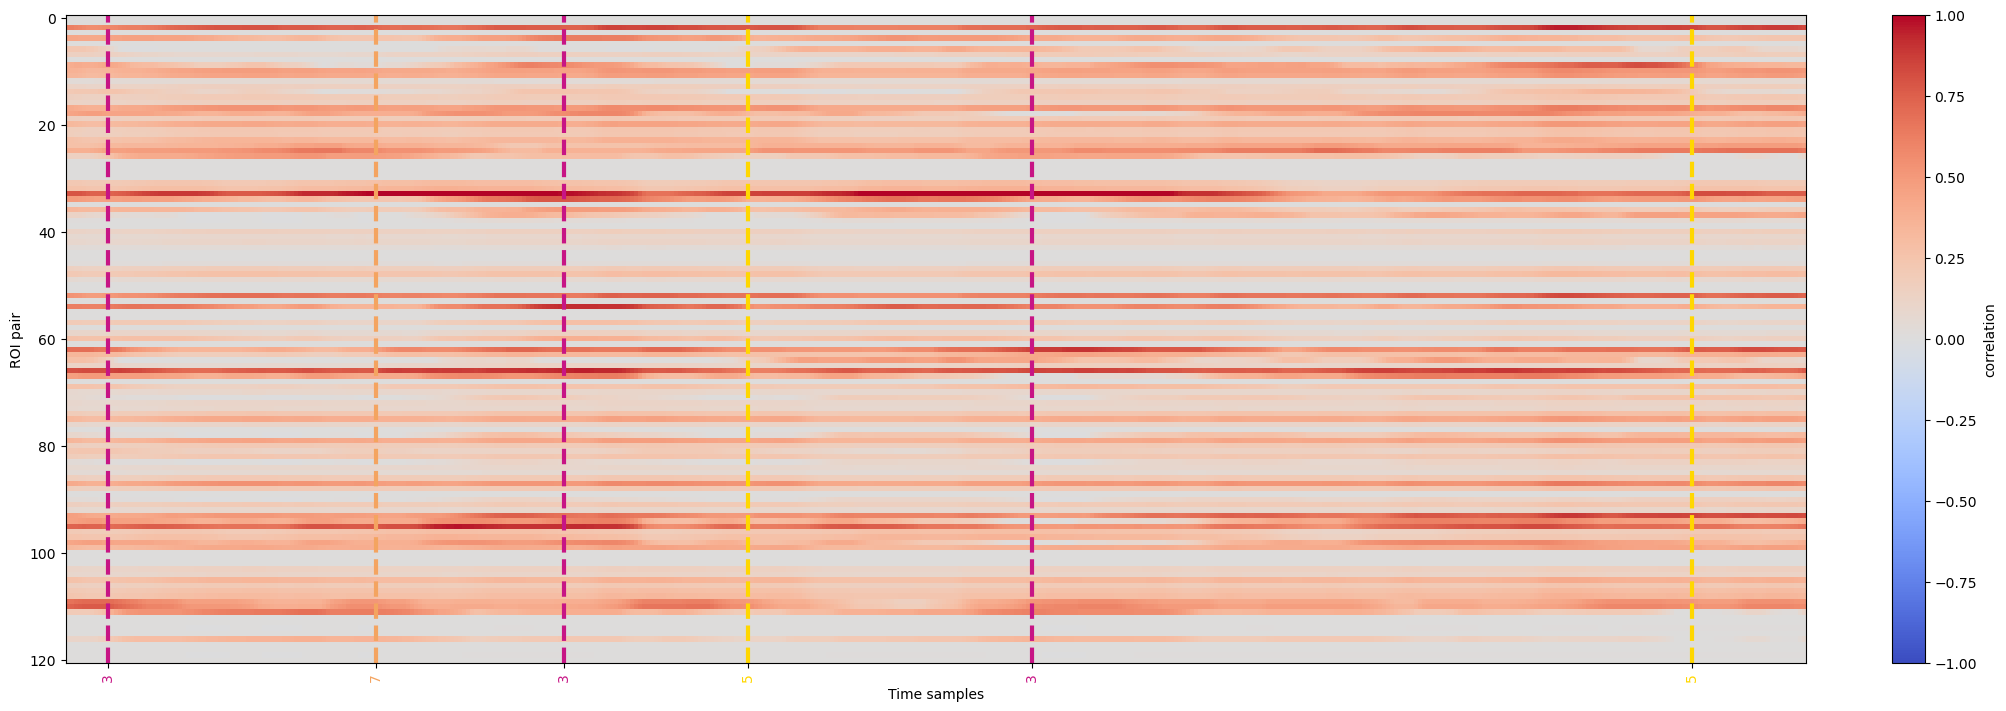

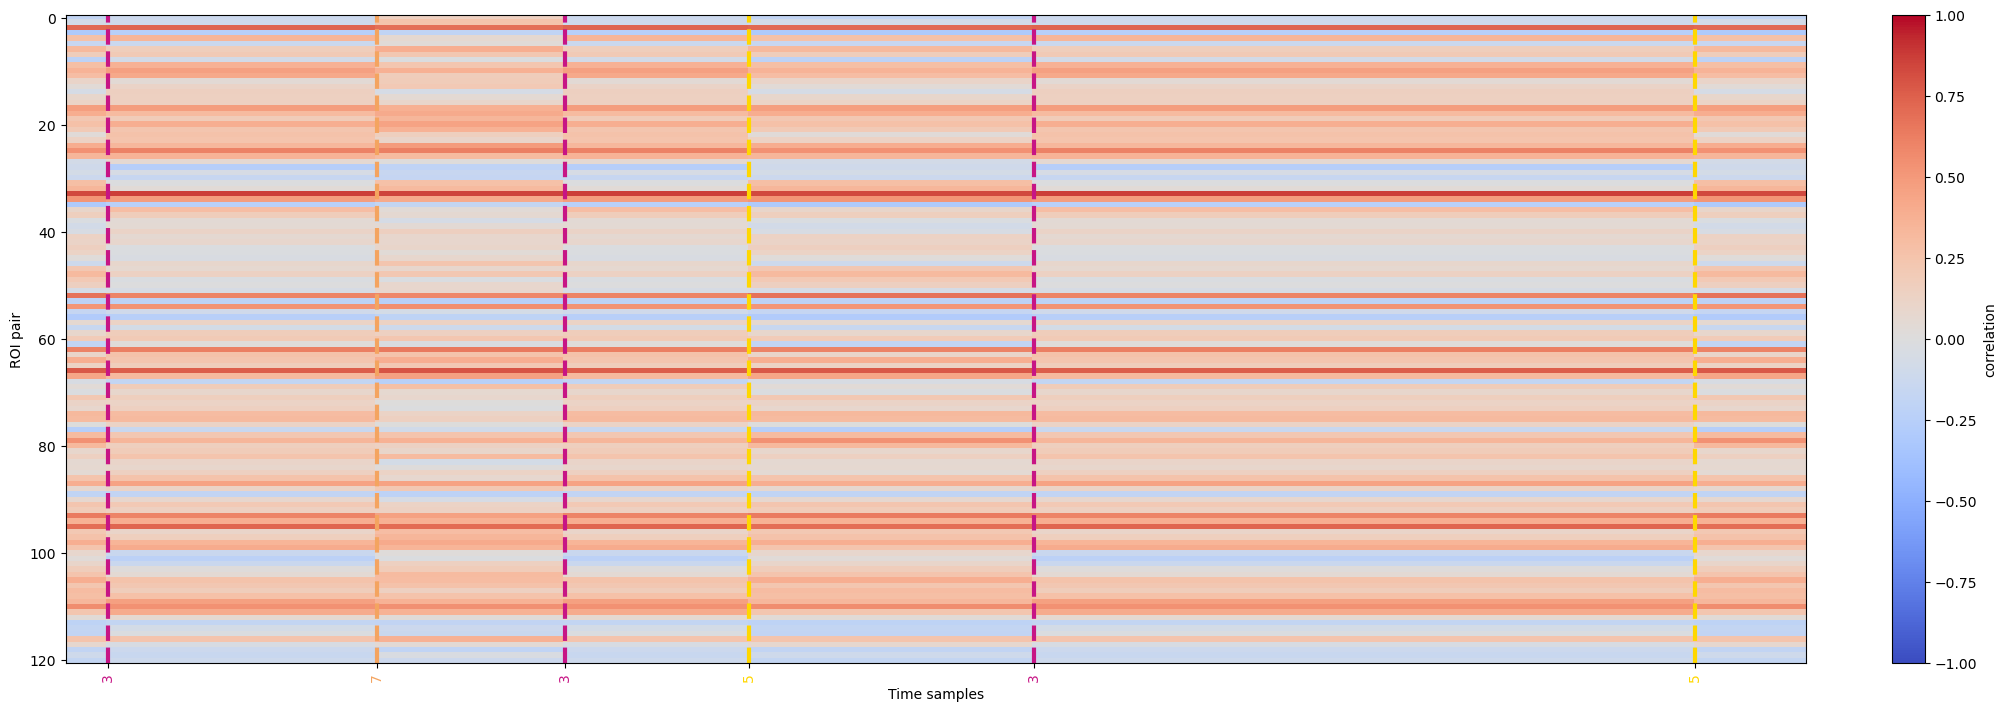

################################################################
subject  5


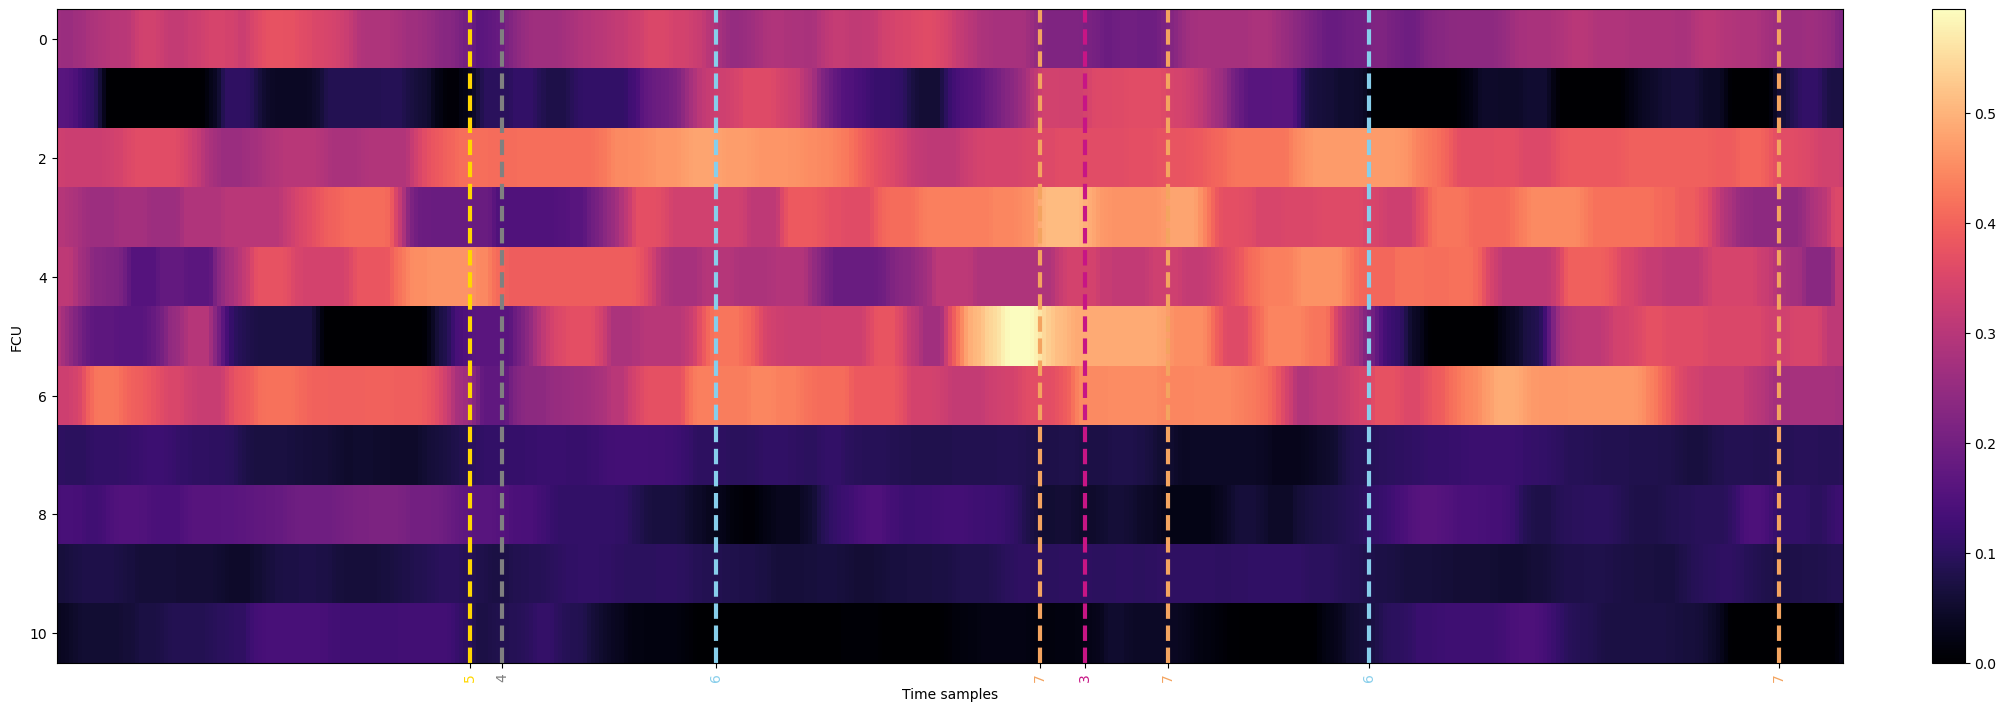

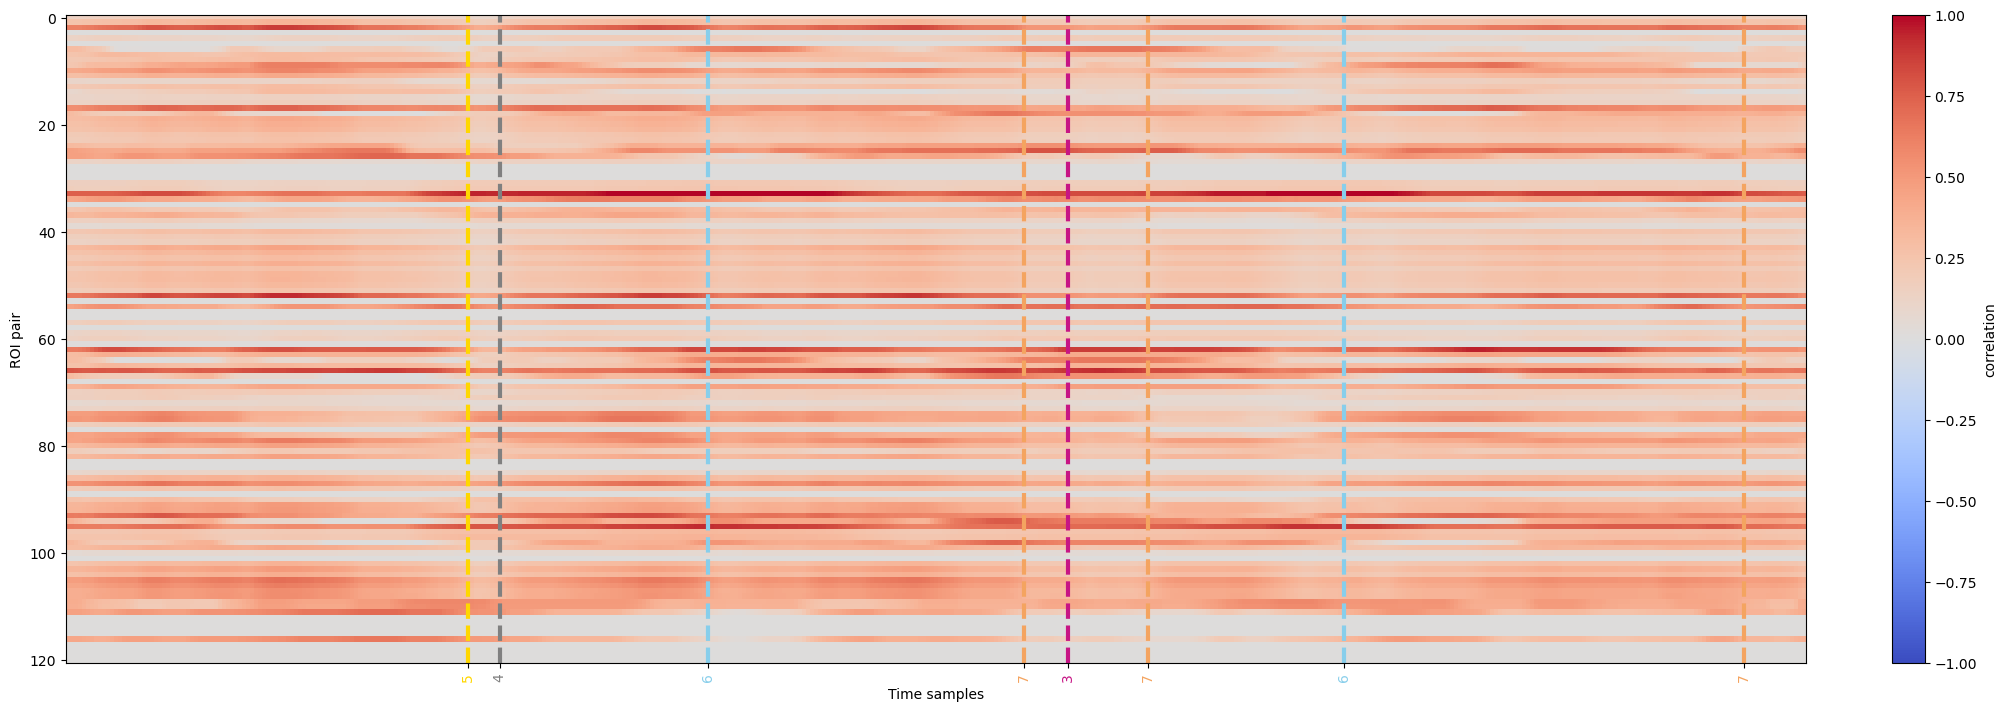

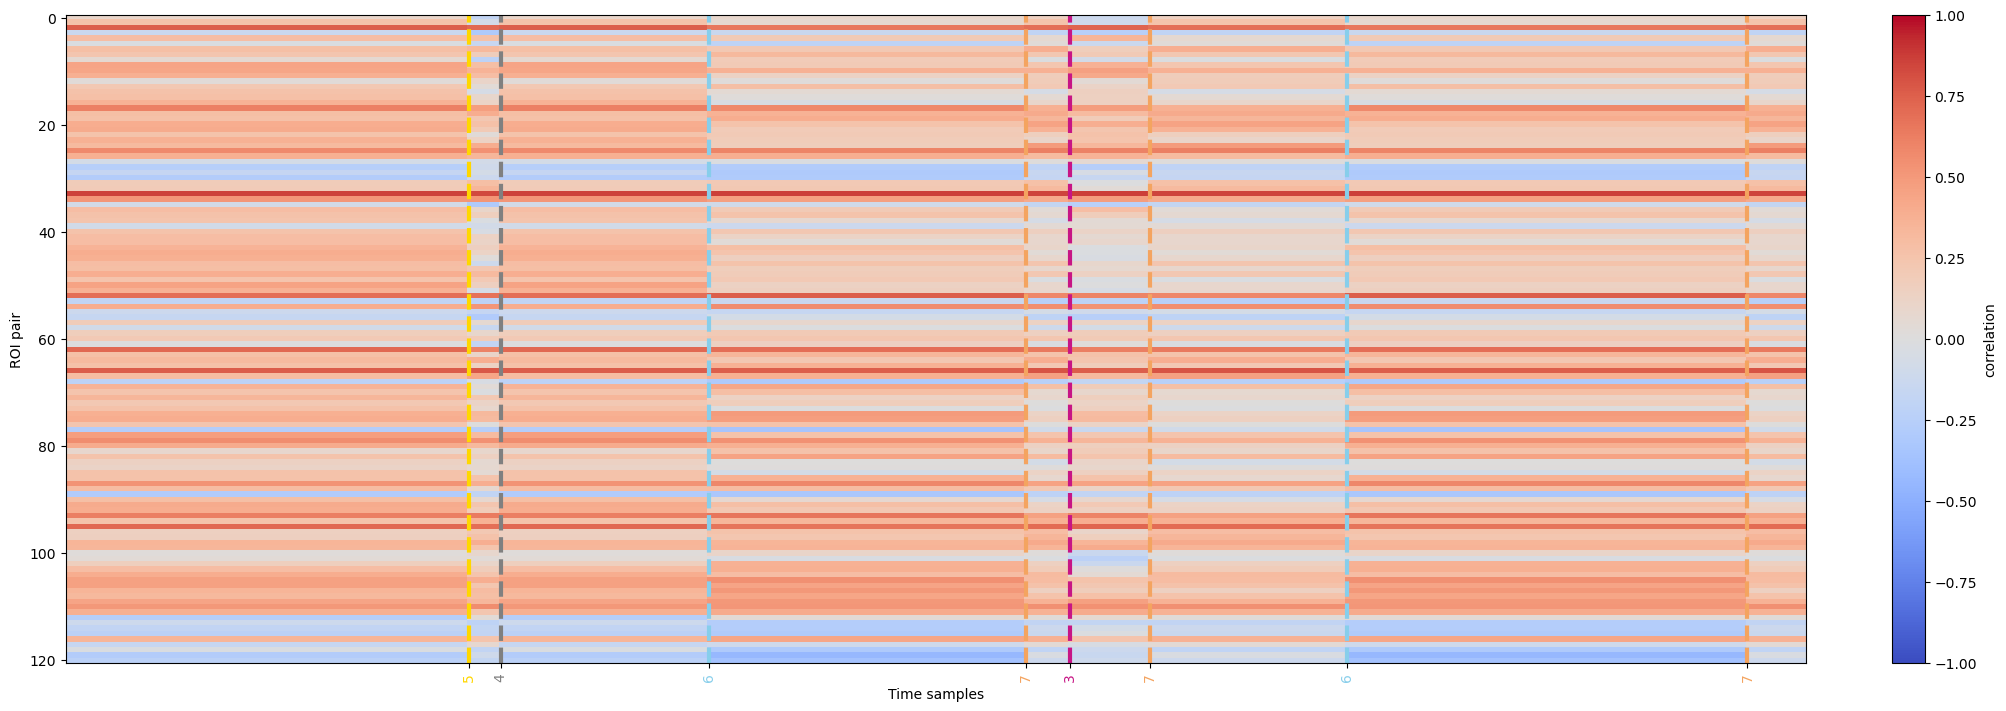

################################################################
subject  6


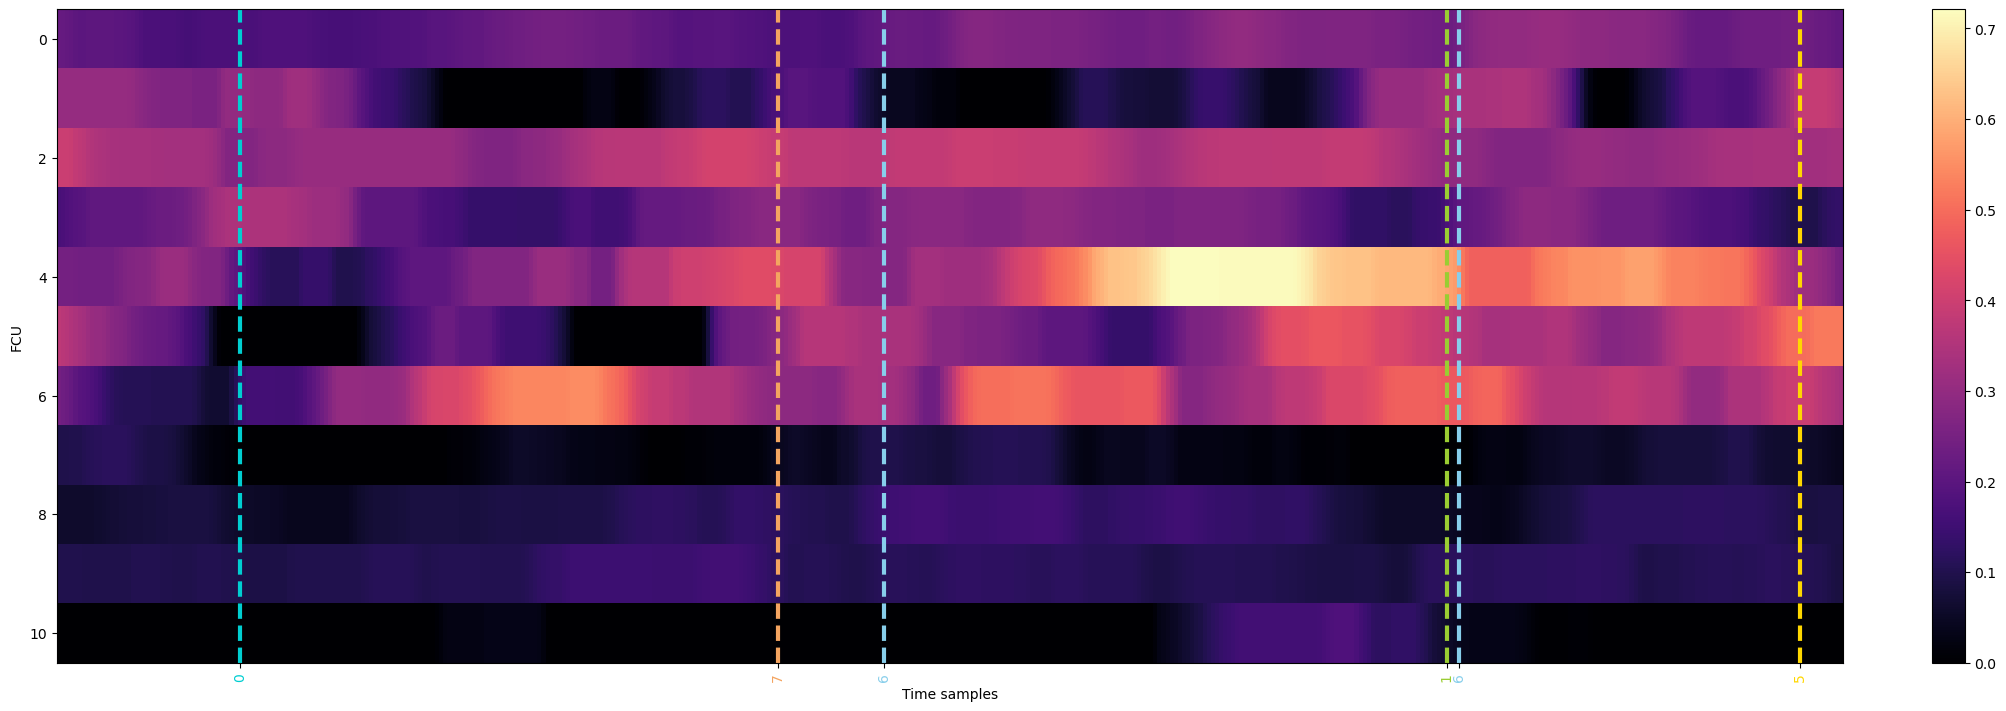

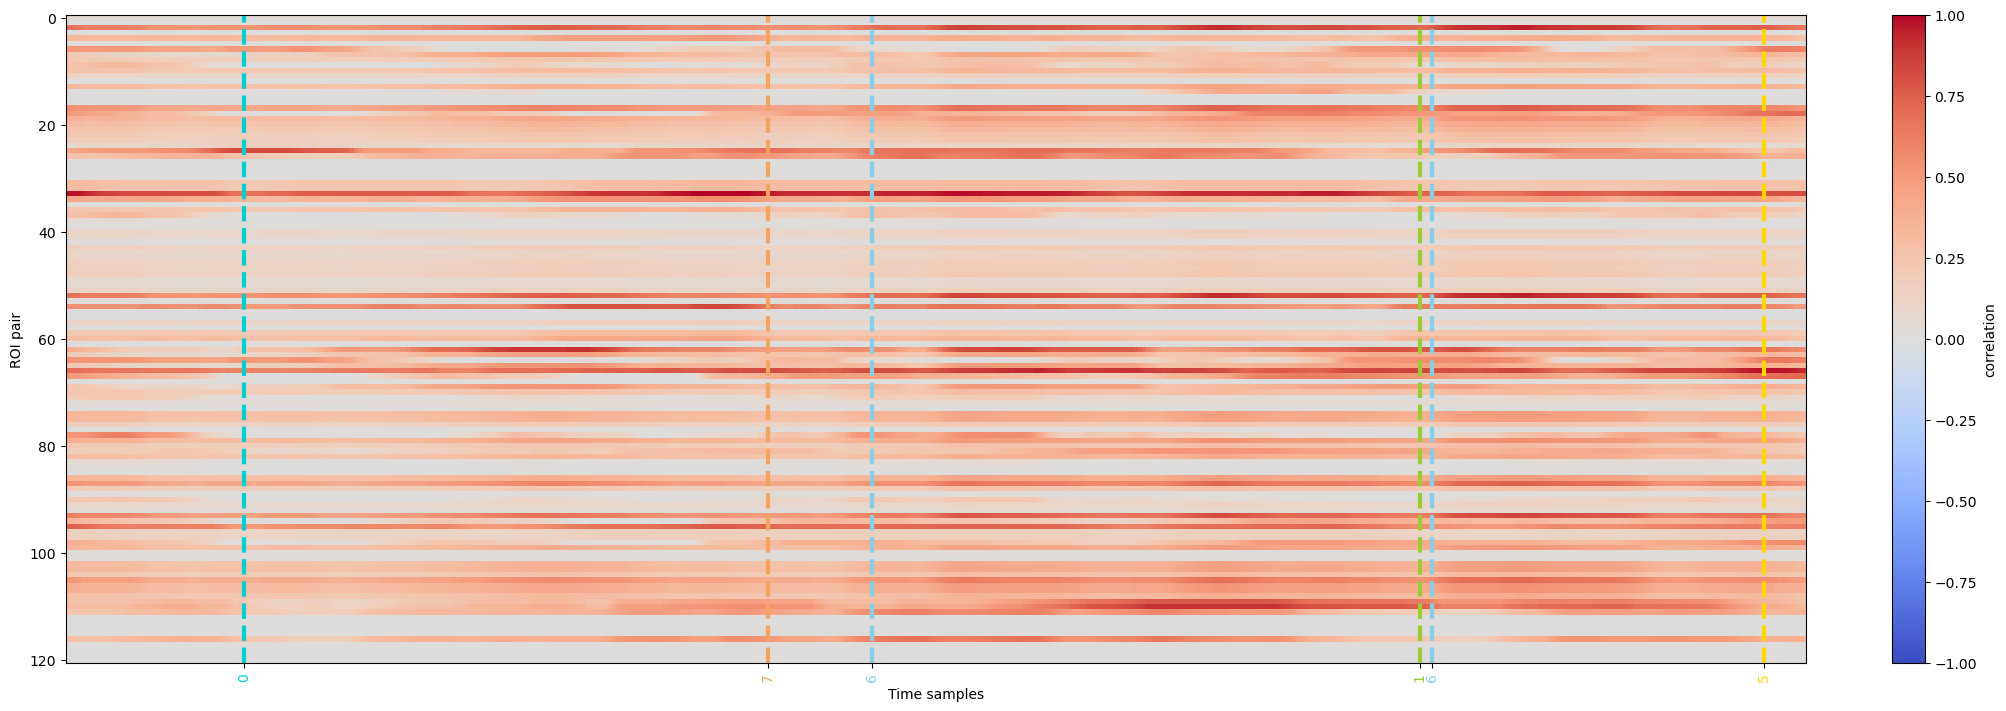

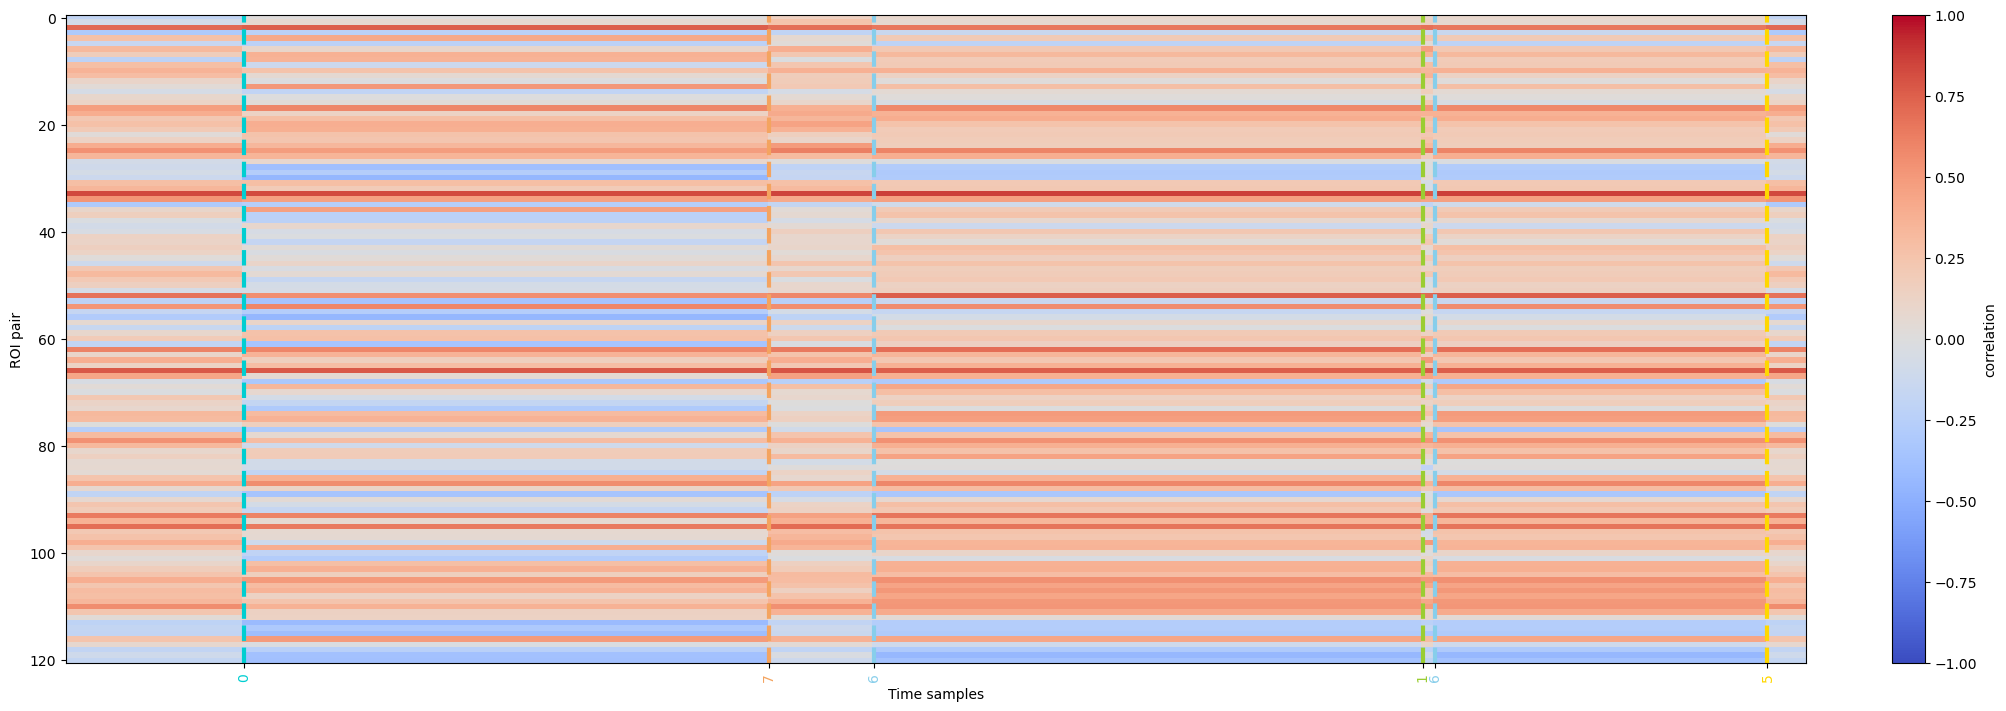

################################################################
subject  7


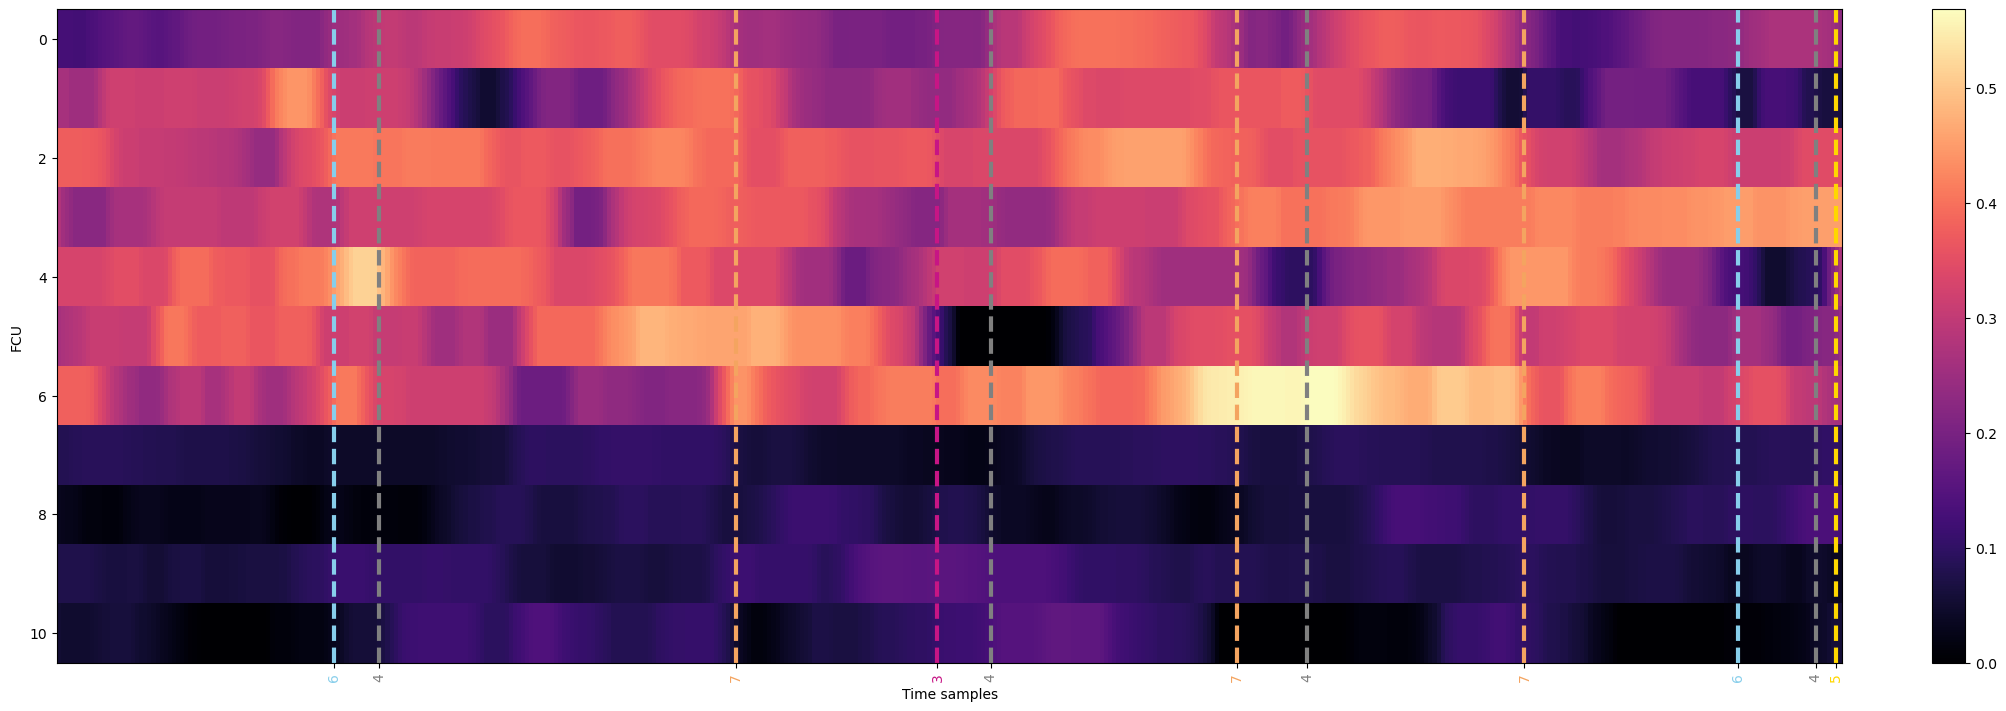

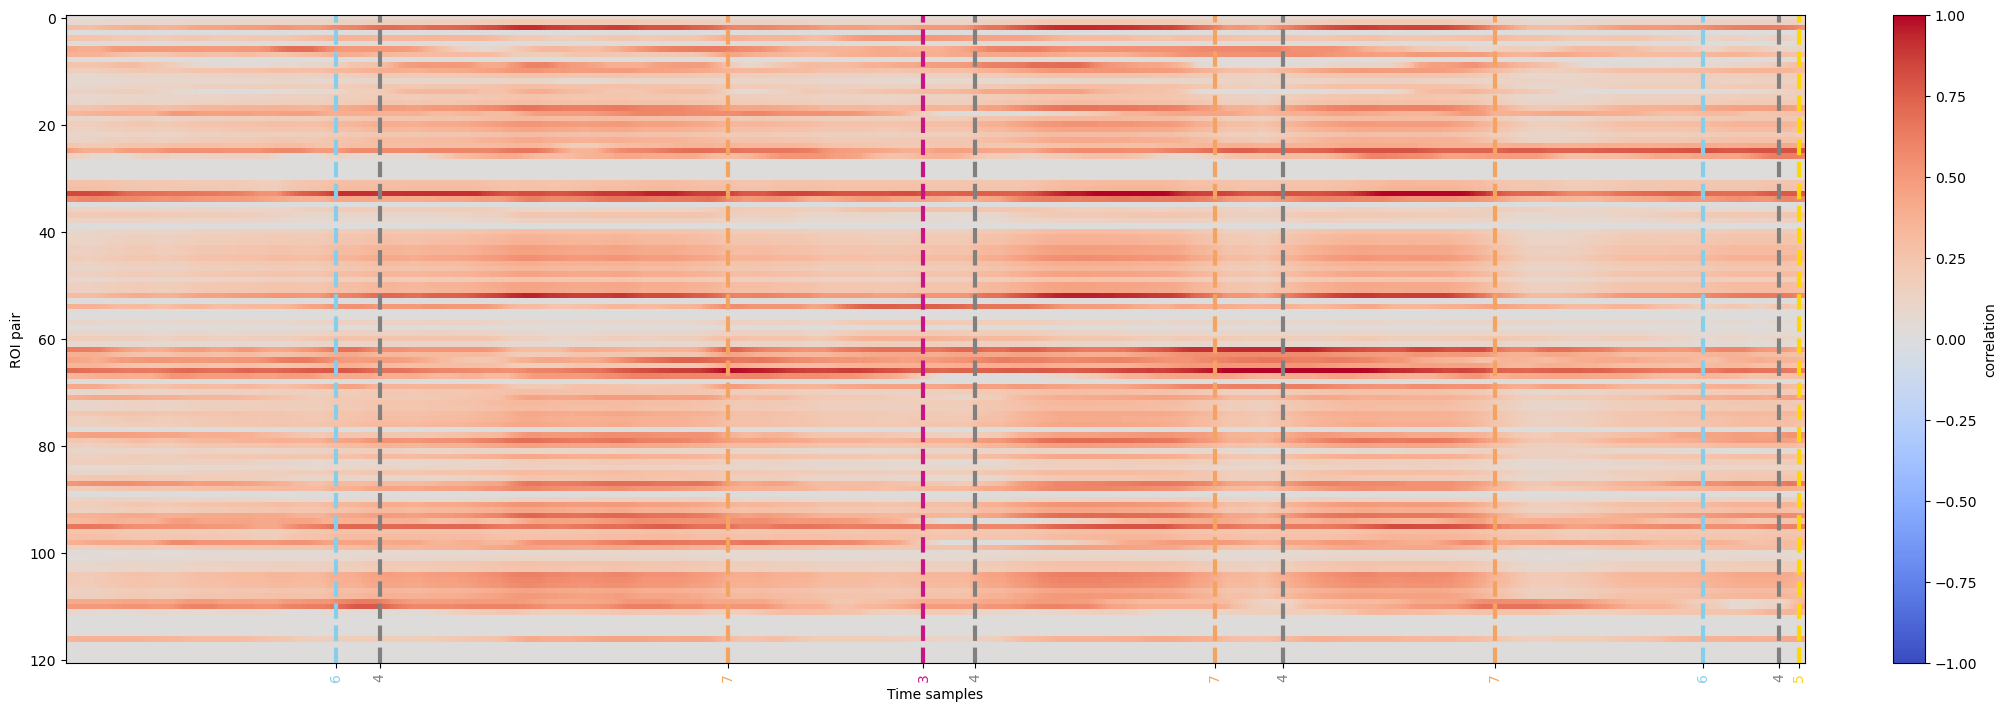

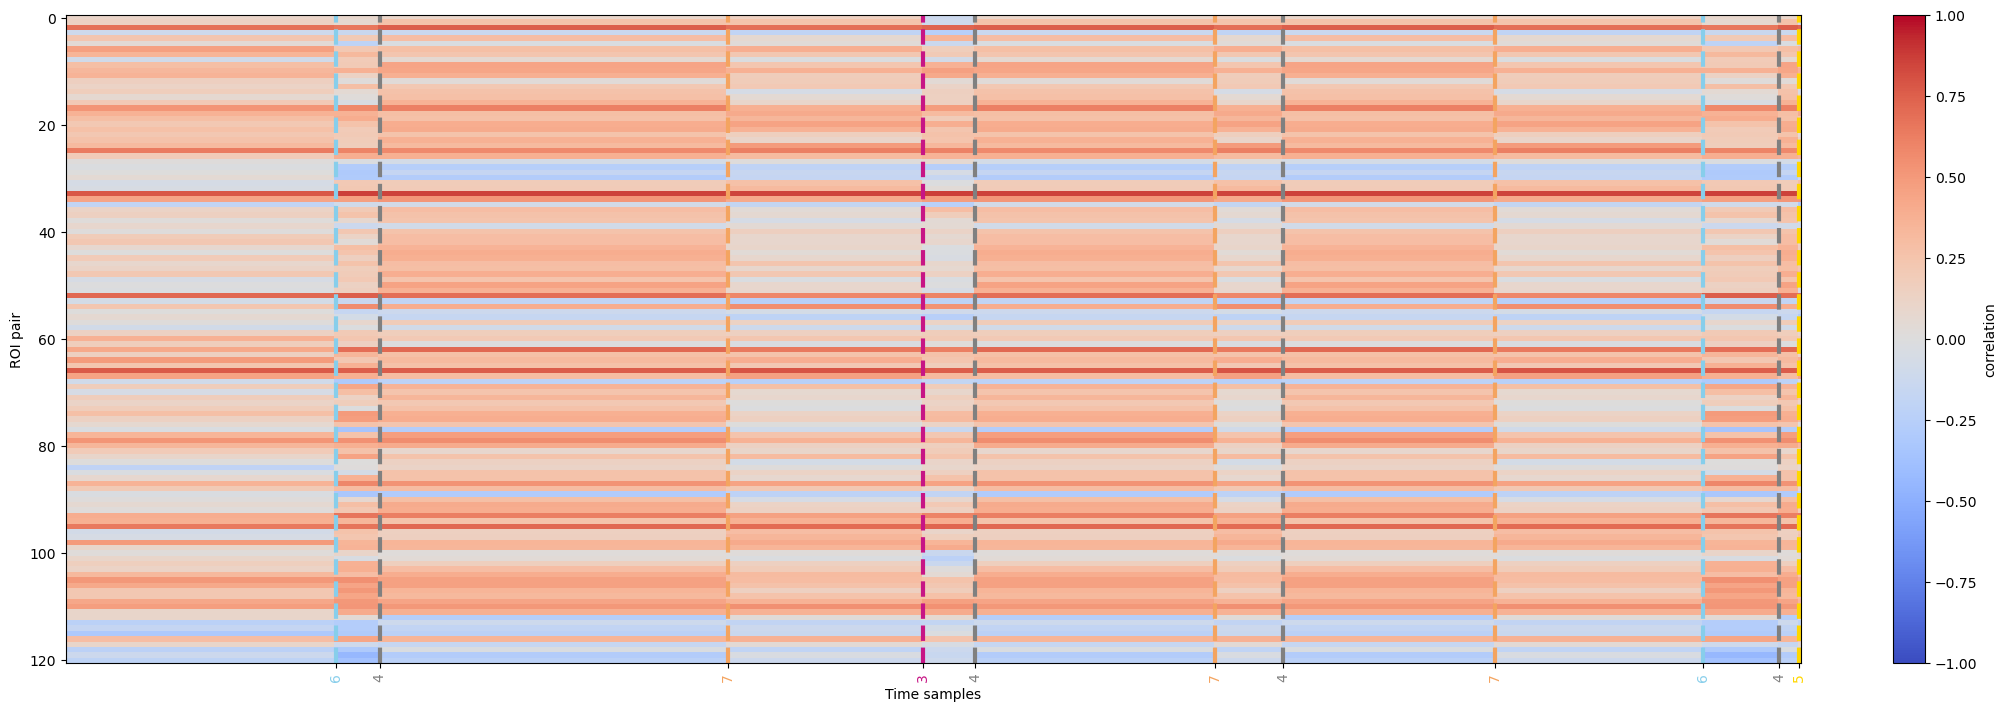

In [33]:
n_clusters = 8
centroids_concatenated, states_concatenated = kmeans_clustering(Cvec_concatenated, n_clusters=n_clusters)


for s, result in enumerate(results_list):
    print("################################################################")
    print("subject " , s)
    states = states_concatenated[s*T: (s+1)*T-1]
    transitions = np.diff(states ,prepend = -1) != 0
    transitions_idx = np.where(transitions)[0]
    
    C_kmeans = k_means_reconstruc_C(centroids_concatenated, states)
    
    A_est = result["A_est"]
    D_est = result["D_est"]
    C_est =result["C_est"]
    
    
    ########################## A #####################
    fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
    plt.imshow(A_est, aspect = 'auto', interpolation = 'nearest', cmap = 'magma')
    plt.xlabel("Time samples")
    plt.ylabel("FCU")
    plt.grid(False)
    plt.colorbar()
    
    #mark the transitions of the states
    plt.xticks(transitions_idx , states[transitions_idx], rotation = 90)

    for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
        #set the xtick to the colors of the state
        state_color = list_colors[states[tr_idx]]
        label.set_color(state_color)
        #mark the transition of the states
        plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)
    
    plt.show()
    
    ########################## C #####################
    fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
    plt.imshow(C_est, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
    plt.xlabel("Time samples")
    plt.ylabel("ROI pair")
    plt.grid(False)
    plt.colorbar(label = "correlation")
    
    #mark the transitions of the states
    plt.xticks(transitions_idx , states[transitions_idx], rotation = 90)

    for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
        #set the xtick to the colors of the state
        state_color = list_colors[states[tr_idx]]
        label.set_color(state_color)
        #mark the transition of the states
        plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)
    
    plt.show()
    
    ########################## C Kmeans#####################
    fig, ax = plt.subplots(layout = "constrained" , figsize=(20,7))
    plt.imshow(C_kmeans, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
    plt.xlabel("Time samples")
    plt.ylabel("ROI pair")
    plt.grid(False)
    plt.colorbar(label = "correlation")
    
    #mark the transitions of the states
    plt.xticks(transitions_idx , states[transitions_idx], rotation = 90)

    for i , (tr_idx , label) in enumerate(zip(transitions_idx, ax.get_xticklabels())):
        #set the xtick to the colors of the state
        state_color = list_colors[states[tr_idx]]
        label.set_color(state_color)
        #mark the transition of the states
        plt.axvline(tr_idx,ls='--',color=state_color,linewidth=3)
    plt.show()

In [44]:
centroid = np.zeros((int(R*(R-1)/2) , n_clusters))

for i in range(n_clusters):
    centroid[ active_pairs , i] = centroids_concatenated[: , i]

In [45]:
C_list_centroid = rebuild_C_matrix(centroid)

In [46]:
plt.rcParams.update({'font.size': 10})

### Display centoids

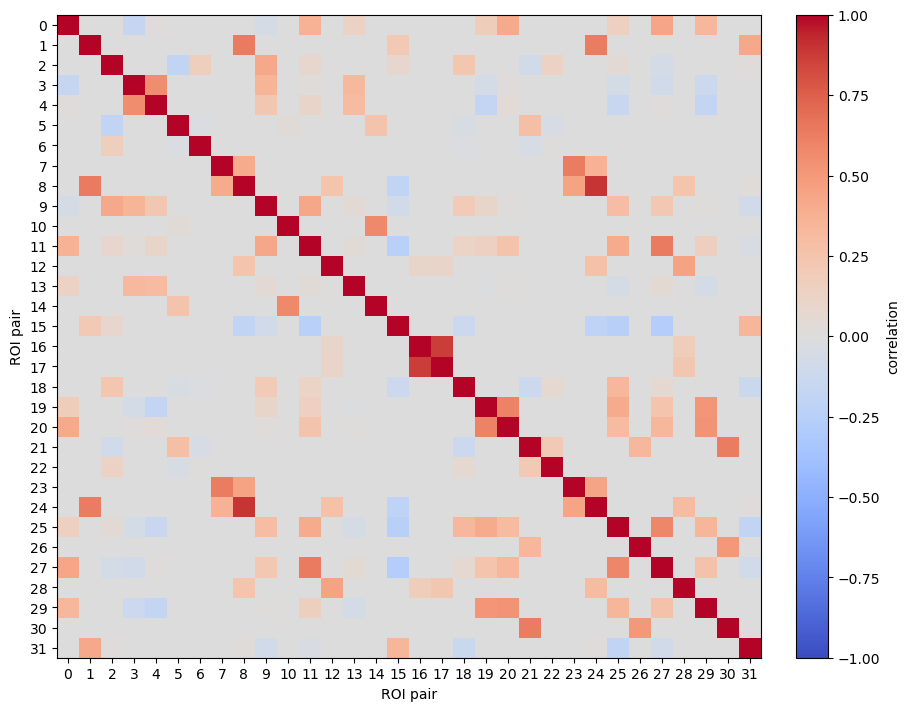

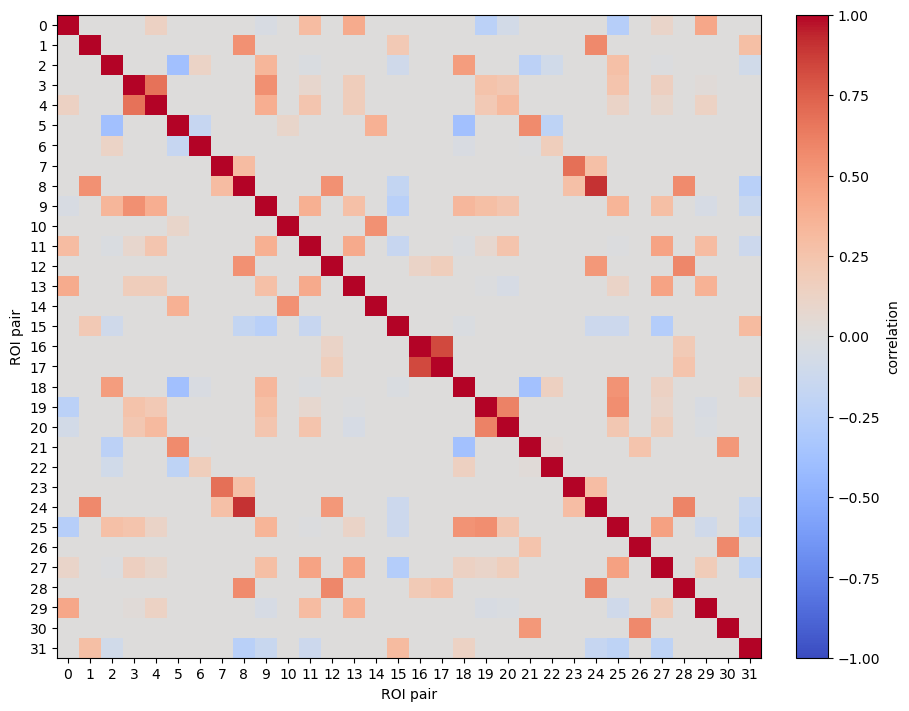

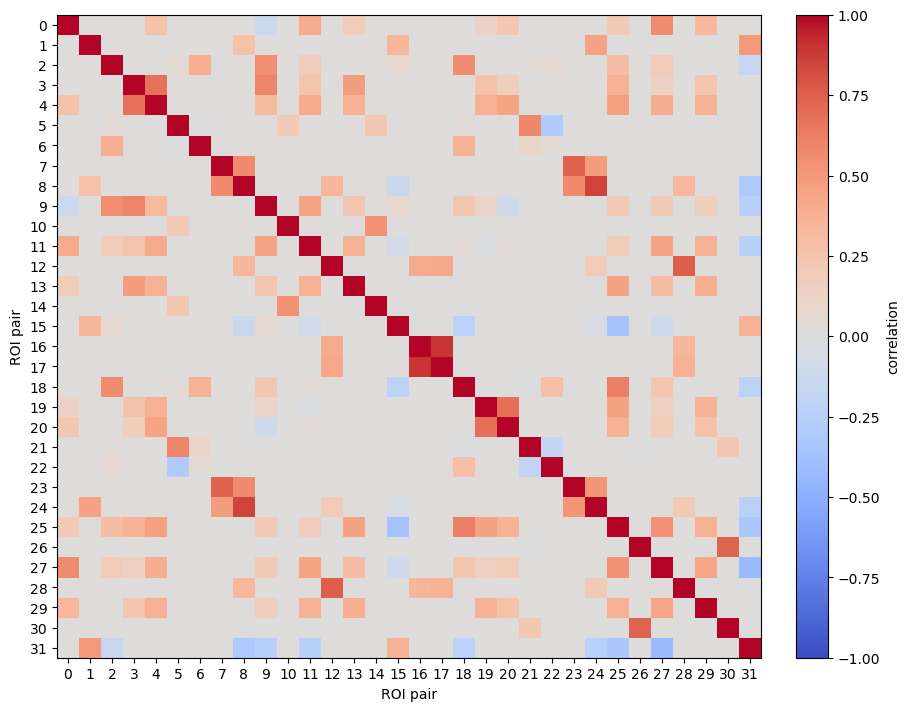

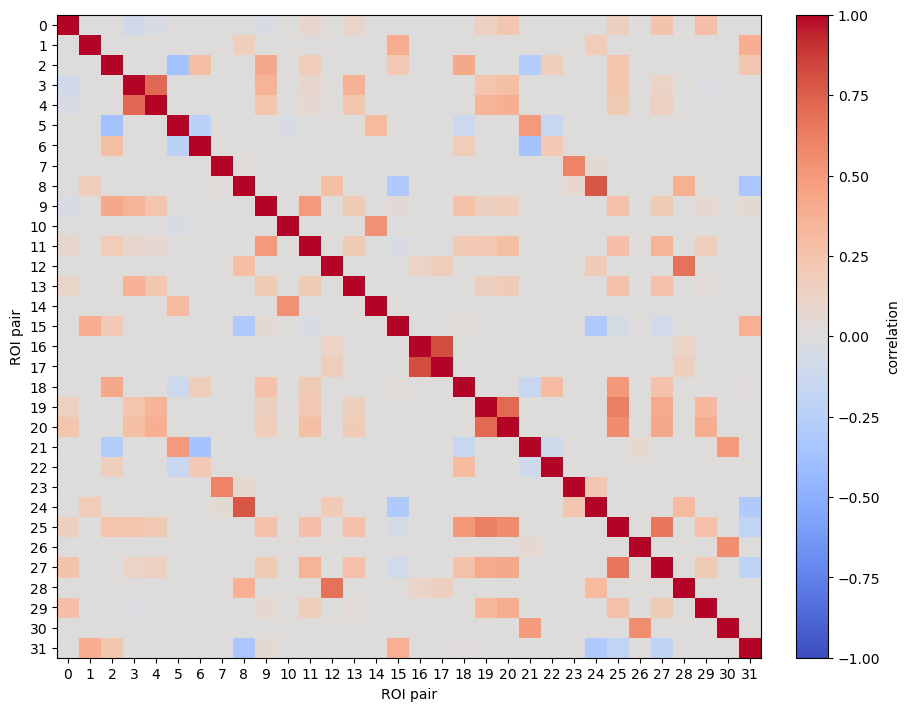

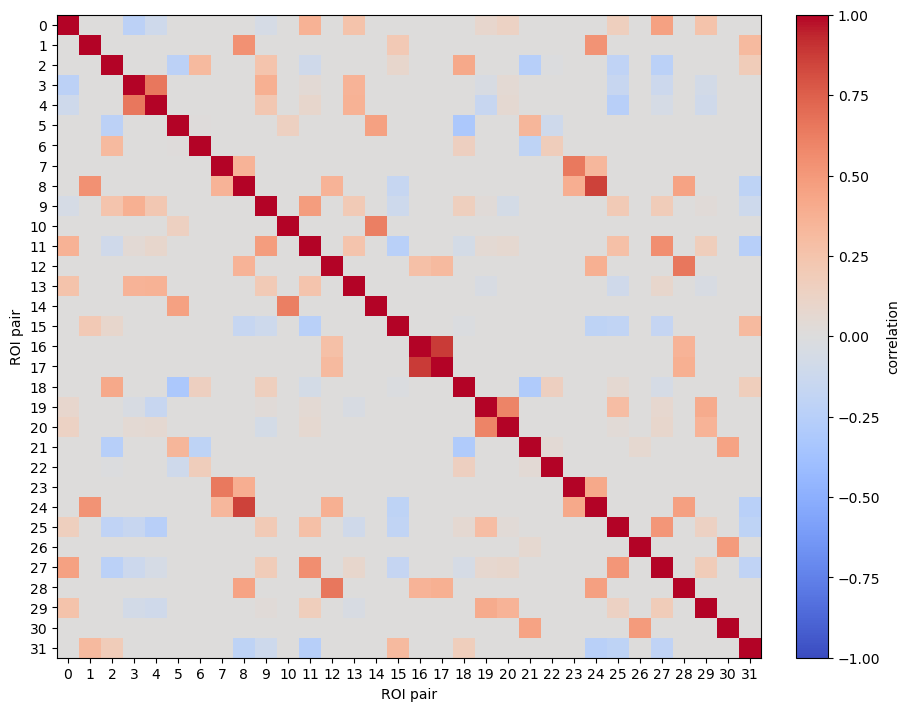

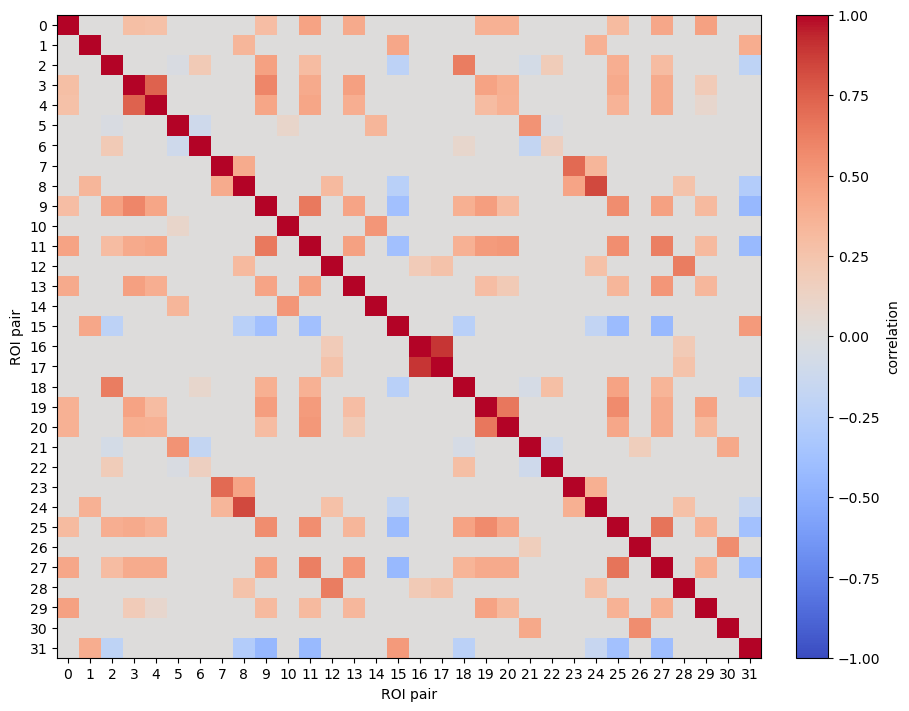

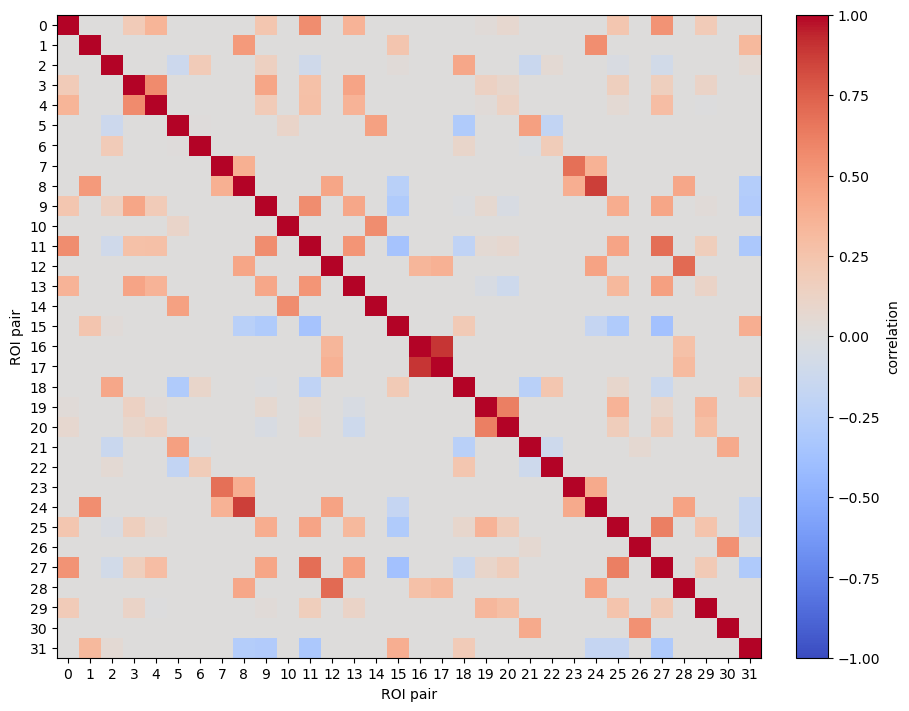

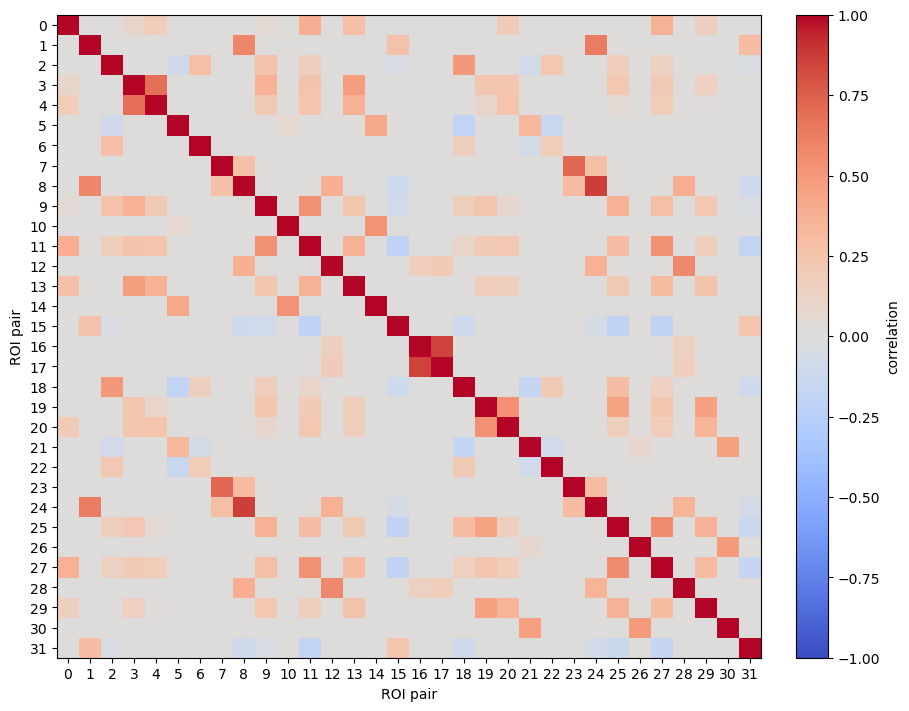

In [50]:
for i, C in enumerate(C_list_centroid):
    fig, ax = plt.subplots(layout = "constrained" , figsize=(9,7))
    plt.imshow(C, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
    plt.xlabel("ROI pair")
    plt.xticks(range(R))
    plt.yticks(range(R))
    plt.ylabel("ROI pair")
    plt.grid(False)
    plt.colorbar(label = "correlation")

# Plot for paper Eusipco

In [15]:
s_id = 0
result = results_list[s_id]
A_est = result["A_est"]
D_est = result["D_est"]
C_est =result["C_est"]
Cvec = Cvec_list[s_id]

In [19]:
# group study
Cvec_concatenated = np.concatenate(Cvec_list , axis =1)
#Cvec_concatenated[Cvec_concatenated<0] =0
n_clusters = 10
centroids_concatenated, states_concatenated = kmeans_clustering(Cvec_concatenated, n_clusters=n_clusters)
states = states_concatenated[s_id*T: (s_id +1)*T]
transitions = np.diff(states ,prepend = -1) != 0
transitions_idx = np.where(transitions)[0]

C_kmeans = k_means_reconstruc_C(centroids_concatenated, states)

In [20]:
# individual study
n_clusters = 8
centroids, states = kmeans_clustering( Cvec, n_clusters=n_clusters)
transitions = np.diff(states ,prepend = -1) != 0
transitions_idx = np.where(transitions)[0]

C_kmeans = k_means_reconstruc_C(centroids, states)

In [21]:
plt.rcParams.update({'font.size': 17})

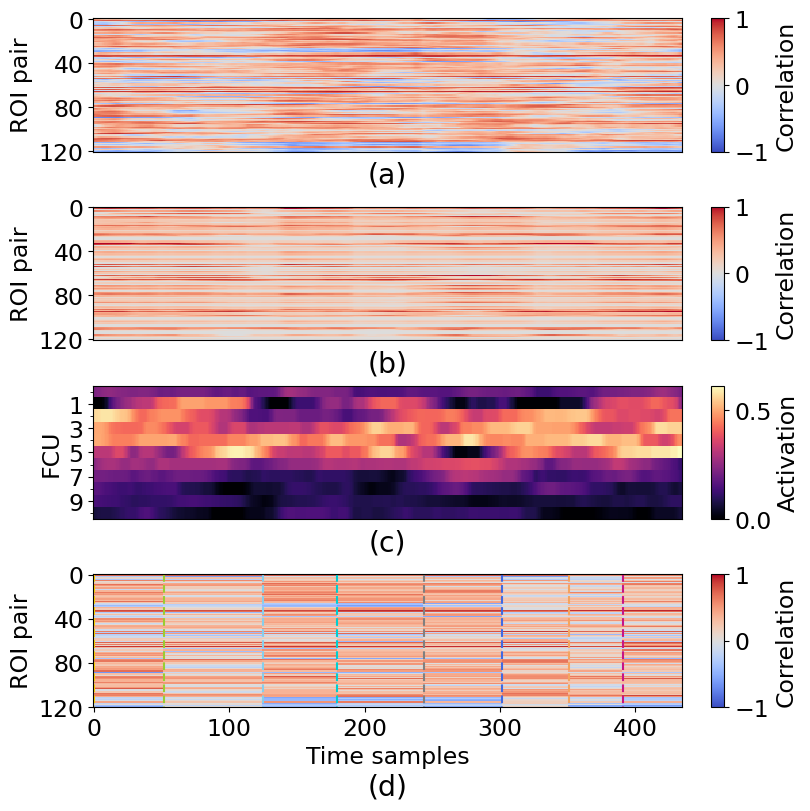

In [28]:
#joitn plot for Cest, C and A
plt.figure(layout = "constrained" , figsize=(8, 8))
ax1 = plt.subplot(411)
plt.imshow(Cvec, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
#plt.xlabel("Time samples")
plt.ylabel("ROI pair")
plt.xticks([])
plt.grid(False)
plt.title("(a)" , y = -0.3)
plt.colorbar(label = "Correlation" , aspect = 10)

plt.subplot(412,  sharey= ax1)
plt.imshow(C_est, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
#plt.xlabel("Time samples")
plt.xticks([])
plt.ylabel("ROI pair")
plt.grid(False)
plt.title("(b)" , y = -0.3)
plt.colorbar(label = "Correlation" , aspect = 10)


plt.subplot(413)#, sharex = ax1)
plt.imshow(A_est, aspect = 'auto', interpolation = 'nearest', cmap = 'magma')
#plt.xlabel("Time samples")
plt.yticks(np.arange(1, P, 2) )
plt.yticks(np.arange(0, P, 2), minor =True)
plt.ylabel("FCU")
plt.xticks([])
plt.grid(False)
plt.title("(c)" , y = -0.3)
plt.colorbar(label ="Activation" , aspect = 10)#fraction=0.009 ,

ax2 = plt.subplot(414,  sharey= ax1)
plt.imshow(C_kmeans, aspect = 'auto', interpolation = 'nearest', cmap = 'coolwarm', vmin = -1, vmax = 1)
#plt.xlabel("Time samples")
plt.ylabel("ROI pair")
plt.yticks([0, 40, 80, 120])
plt.grid(False)
plt.title("(d)" , y = -0.72)
plt.colorbar(label = "Correlation" , aspect = 10)
ax2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
ax2.set_xlabel("Time samples")
#mark the transitions of the states

ax2.vlines(transitions_idx, ymin =-0.5, ymax = E-0.5 , linestyles="--"  , color = [list_colors[states[idx]] for idx in transitions_idx])


In [29]:
def RMSE(C, Cest):
    return np.sqrt(np.mean((C - Cest)**2))

In [30]:
RMSE(Cvec, C_est)

0.26391562101294797

In [31]:
RMSE(Cvec, C_kmeans)

0.11383181482171827